In [1]:
#imports
import astropy.units as u
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from astropy.coordinates import SkyCoord, Distance
#import popsims
import matplotlib.pyplot as plt
#%matplotlib notebook
from tqdm import tqdm
from astropy.constants import G
#import HSS
from gala.units import galactic
import gala.coordinates as gc
import  h5py
import imageio
import matplotlib as mpl

import seaborn as sns
sns.set_style("dark")
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
font = {#'family' : 'Helvetica',
        'size'   : 16}
plt.style.use('dark_background')

In [14]:
path_plot = '/users/caganze/research/stellarstreams/figures/stream/'
path_data = '/users/caganze/research/stellarstreams/data/'

In [3]:
import astropy.coordinates as coord
_ = coord.galactocentric_frame_defaults.set('v4.0')

pot=gp.MilkyWayPotential()
H = gp.Hamiltonian(pot)

In [4]:
def generate_stream_and_perturber(mass, prog_w0, timedict,  nbody=None, output_every=None,
                                  output_filename=None):
    """
    Input: mass of the progenitor, its position, other mockstream generator kwrargs
    Returns: final stream and its position and velocity
    
    Calls mockstream generator
    
    """
    df = ms.FardalStreamDF()
    prog_mass = mass * u.Msun
    gen = ms.MockStreamGenerator(df, H)

    return gen.run(prog_w0, prog_mass, nbody=nbody,\
                   output_every=output_every, output_filename= output_filename, \
                check_filesize=True, overwrite=True, progress=True, **timedict)

def run_stream_and_subhalo(halo_mass, stream_mass, halo_r, halo_pos, stream_pos, timedict,
                           filename='mockstream',
                            output_every=1, potential_type='plummer'):
    """
    runs a subhalo and a stream 
    
    returns the progenitor position and the final stream
    
    Takes in the parameters of the subhalos
    
    """
    
    #create a plummer sphere 
    point_potential=gp.PlummerPotential(halo_mass*u.Msun,  halo_r, units=galactic)
    
    #if potential_type
    if  potential_type.lower()=='hernquist':
        point_potential=gp.HernquistPotential(halo_mass*u.Msun,  halo_r, units=galactic)
        
    #create an Nbody potential object
    Massive_body=gd.DirectNBody(halo_pos, [point_potential], external_potential=pot)
    
    return  generate_stream_and_perturber(stream_mass,  stream_pos, timedict, \
                                      nbody=Massive_body,
                                    output_every=output_every, \
                                    output_filename=path_data+'/'+filename)

def read_stream_file(filename):
    """
    reads in a saved stream run 
    returns the subhalo, progenitor and stream
    """
    
    f = h5py.File(path_data+'/'+filename, mode='r')
    
    body=f['nbody']
    stream_cont=f['stream']
    return body, stream_cont

def plot_stream_and_body(idx, stream_cont, body, time_dict, \
                        xlim=[-5, 5], ylim=[-5, 5], zlim=[-5, 5]):
    
    body_pos=body['pos']
    stream_pos=stream_cont['pos']
    
    if 't' in time_dict.keys():
        t=time_dict['t'][idx]
    else:
        t= time_dict['tmin']+20*idx*time_dict['dt']
    t=t.to(u.Myr)
    
    fig, (ax, ax1, ax2)=plt.subplots(figsize=(12, 4), ncols=3)
    
    fig.suptitle('T = {:.0f}, Timesetep = {}'.format(t,idx ), fontsize=16)

    
    ax.scatter(stream_pos[0][idx], stream_pos[1][idx],  s=1, alpha=0.5, c='#FFFFFF', label='Stream')
    ax.scatter(body_pos[0][idx][1], body_pos[1][idx][1],  s=100, alpha=0.5, c='#01FF70',\
               label='Subhalo')
    
    
    ax1.scatter(stream_pos[0][idx], stream_pos[-1][idx],  s=1, alpha=0.5, c='#FFFFFF', label='Stream')
    ax1.scatter(body_pos[0][idx][1], body_pos[-1][idx][1],  s=100, alpha=0.5, c='#01FF70',\
               label='Subhalo')
    
    ax2.scatter(stream_pos[1][idx], stream_pos[-1][idx],  s=1, alpha=0.5, c='#FFFFFF', label='Stream')
    ax2.scatter(body_pos[1][idx][1], body_pos[-1][idx][1],  s=100, alpha=0.5, c='#01FF70',\
               label='Subhalo')
   
    

    ax.minorticks_on()
    ax1.minorticks_on()

    ax1.legend(fontsize=14)
    ax.set(xlabel='x (pc)', ylabel='y (pc)')
    ax1.set(xlabel='x (pc)', ylabel='z (pc)')
    ax2.set(xlabel=r'y (pc)', ylabel='z (pc)')
    
    ax.set(xlim=xlim, ylim=ylim)
    ax1.set(xlim=xlim, ylim=zlim)
    ax2.set(xlim=ylim, ylim=zlim)
    
    plt.tight_layout()
    
    
    # IMPORTANT ANIMATION CODE HERE
    # Used to keep the limits constant

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    


    return image

In [5]:
#compute a stream and then add acceleration from subhalo
st_pos = gd.PhaseSpacePosition(pos=[10., 0., 0.] * u.kpc,
                                vel=[0, 170, 0.] * u.km/u.s)
halo_pos = gd.PhaseSpacePosition(pos=[10., 0., 0.0] * u.kpc,
                                      vel=[0.,  0., -500] * u.km/u.s)

In [6]:
mstream=5e4
mhalo=1e9
halo_r=1*u.pc
tmax=500
tmin=0.
nsteps=300
filename='nsims_cntrolle_mhalo{:.1e}_mstream{:.1e}_rhalo{:.1e}_tmax{:.1e}_tmin{:1e}'.format(mhalo, mstream, halo_r,tmax, tmin )
#time_dict={'t1': tmin, 't2': tmax,  'n_steps': nsteps }
time_dict={'t': np.linspace(tmin, tmax, nsteps)*u.Myr}

In [7]:
filename

'nsims_cntrolle_mhalo1.0e+09_mstream5.0e+04_rhalo1.0e+00 pc_tmax5.0e+02_tmin0.000000e+00'

In [8]:
#not cool
#orbit1 = gp.Hamiltonian(pot).integrate_orbit(st_pos,  n_steps=nsteps, **time_dict)
#orbit2= gp.Hamiltonian(pot).integrate_orbit(halo_pos,   n_steps=nsteps,  **time_dict)

In [9]:
time_dict['t']

<Quantity [  0.        ,   1.6722408 ,   3.34448161,   5.01672241,
             6.68896321,   8.36120401,  10.03344482,  11.70568562,
            13.37792642,  15.05016722,  16.72240803,  18.39464883,
            20.06688963,  21.73913043,  23.41137124,  25.08361204,
            26.75585284,  28.42809365,  30.10033445,  31.77257525,
            33.44481605,  35.11705686,  36.78929766,  38.46153846,
            40.13377926,  41.80602007,  43.47826087,  45.15050167,
            46.82274247,  48.49498328,  50.16722408,  51.83946488,
            53.51170569,  55.18394649,  56.85618729,  58.52842809,
            60.2006689 ,  61.8729097 ,  63.5451505 ,  65.2173913 ,
            66.88963211,  68.56187291,  70.23411371,  71.90635452,
            73.57859532,  75.25083612,  76.92307692,  78.59531773,
            80.26755853,  81.93979933,  83.61204013,  85.28428094,
            86.95652174,  88.62876254,  90.30100334,  91.97324415,
            93.64548495,  95.31772575,  96.98996656,  98.66220

In [10]:
#call mockstream generator
df = ms.FardalStreamDF()
prog_mass = mstream* u.Msun
gen = ms.MockStreamGenerator(df, H)
mock_st, mock_pos=gen.run(st_pos, prog_mass, **time_dict, nbody=None, progress=True)

Integrating orbits:  100%

In [11]:
out =  run_stream_and_subhalo(mhalo, mstream, halo_r, halo_pos, st_pos,  time_dict,
                           filename=filename,   potential_type='plummer')

Integrating orbits:  100%

In [12]:
bdy_all, stream_all=read_stream_file(filename)

/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_11242/3402352743.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax, ax1, ax2)=plt.subplots(figsize=(12, 4), ncols=3)


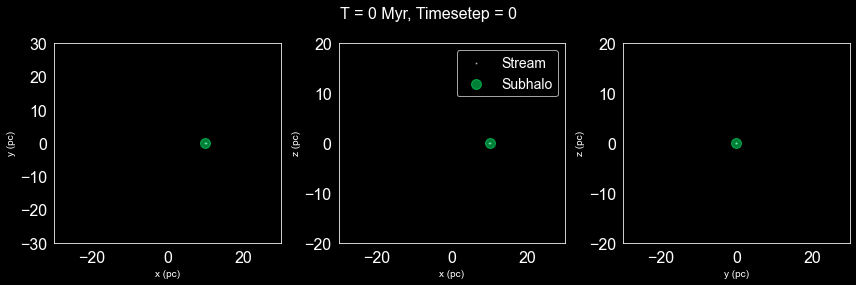

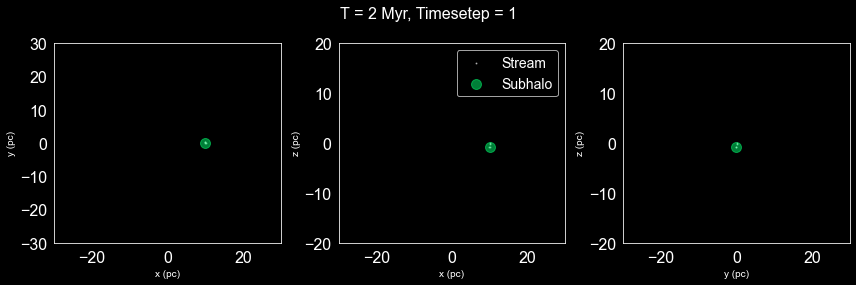

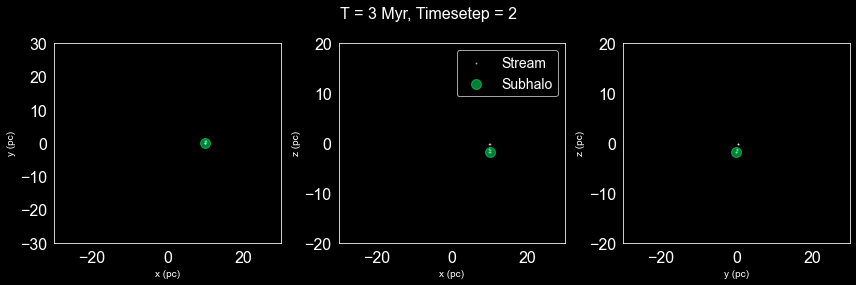

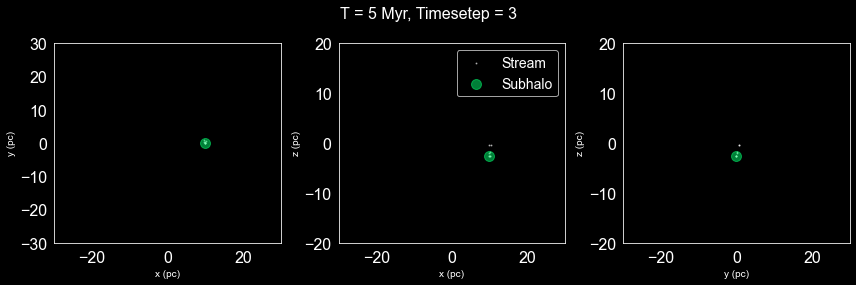

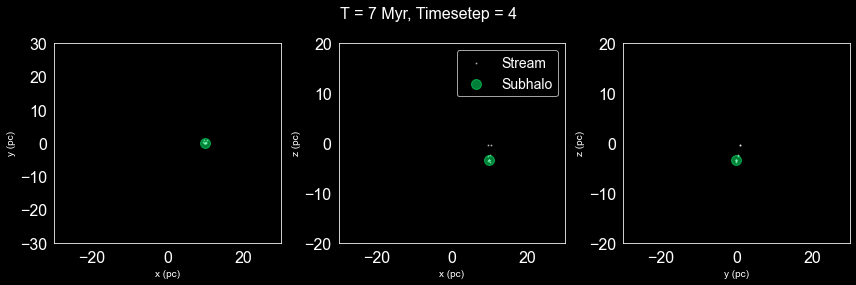

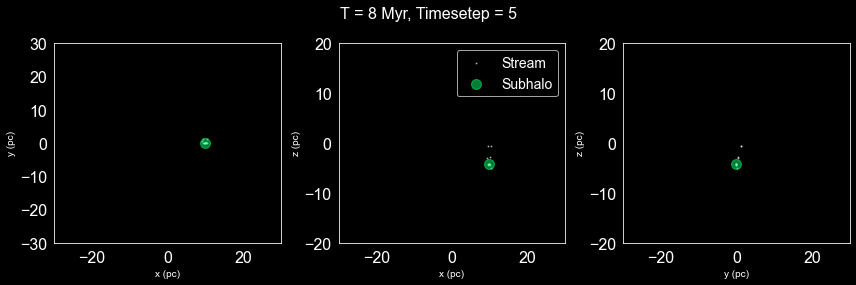

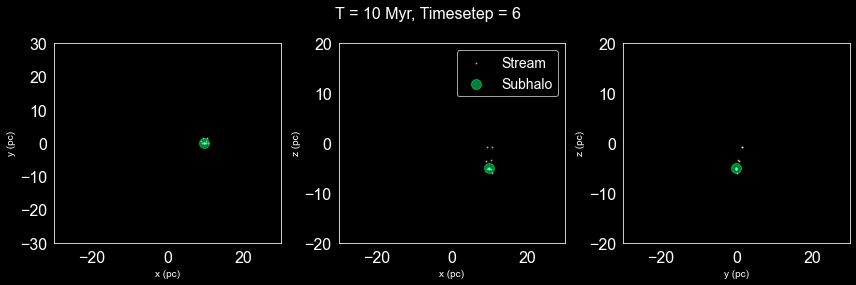

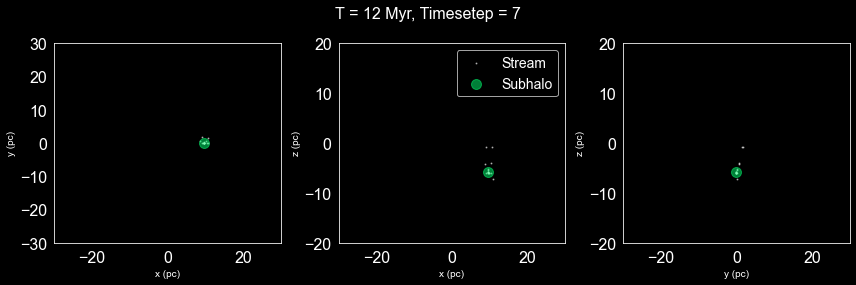

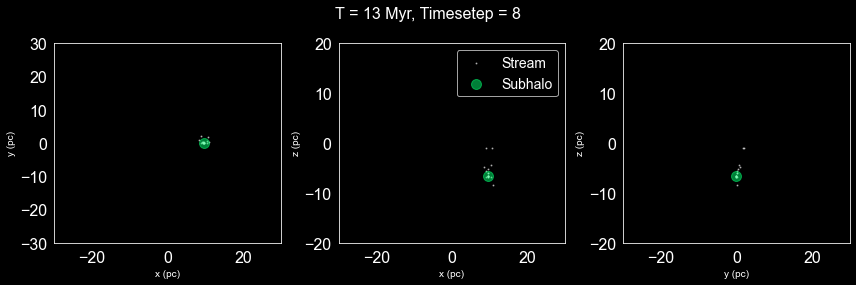

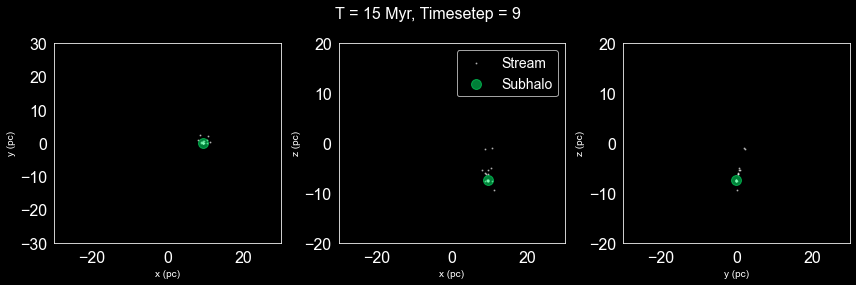

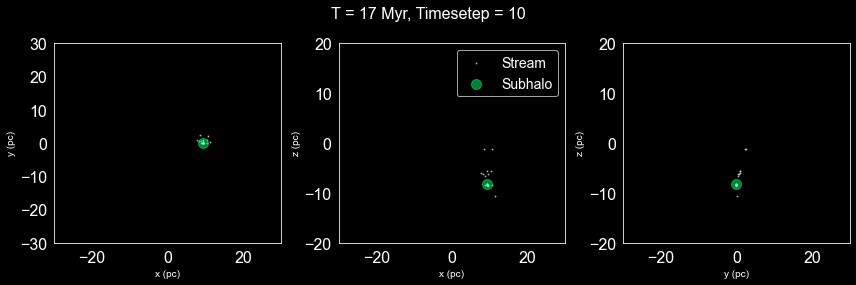

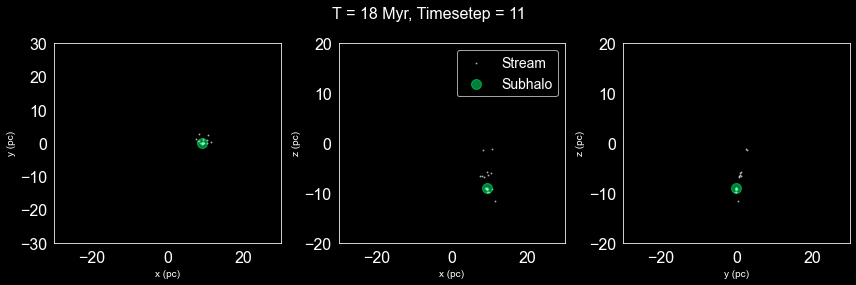

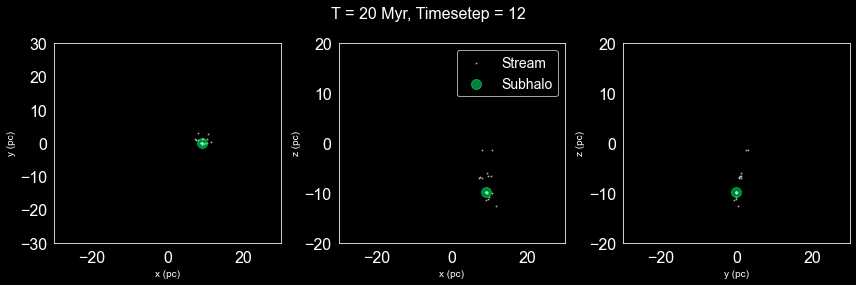

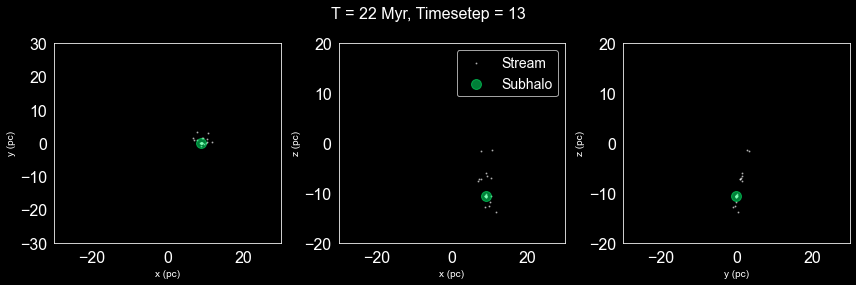

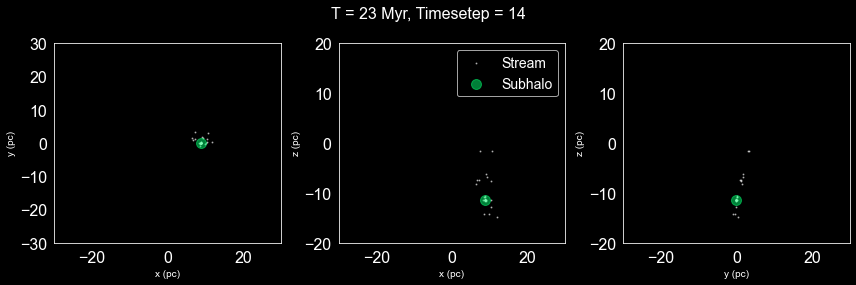

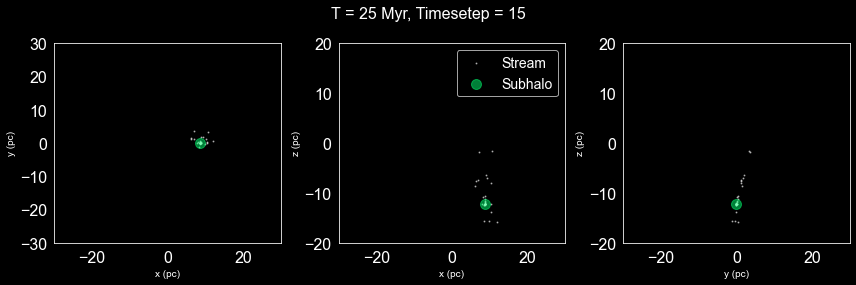

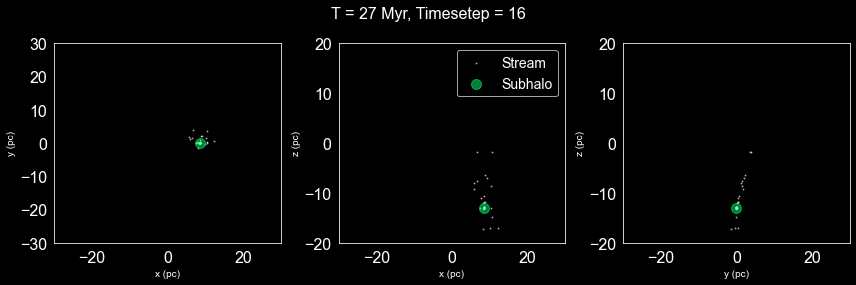

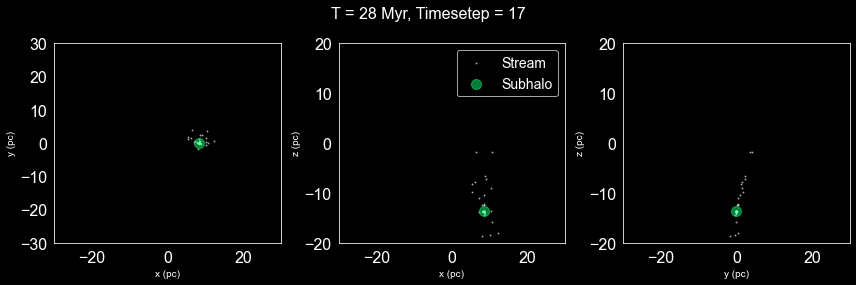

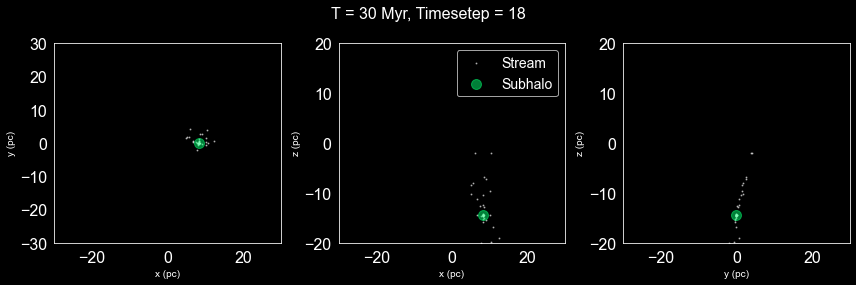

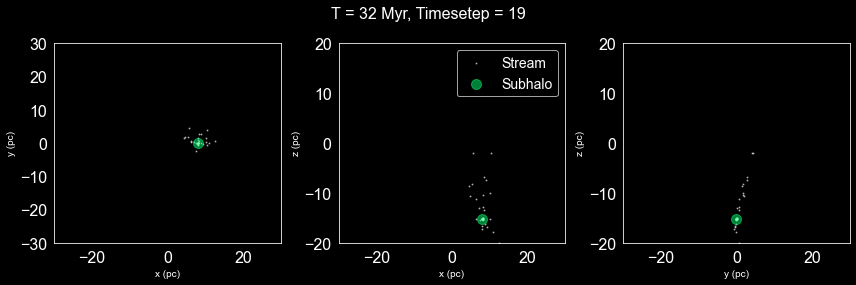

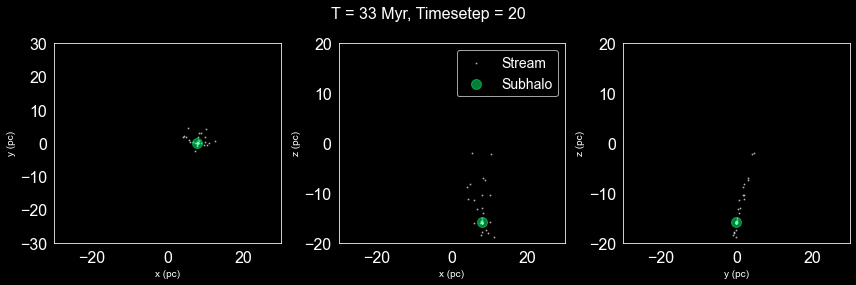

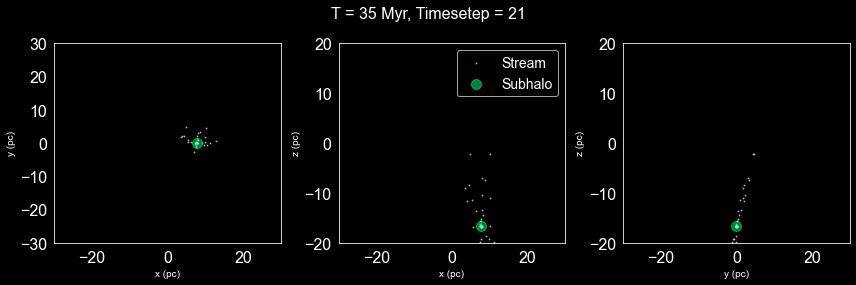

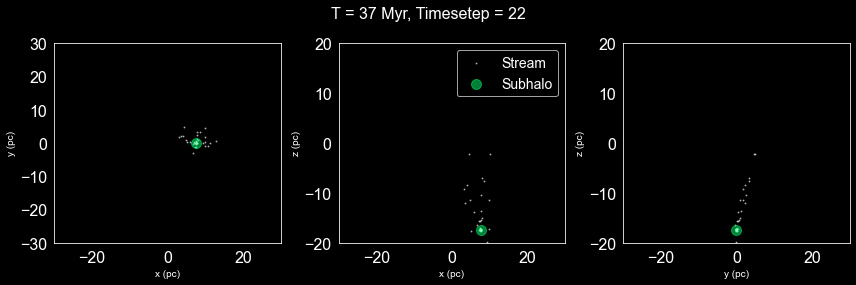

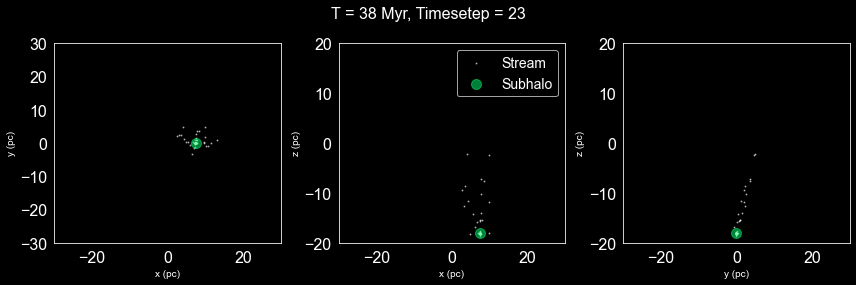

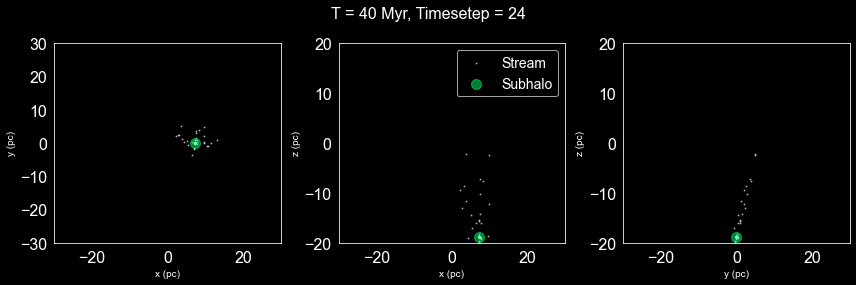

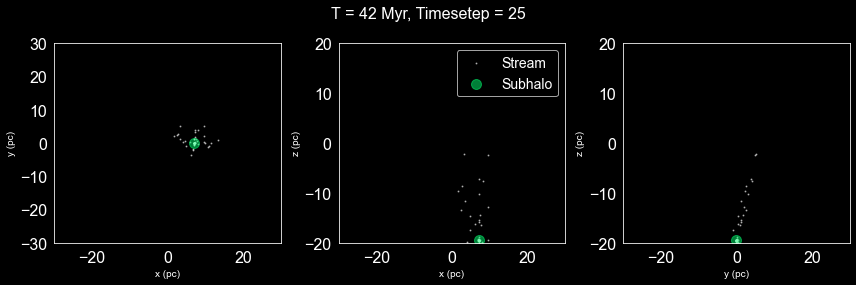

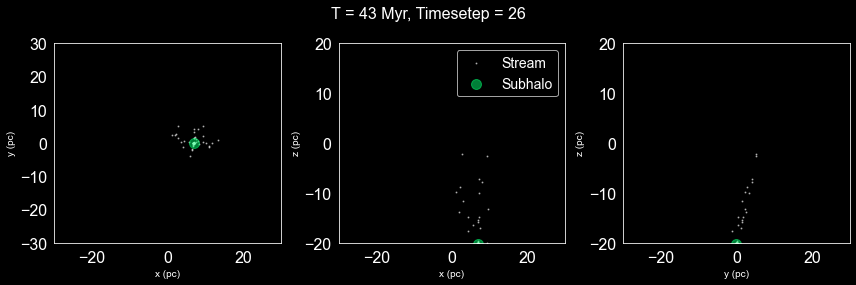

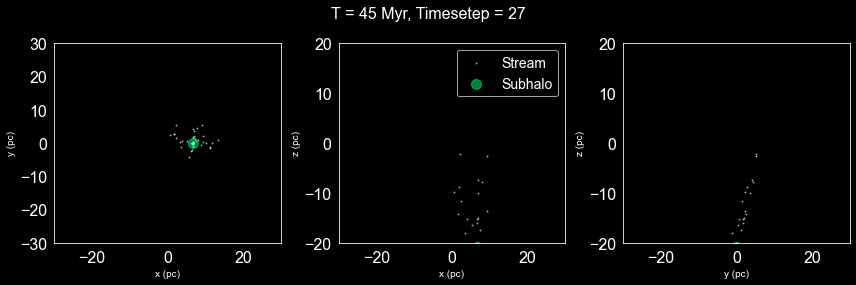

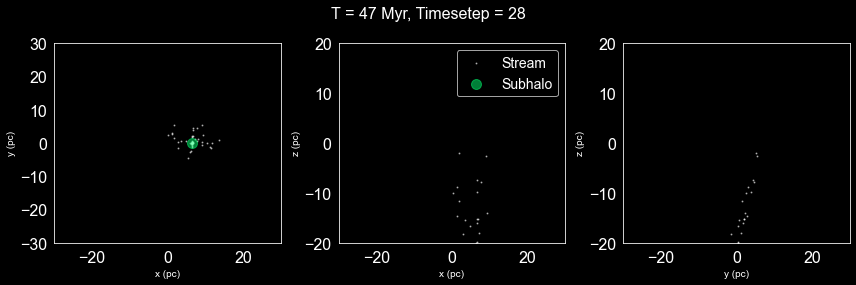

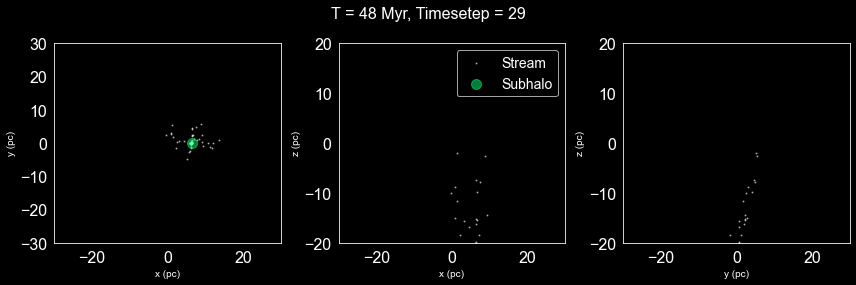

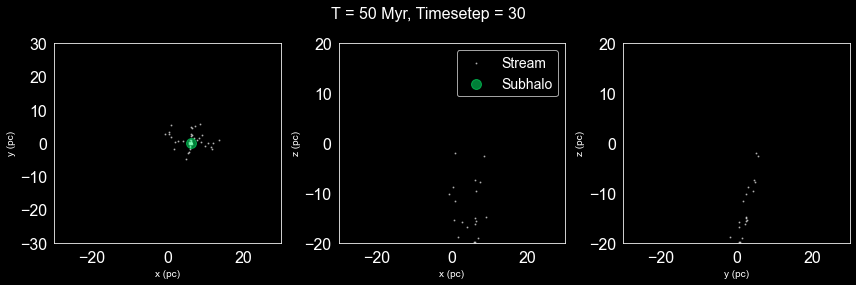

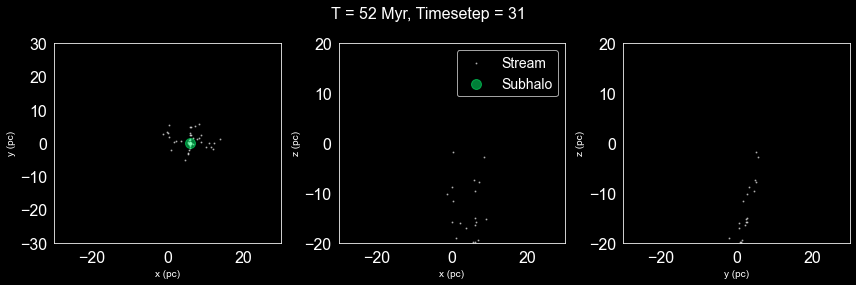

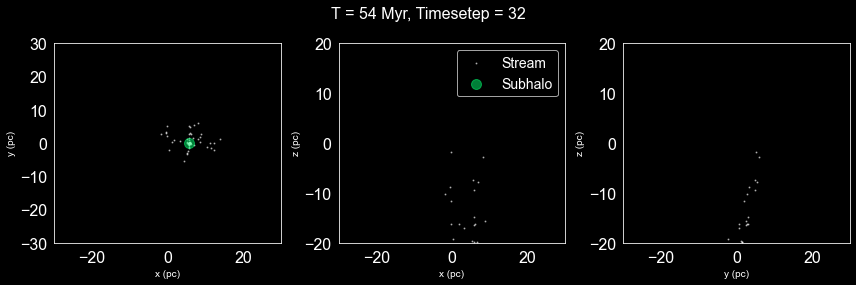

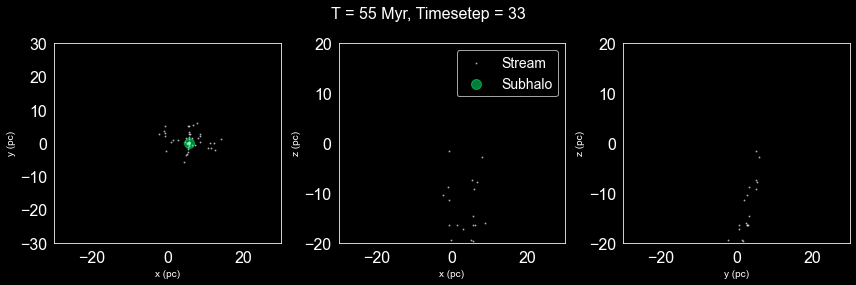

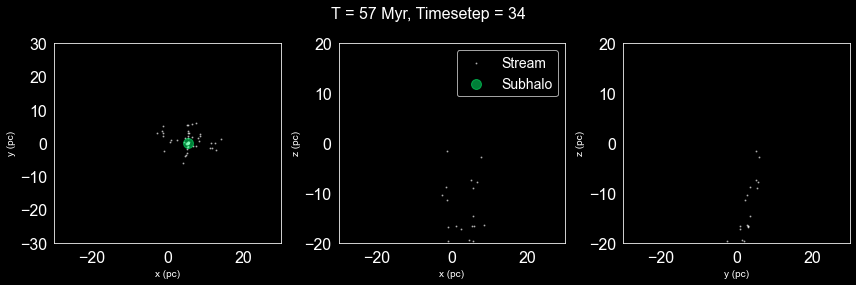

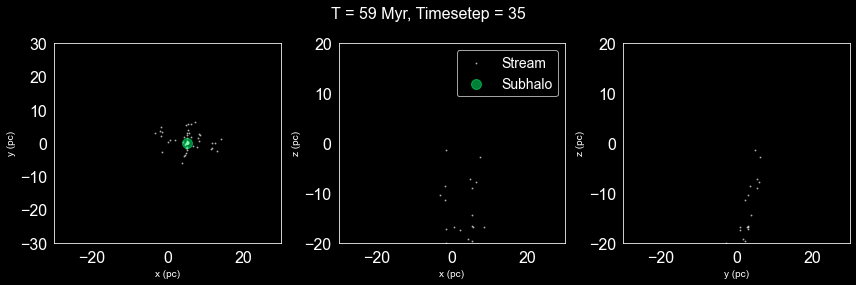

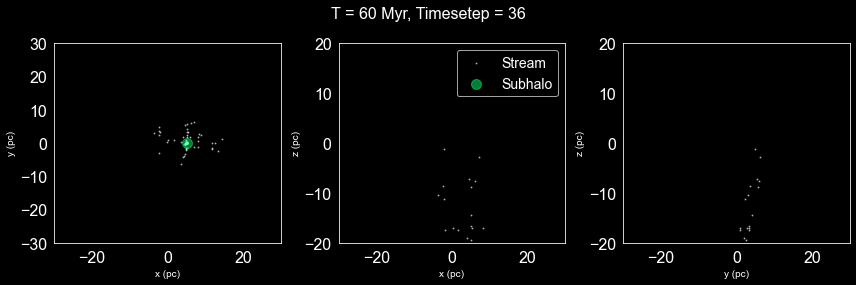

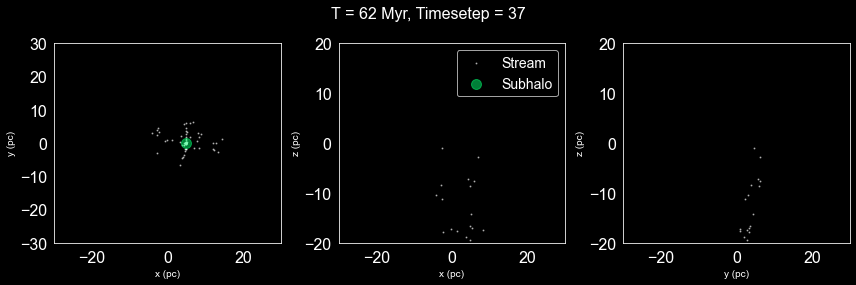

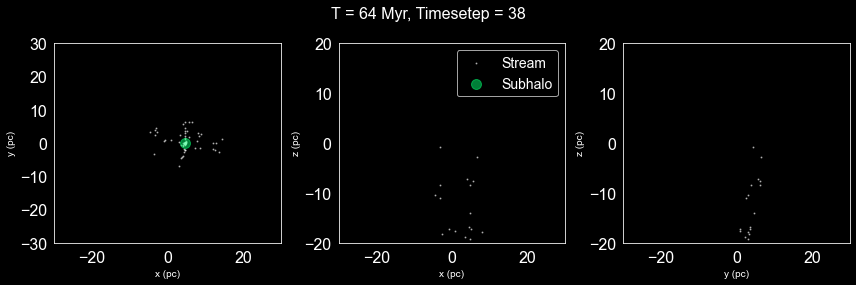

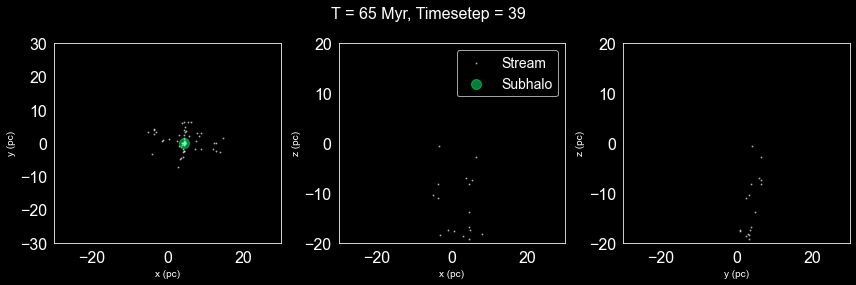

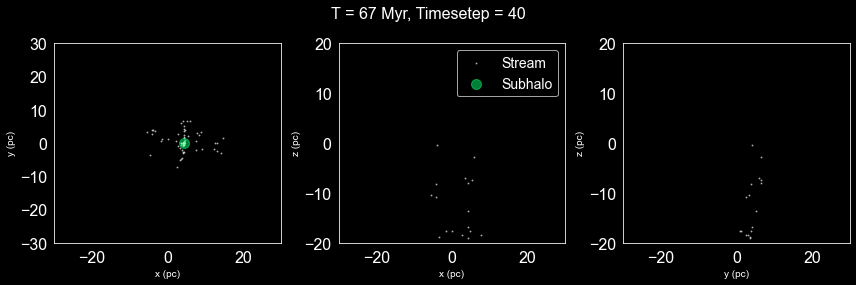

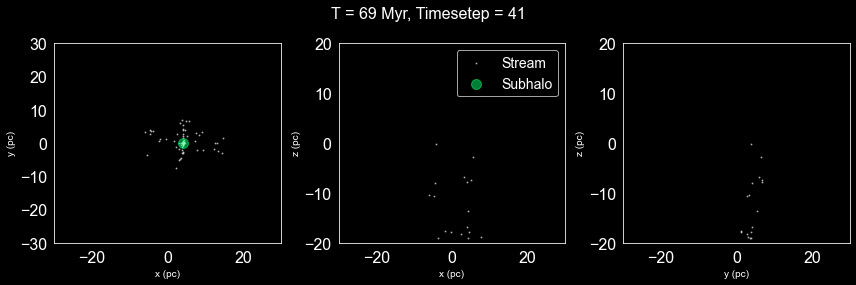

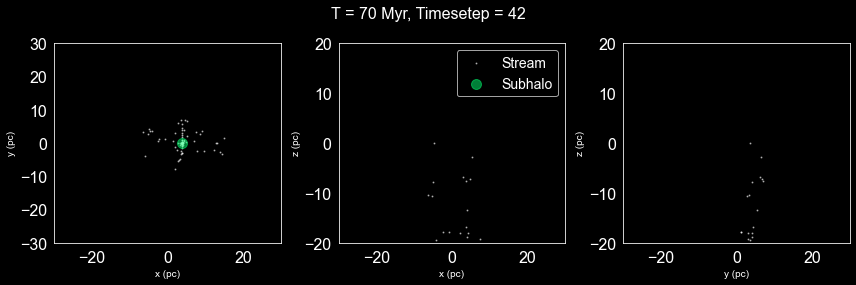

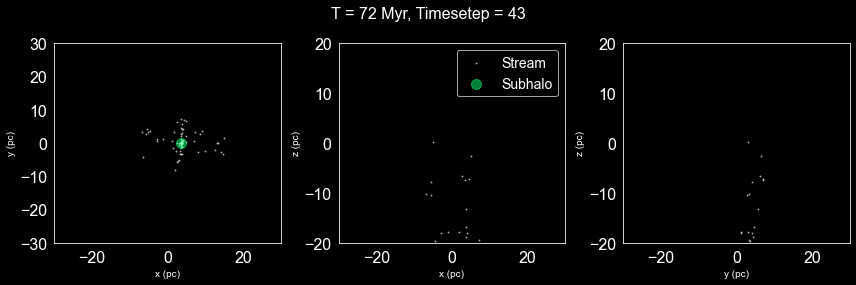

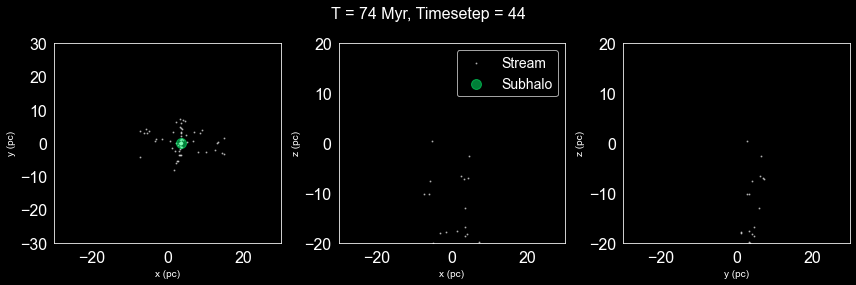

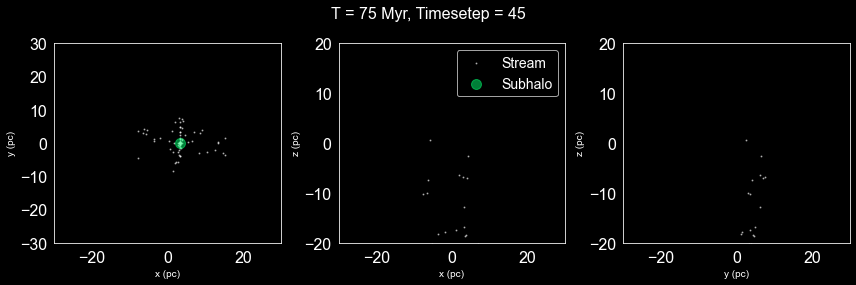

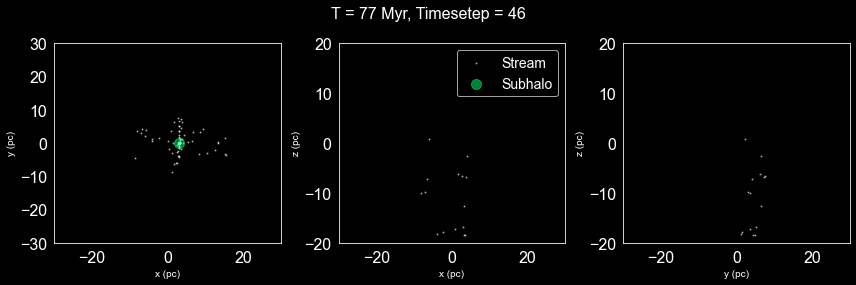

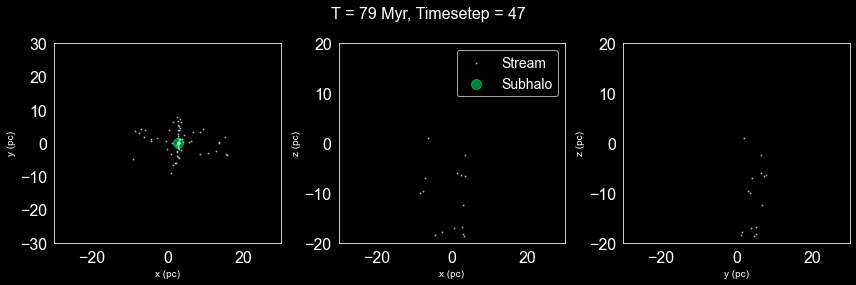

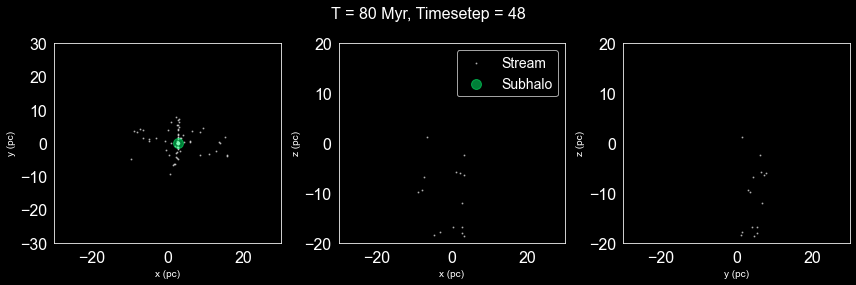

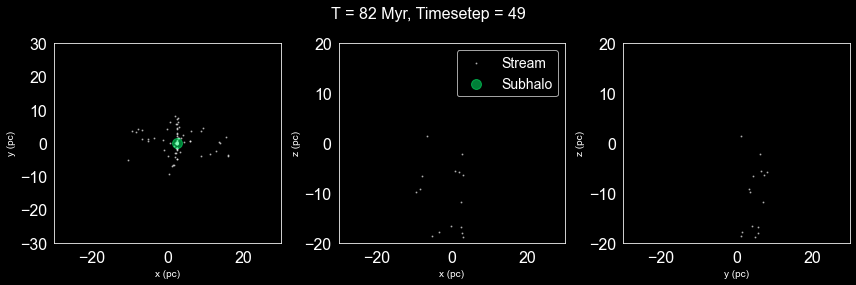

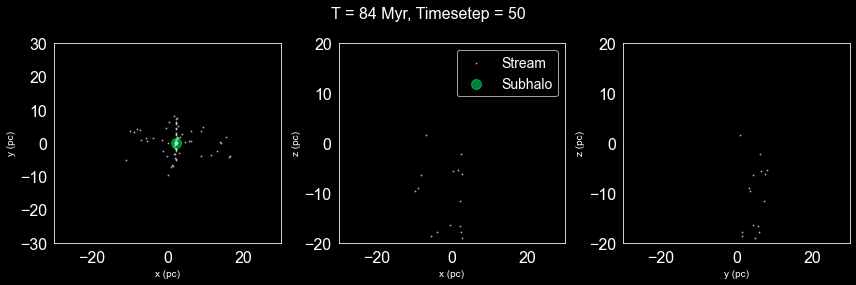

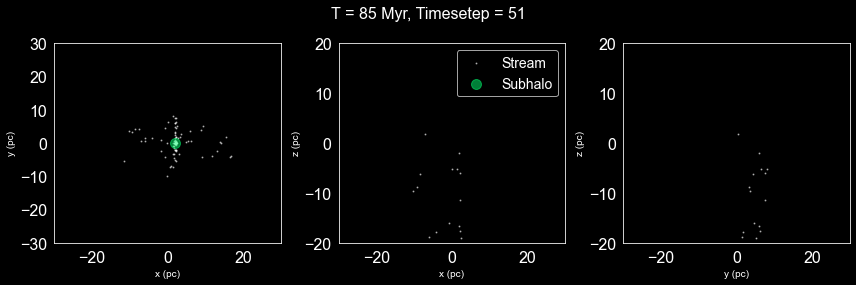

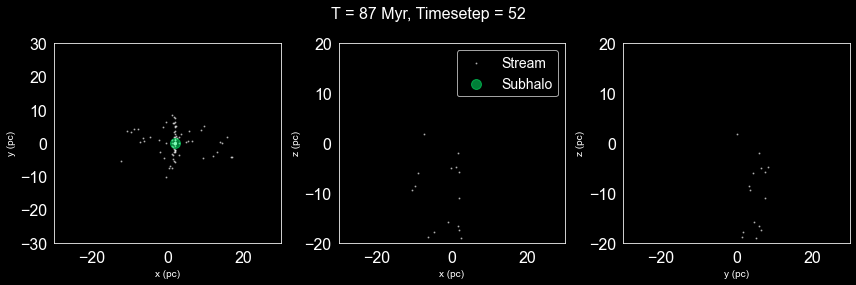

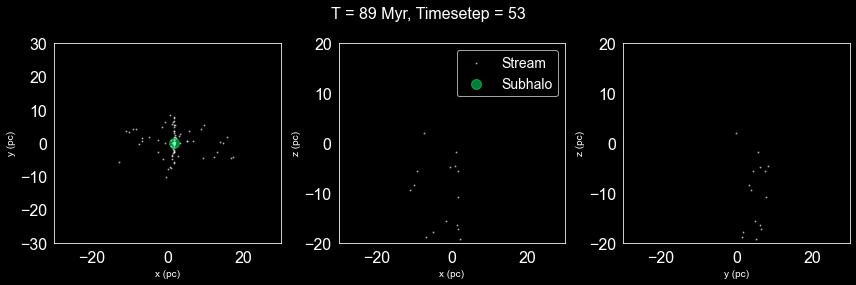

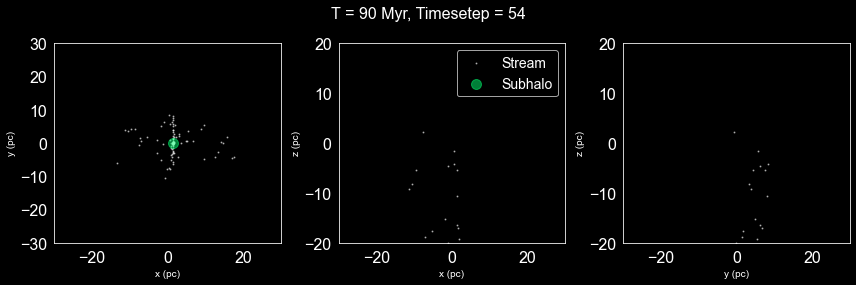

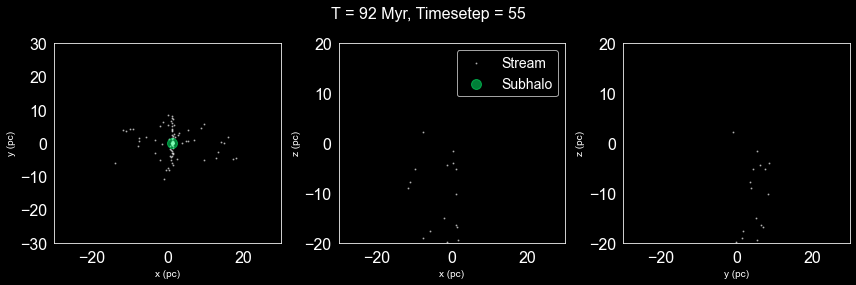

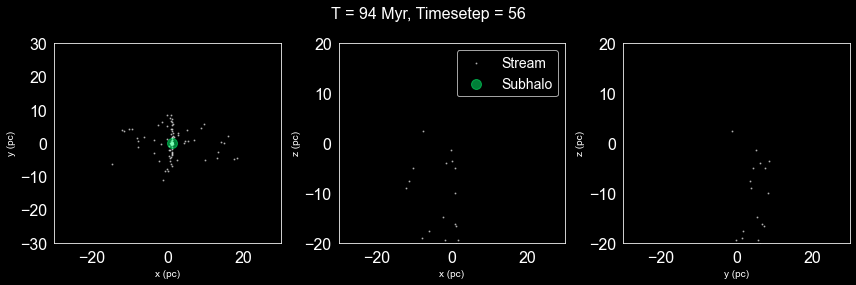

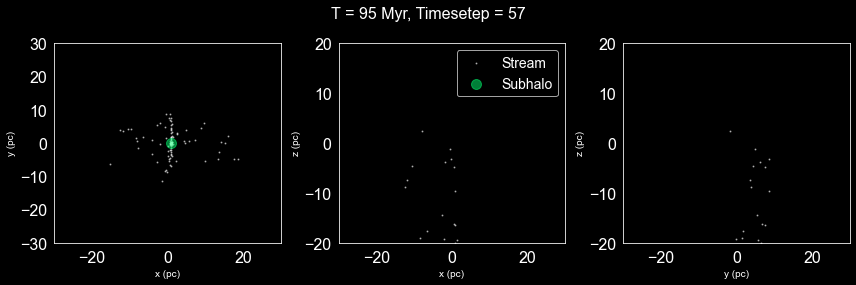

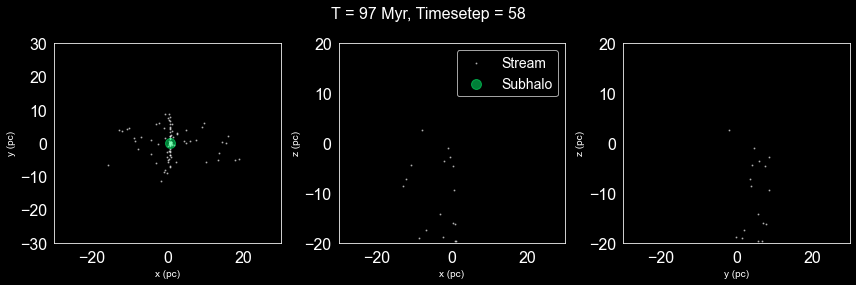

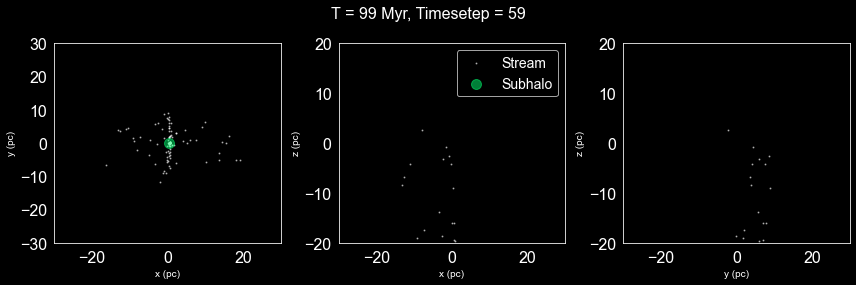

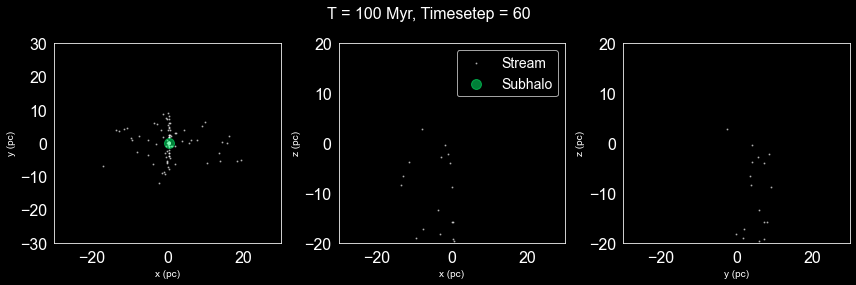

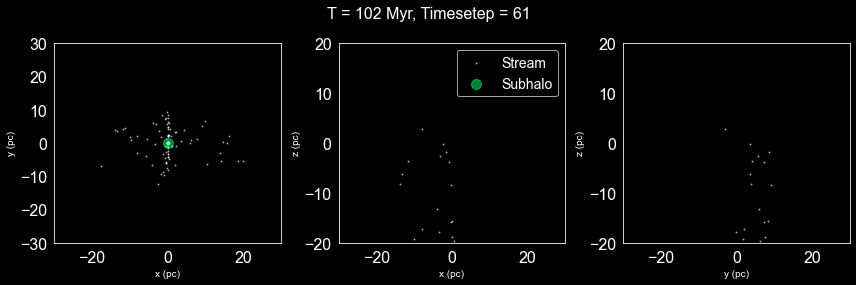

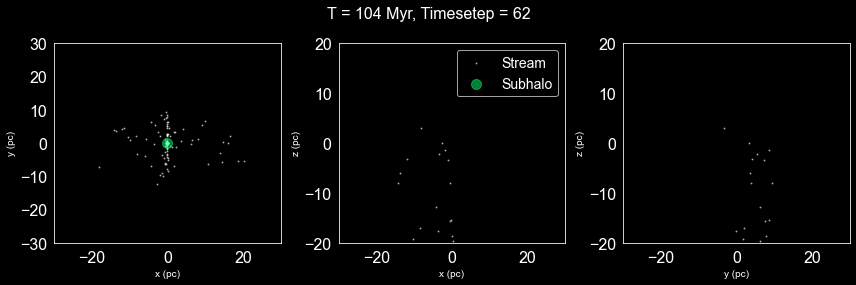

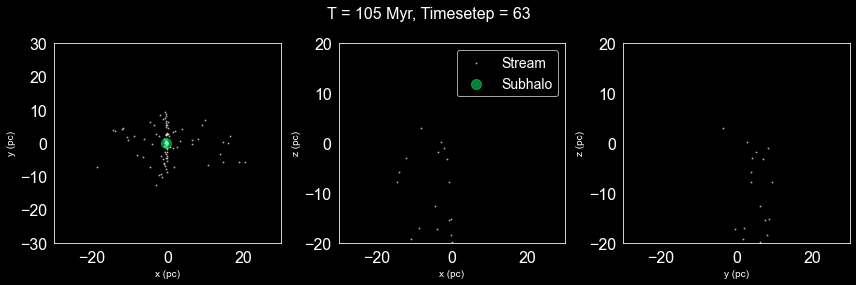

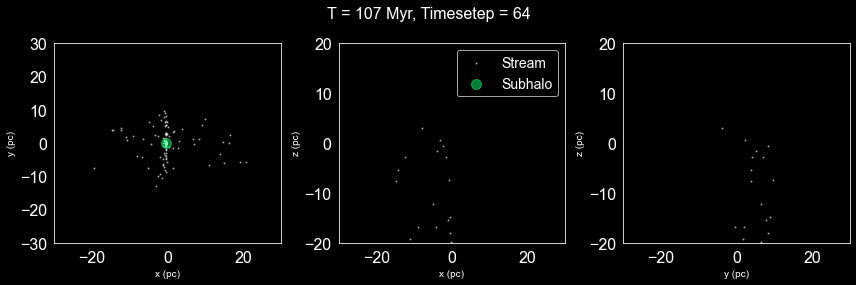

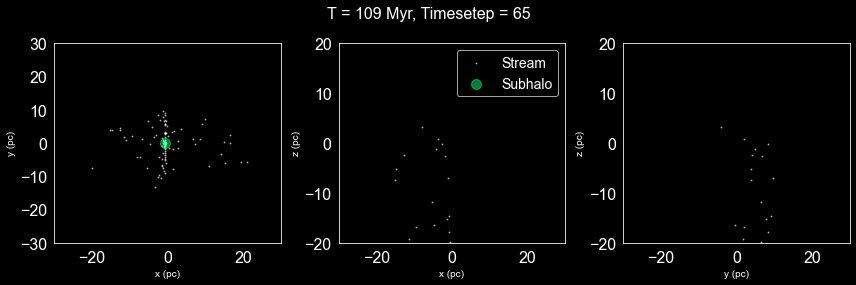

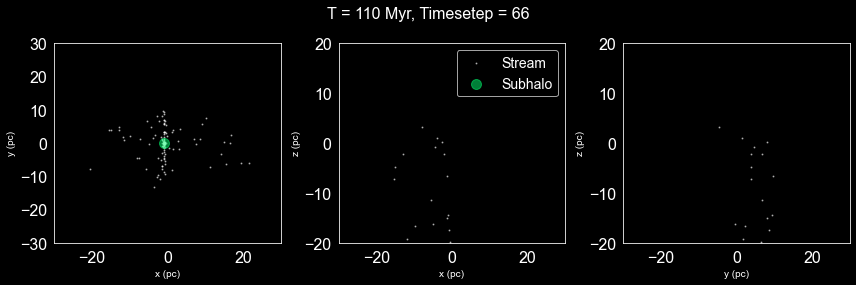

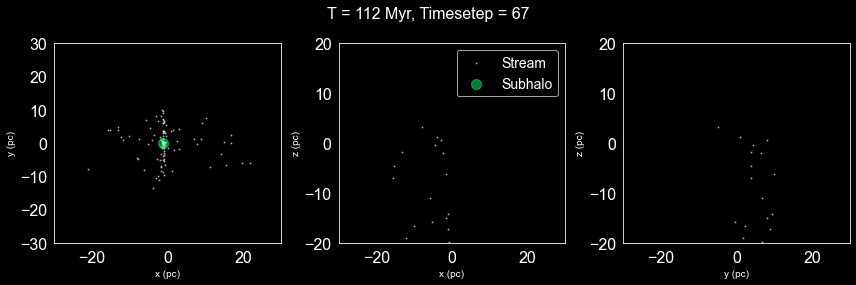

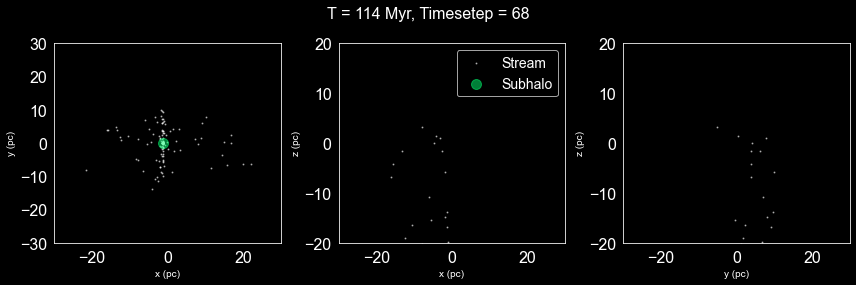

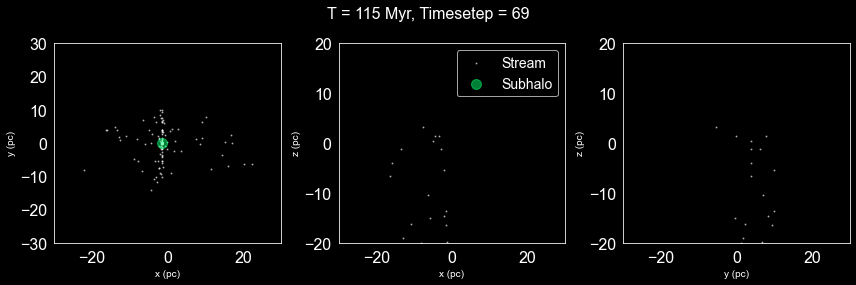

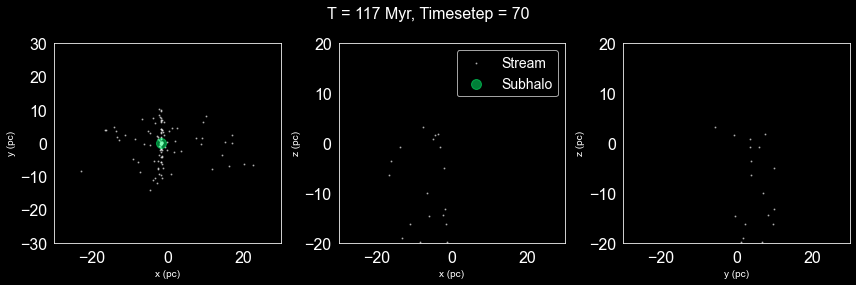

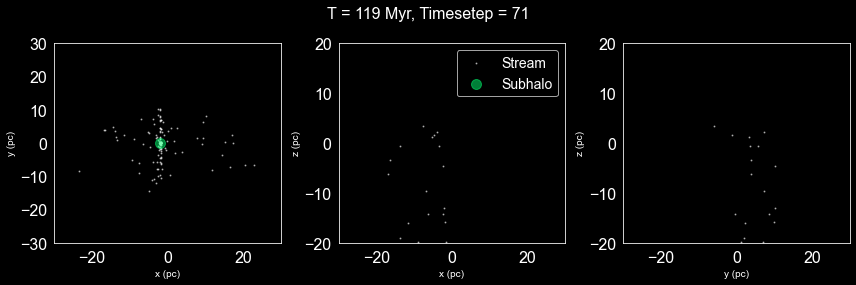

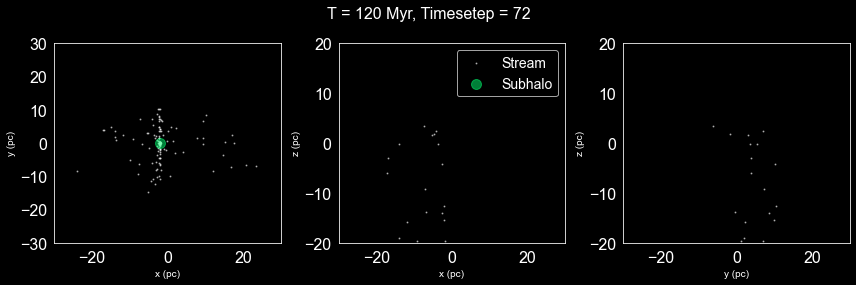

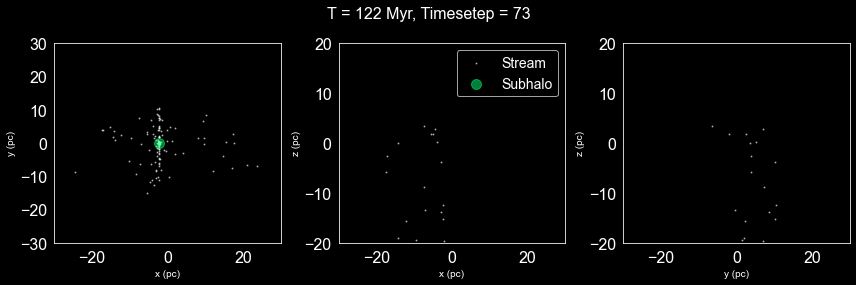

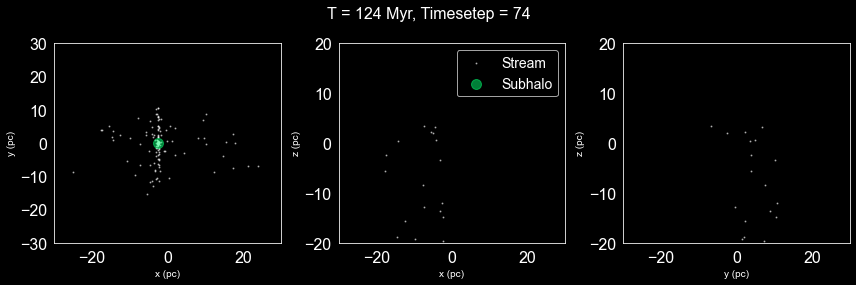

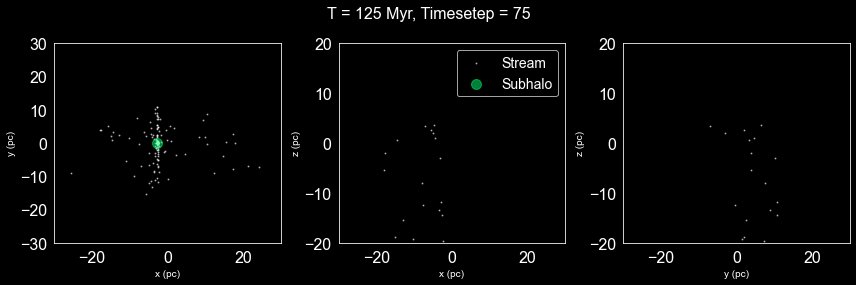

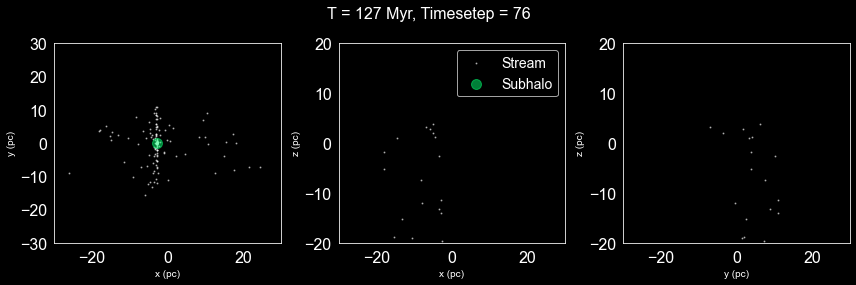

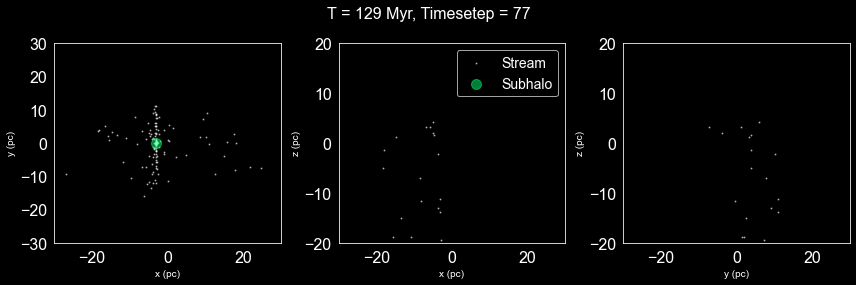

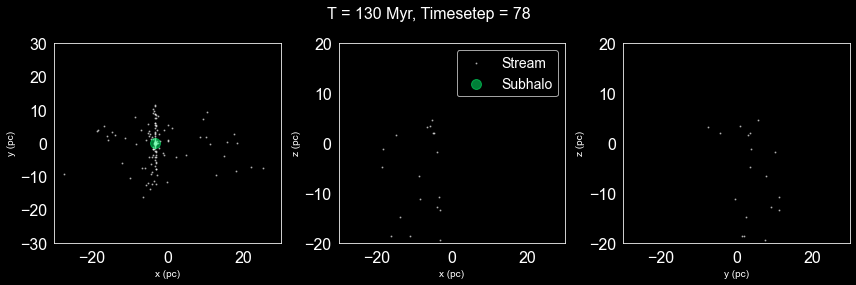

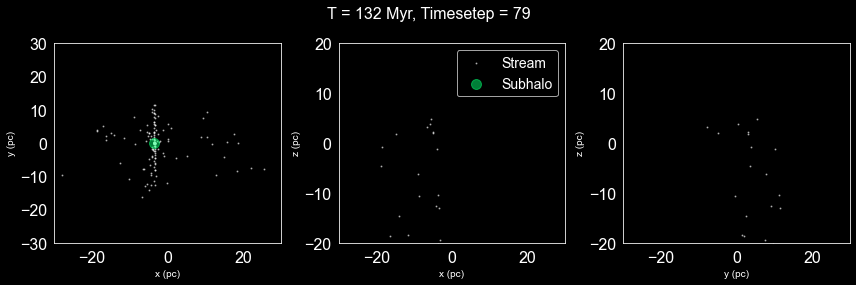

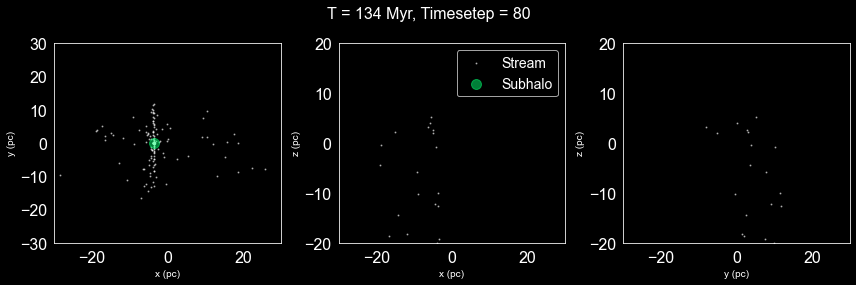

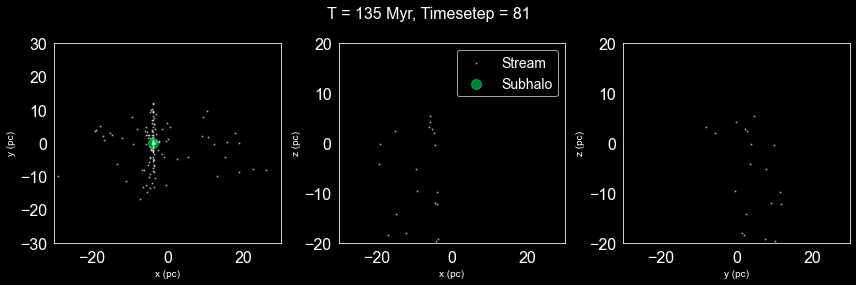

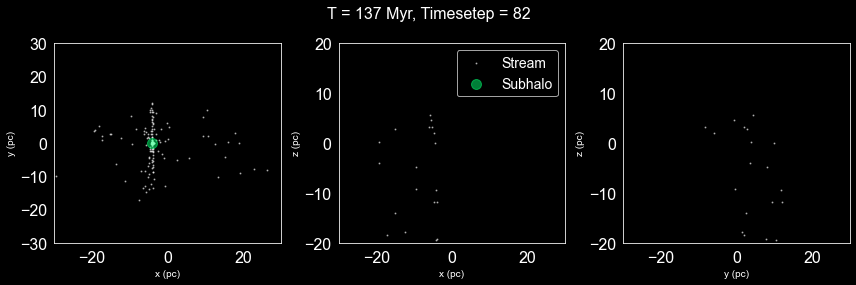

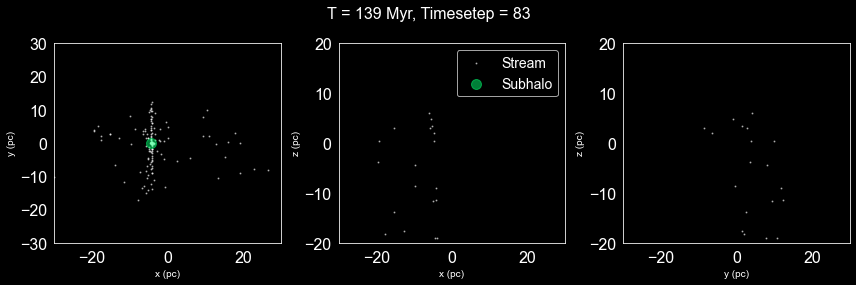

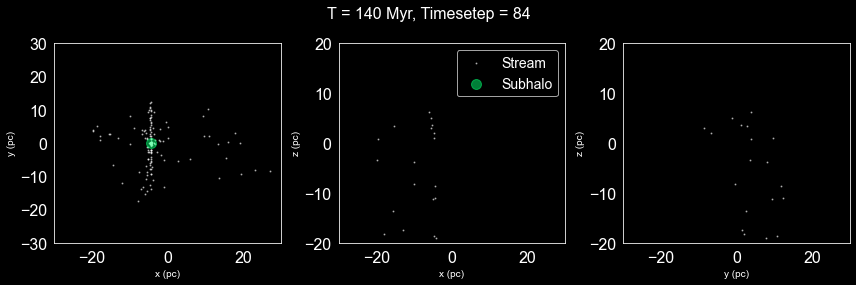

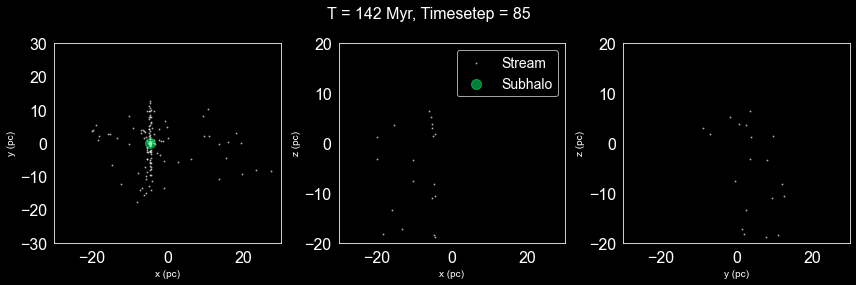

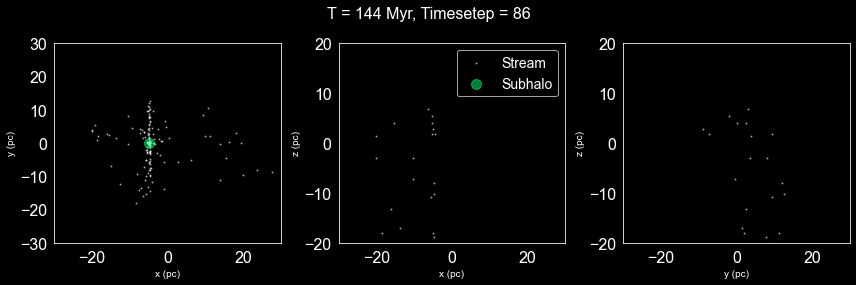

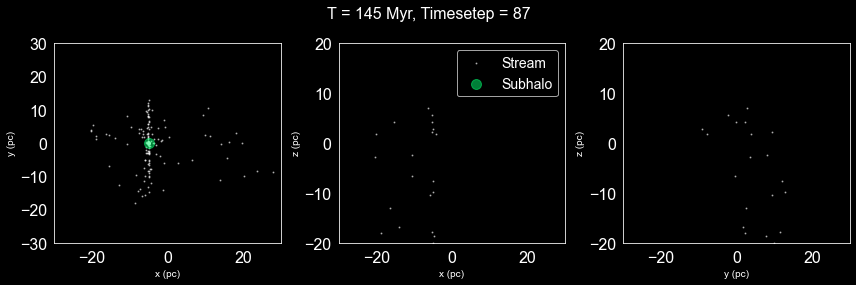

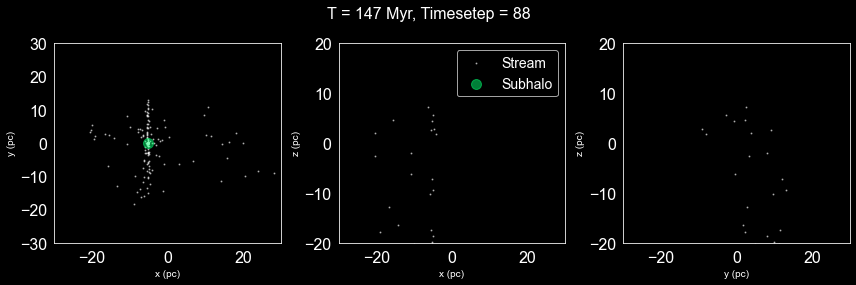

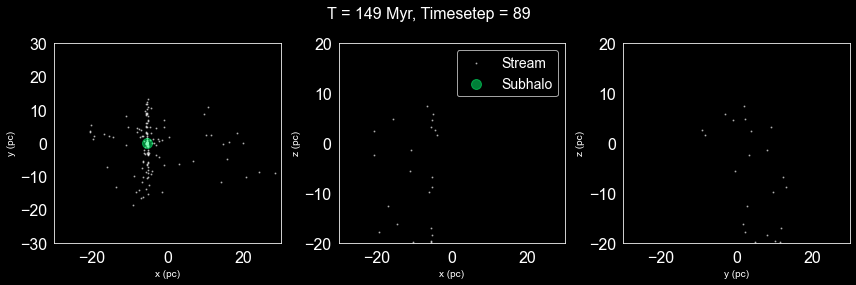

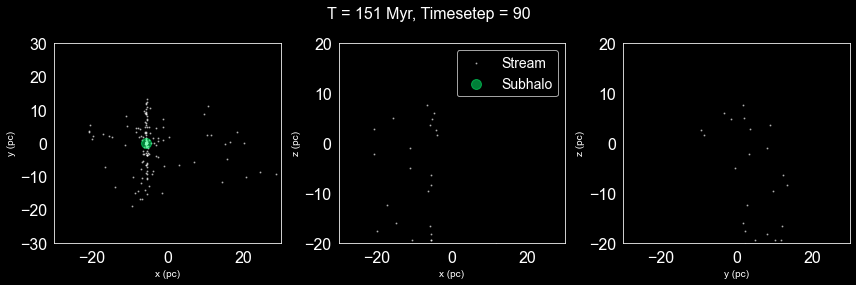

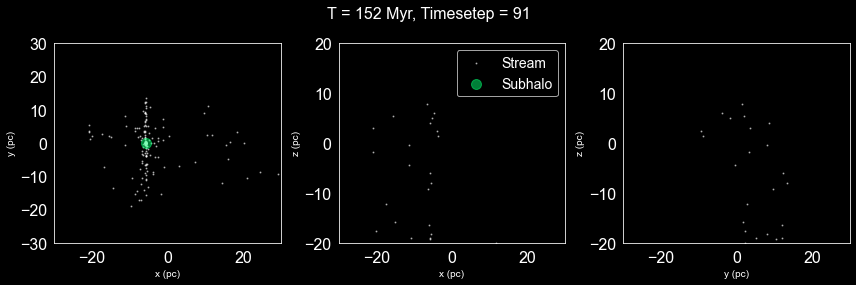

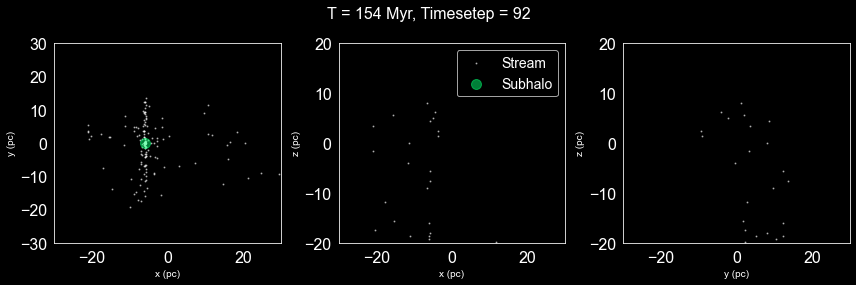

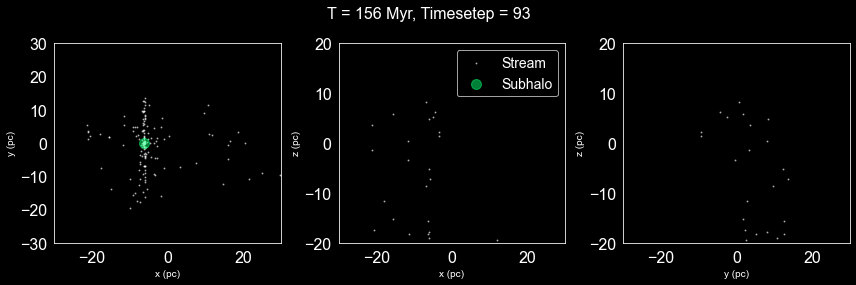

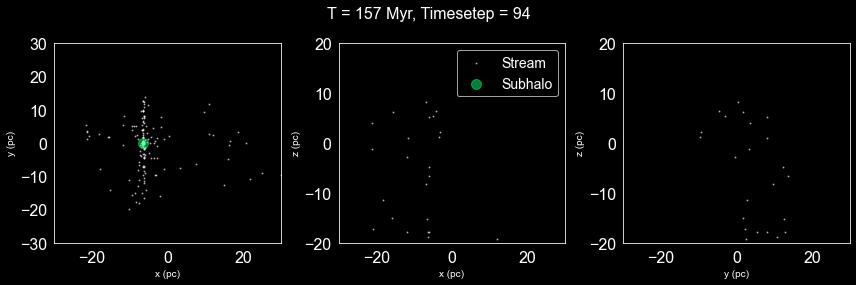

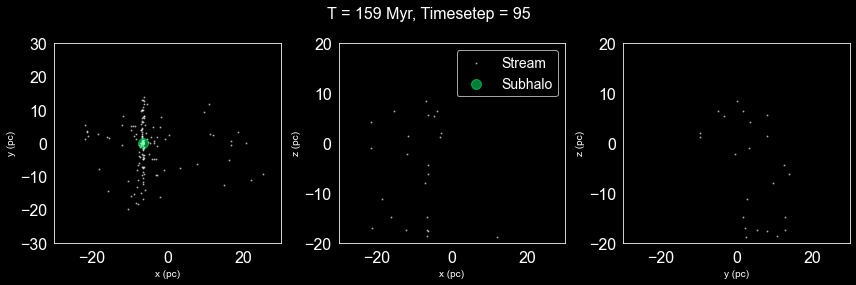

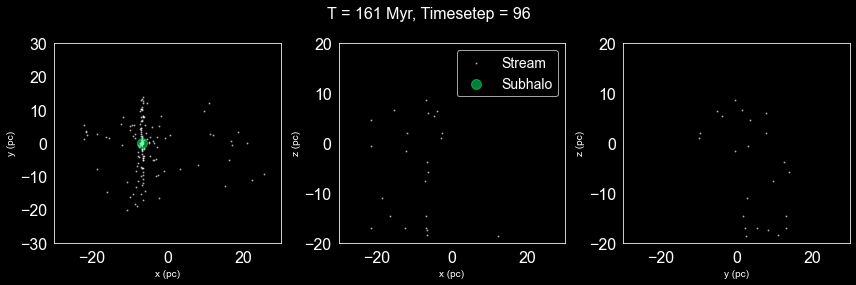

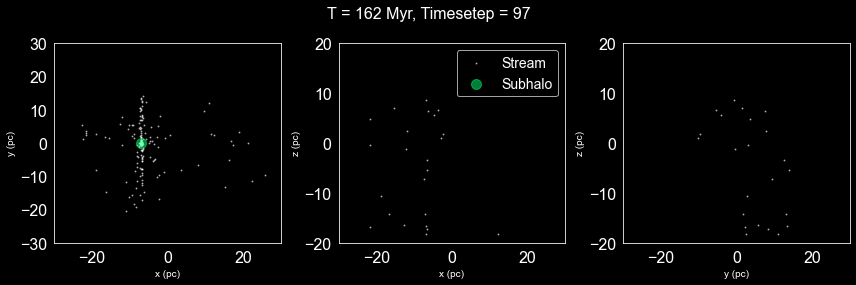

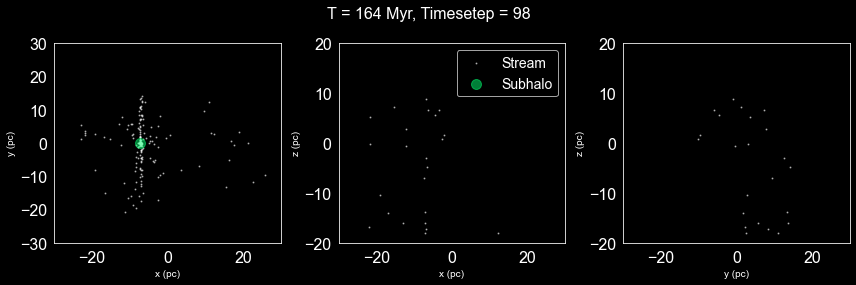

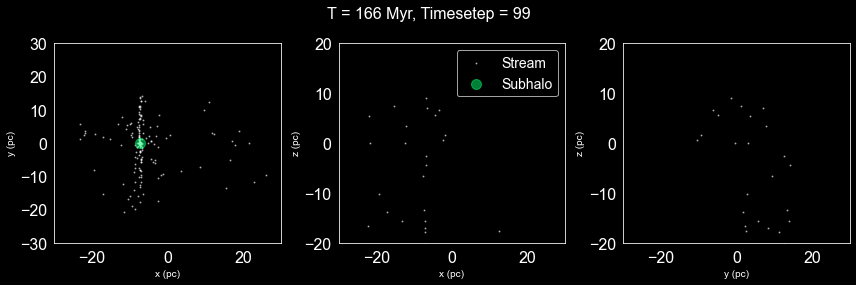

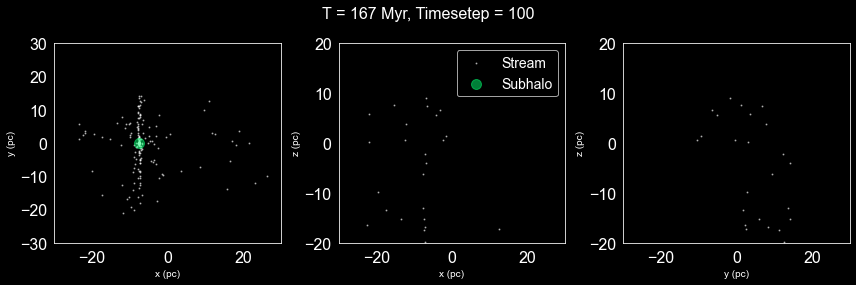

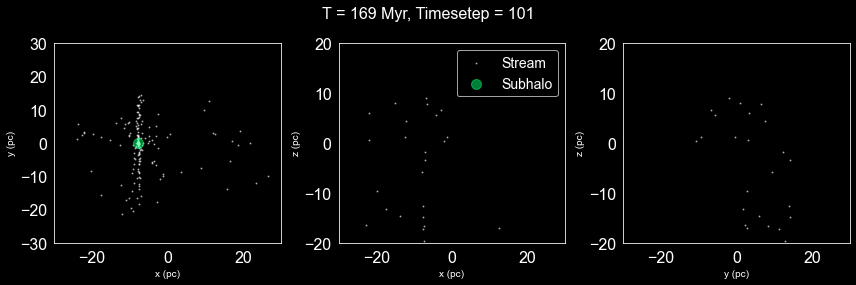

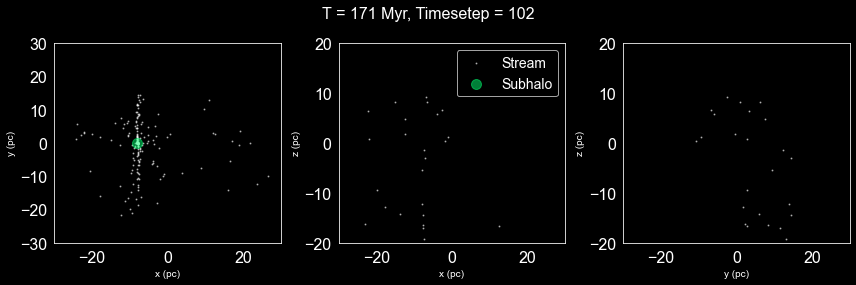

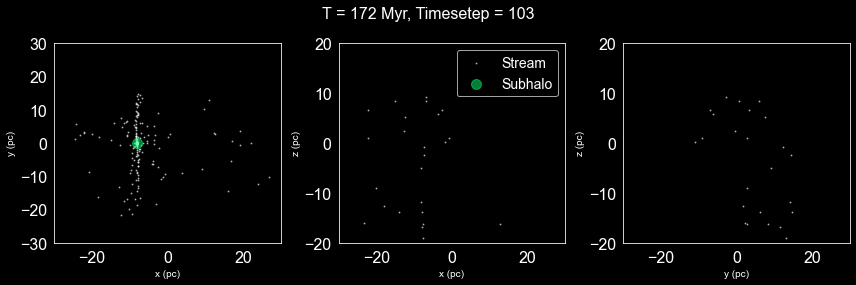

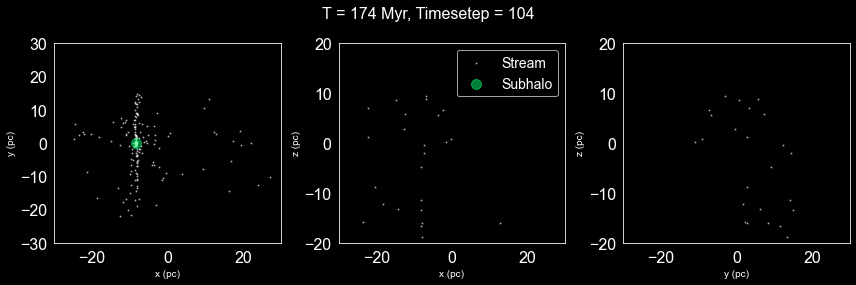

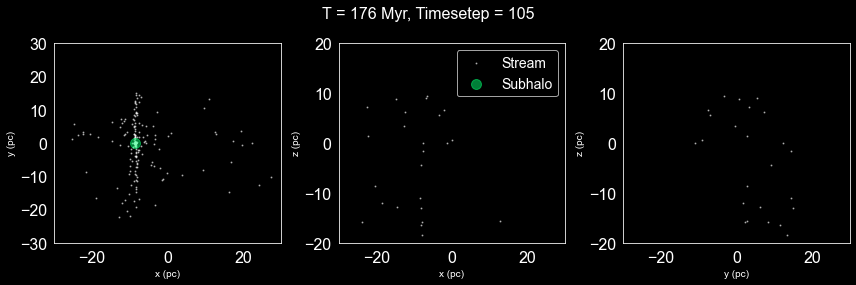

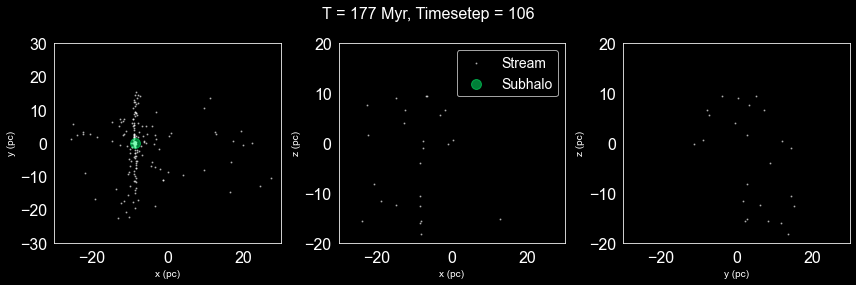

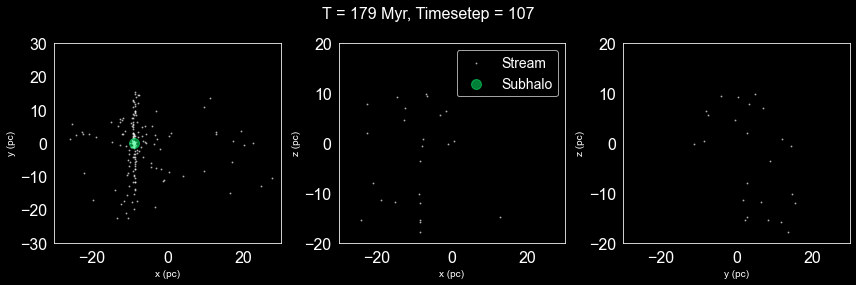

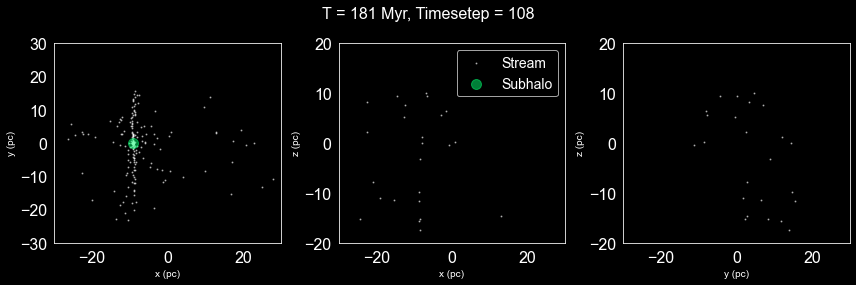

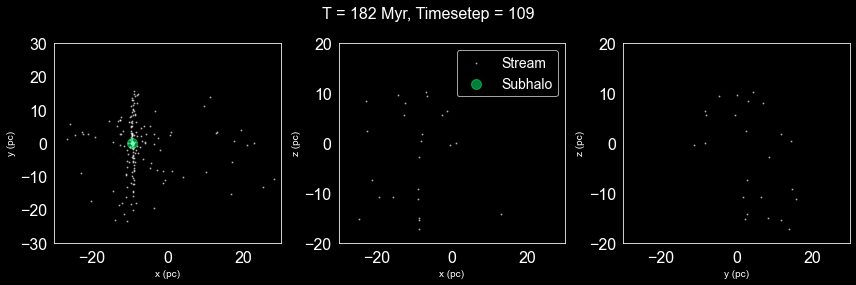

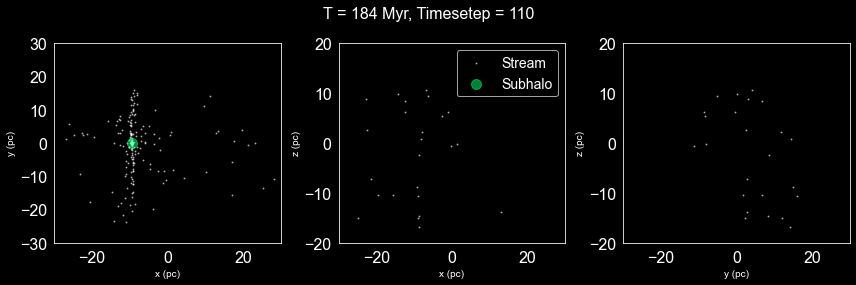

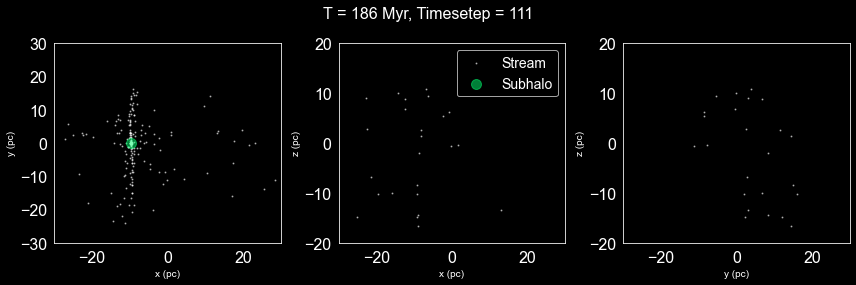

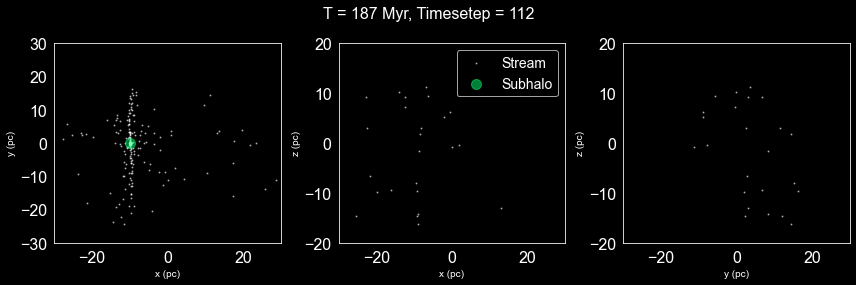

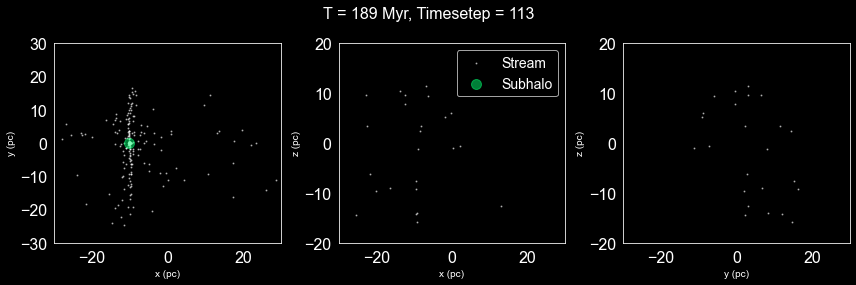

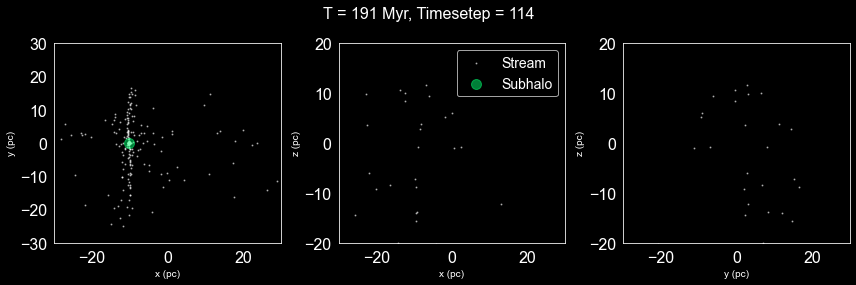

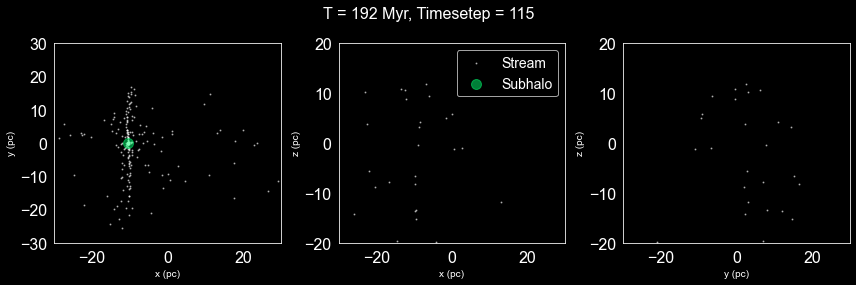

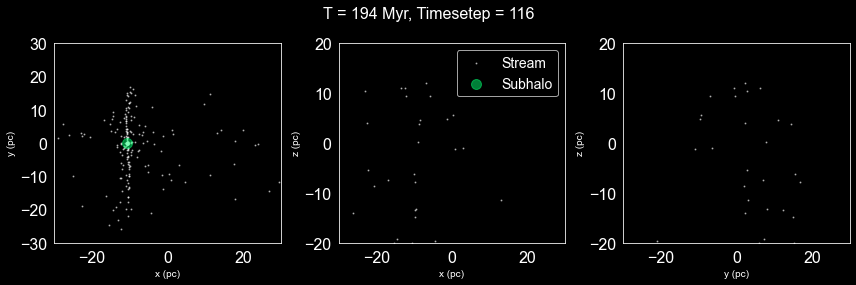

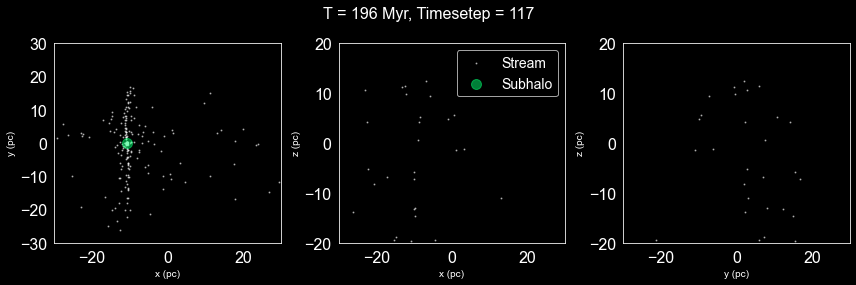

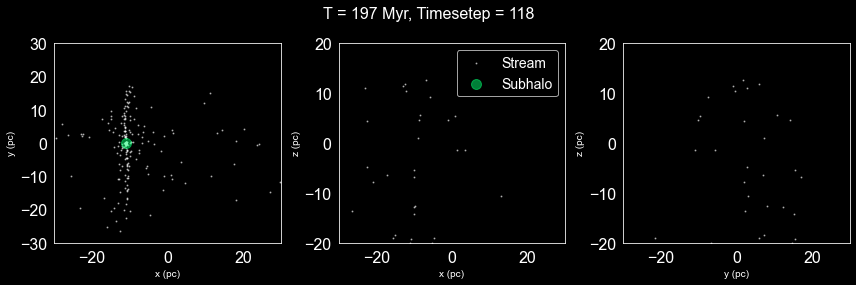

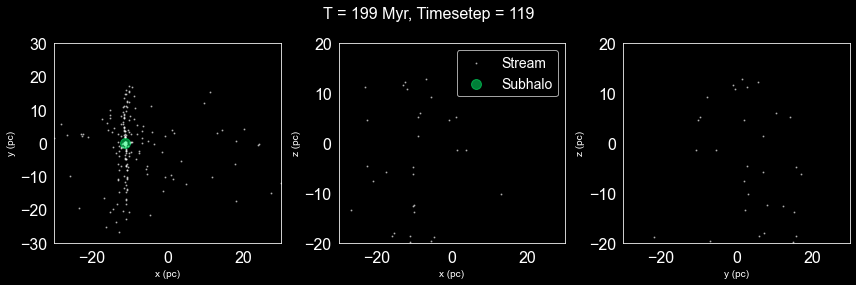

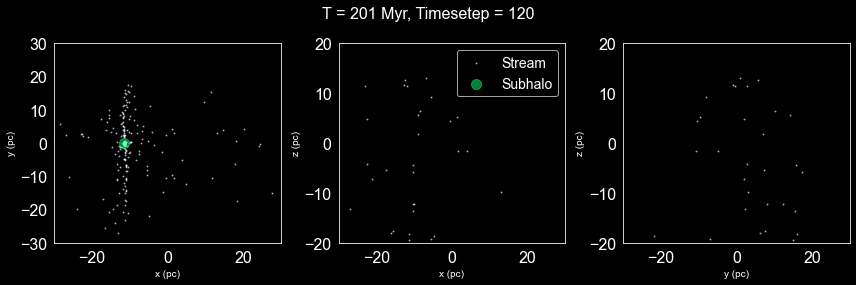

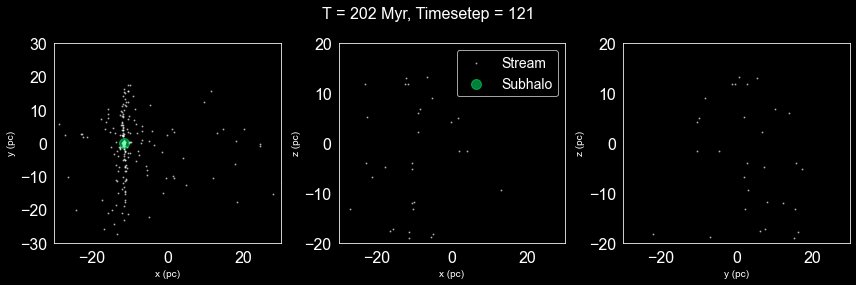

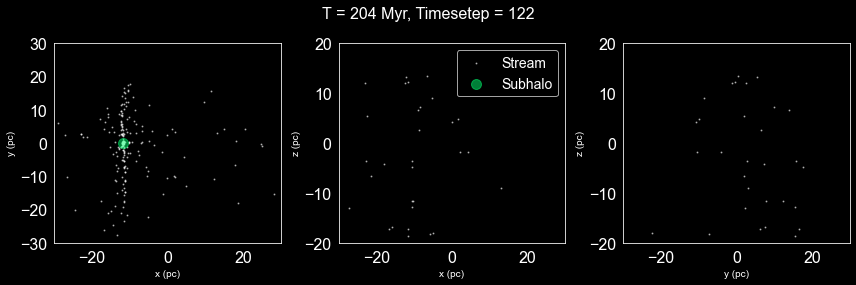

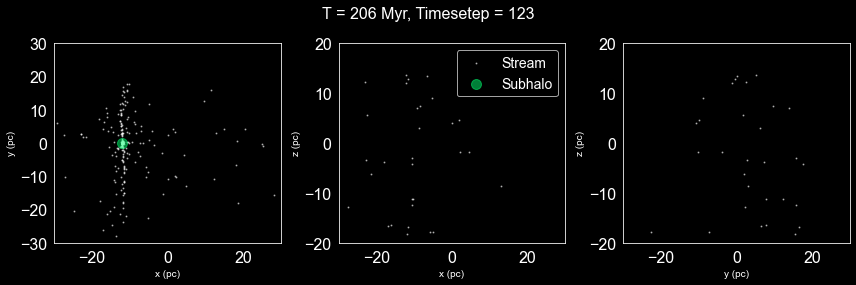

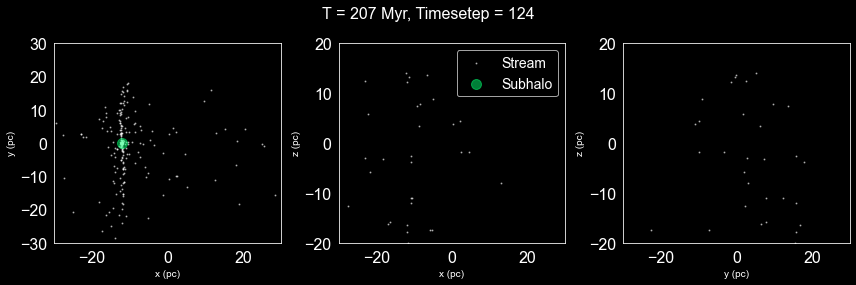

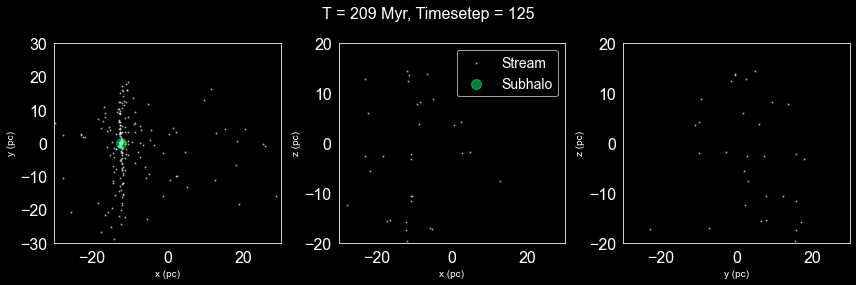

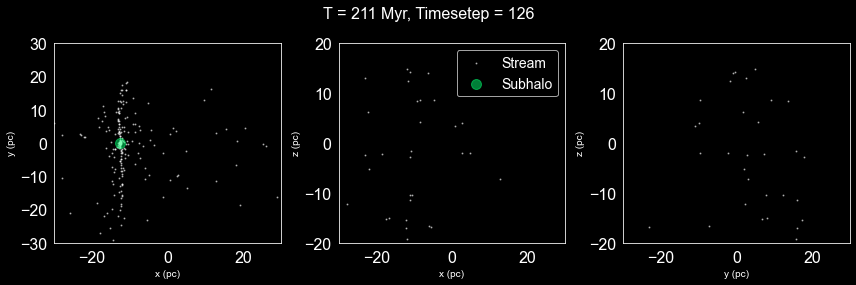

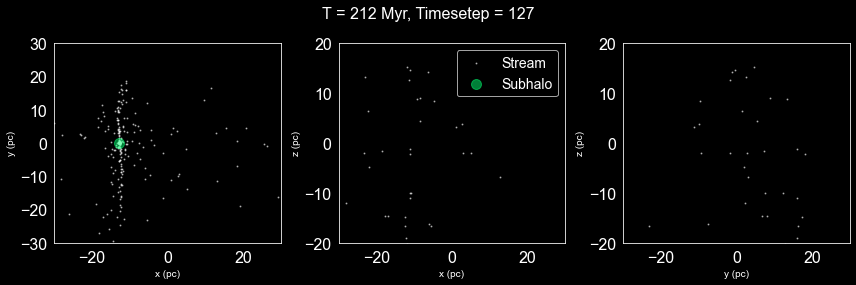

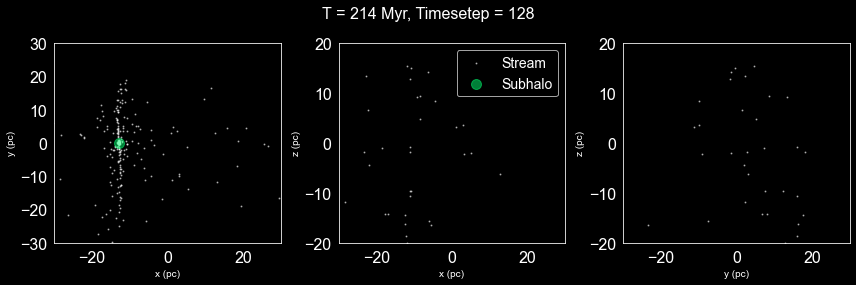

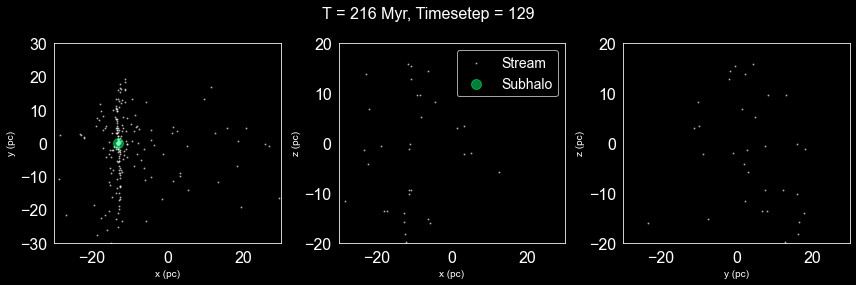

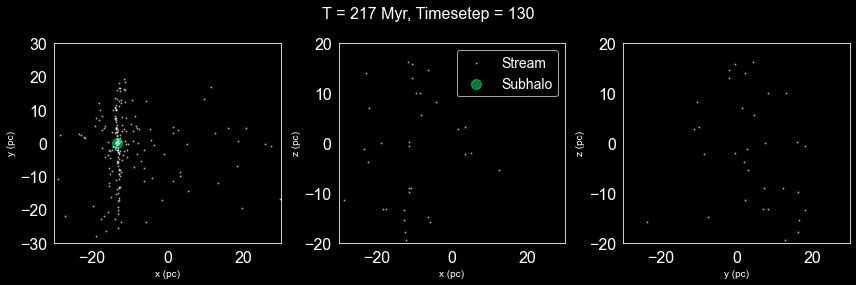

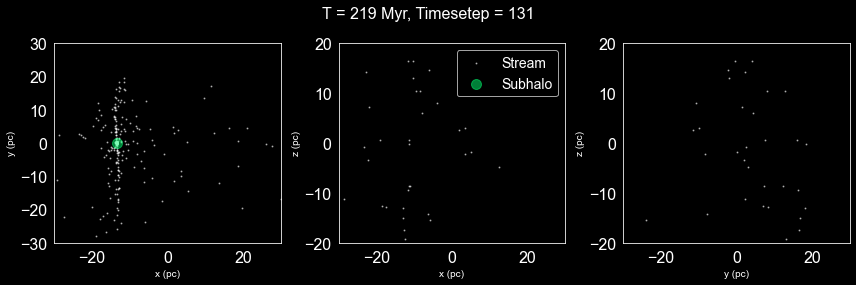

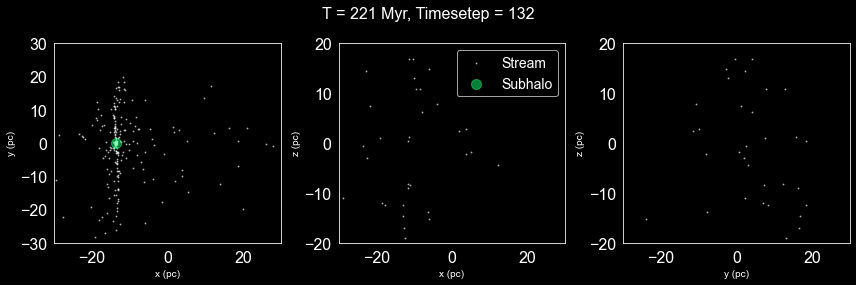

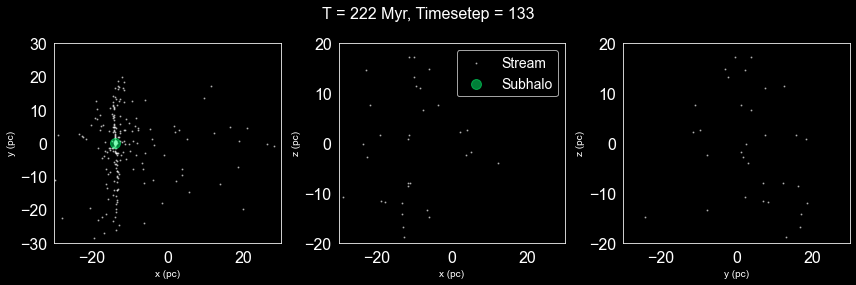

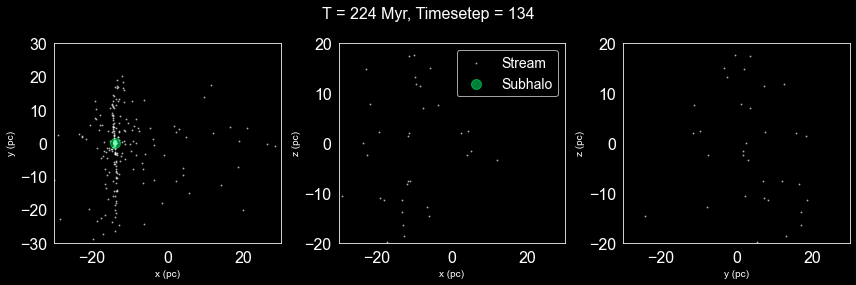

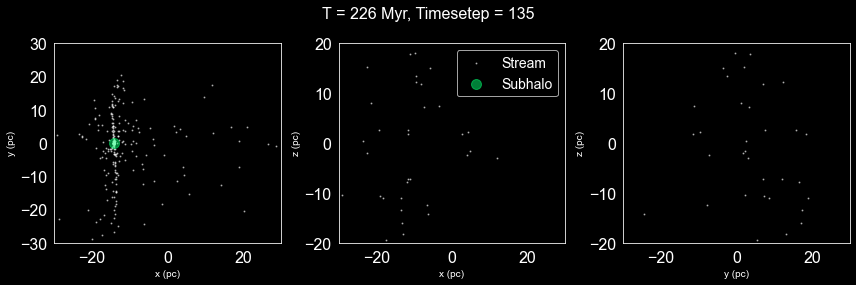

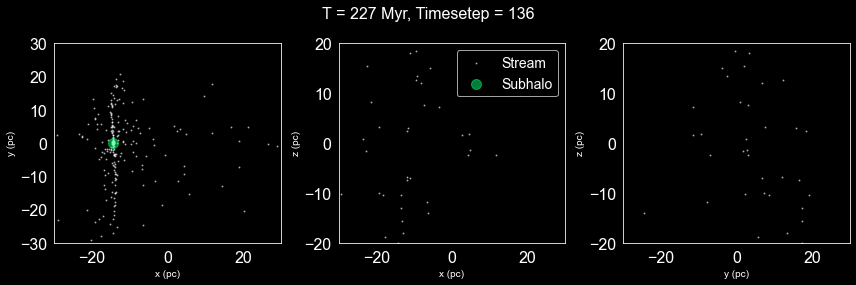

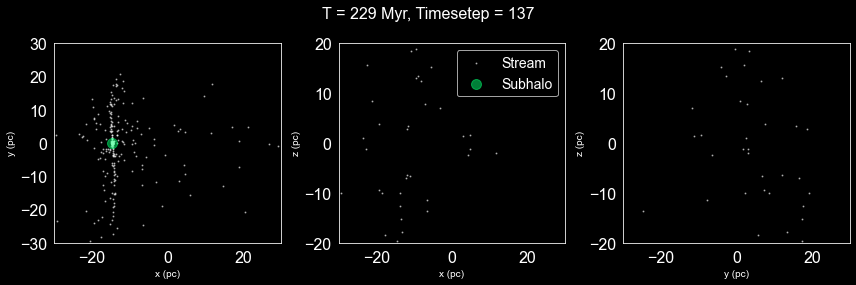

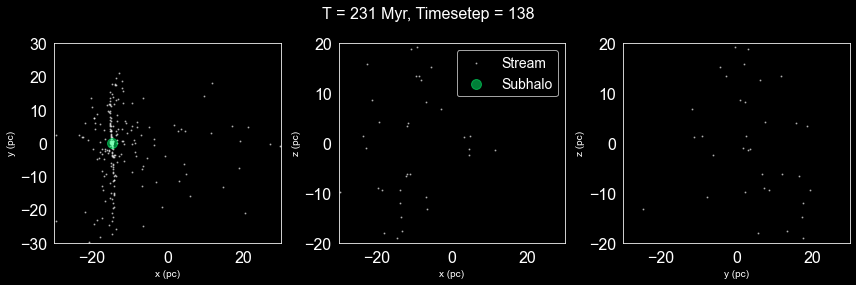

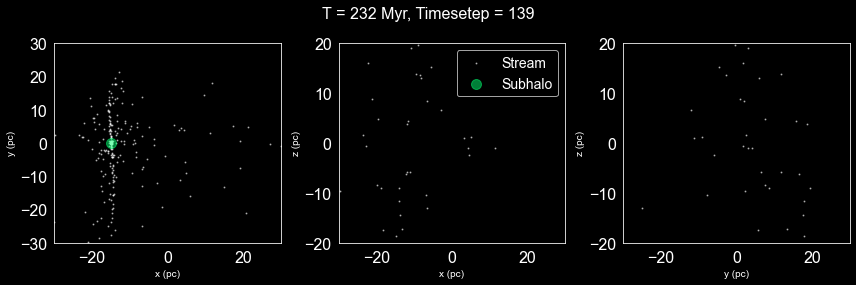

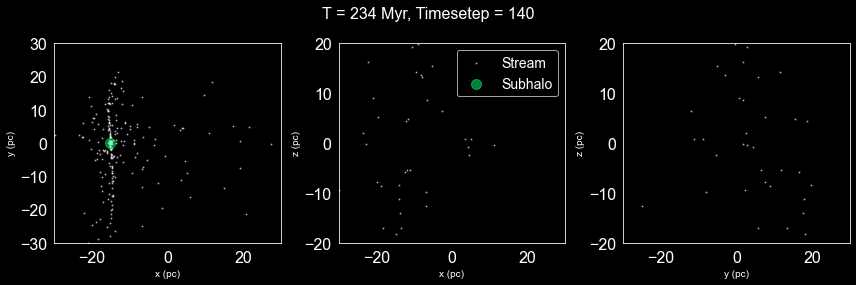

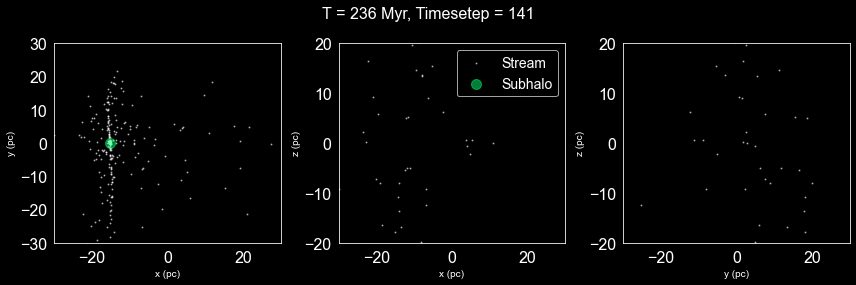

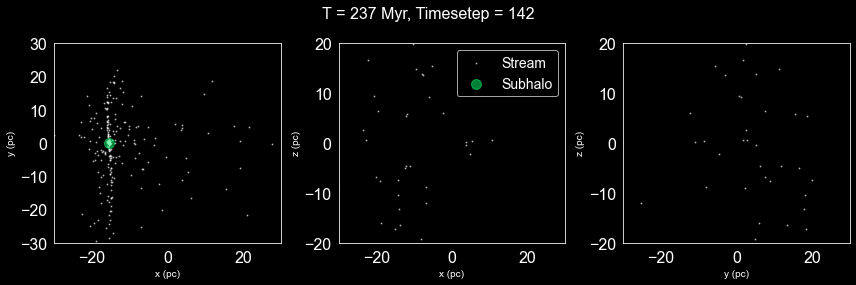

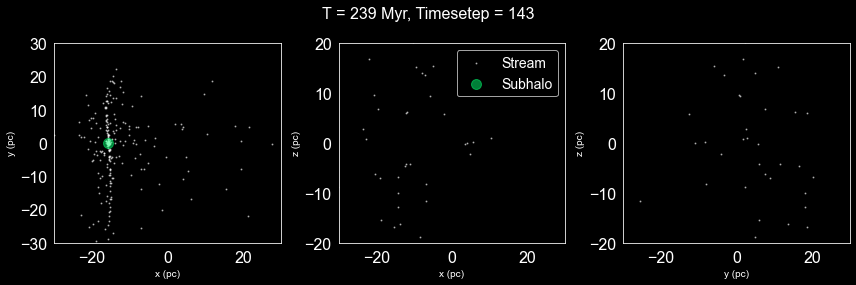

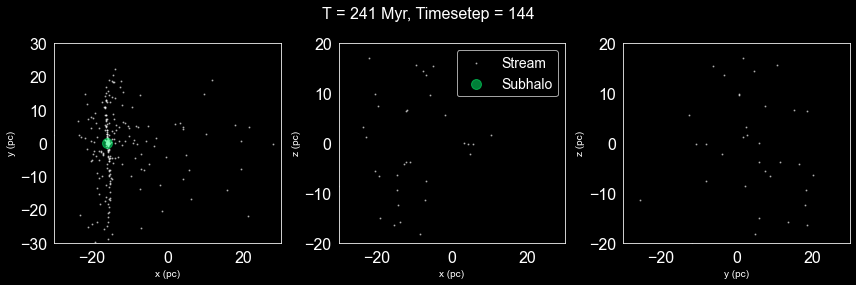

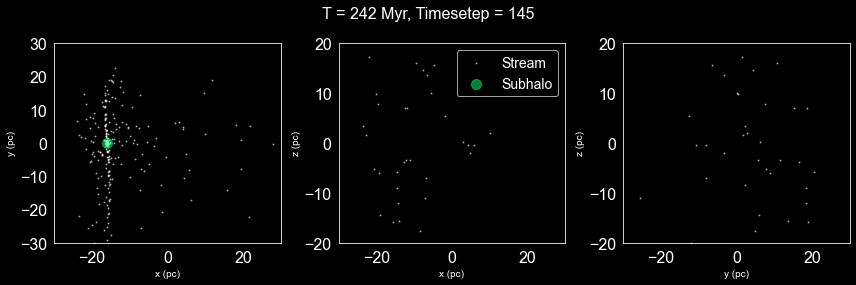

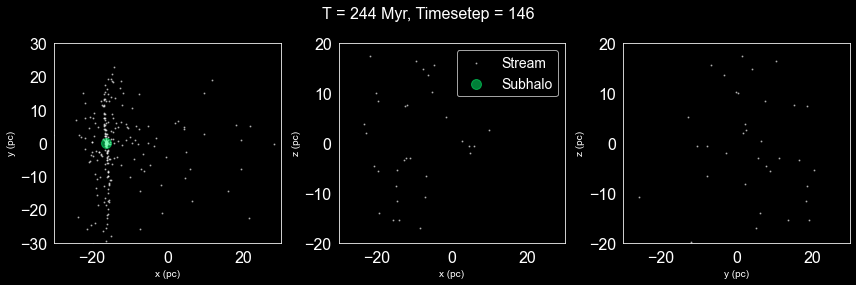

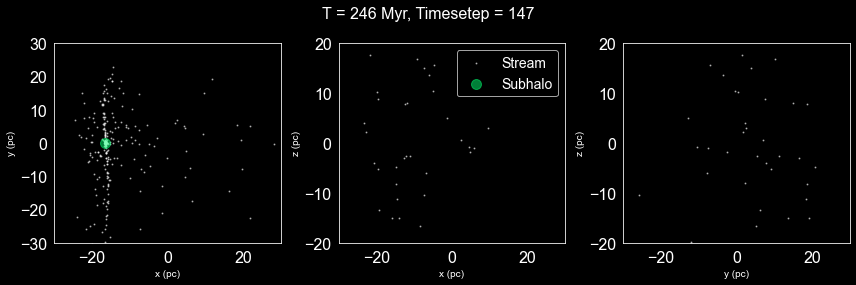

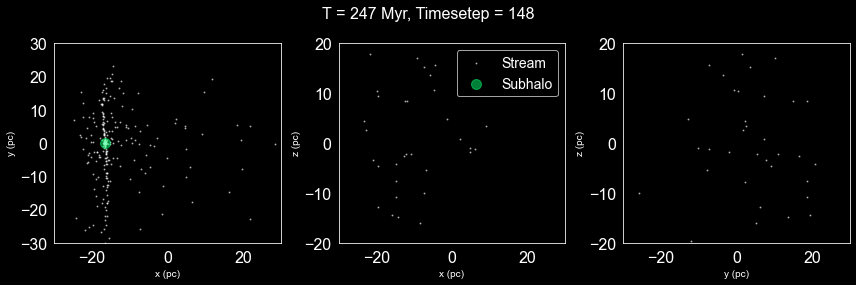

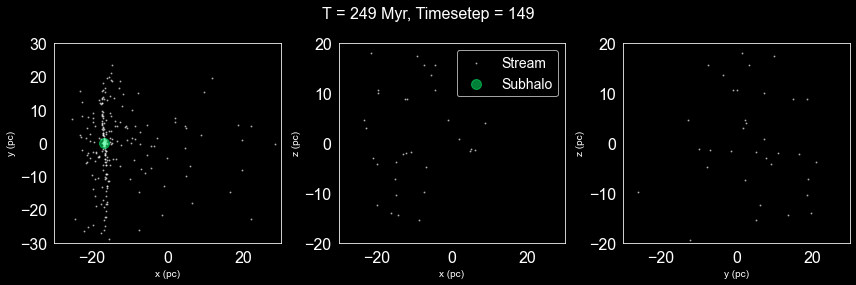

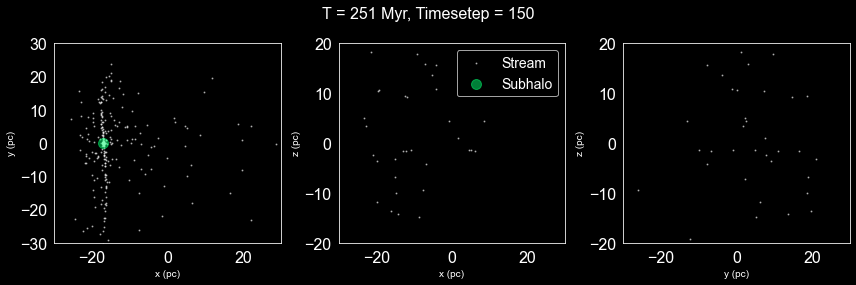

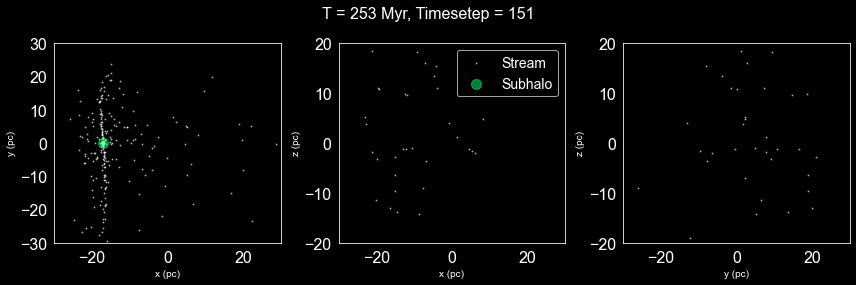

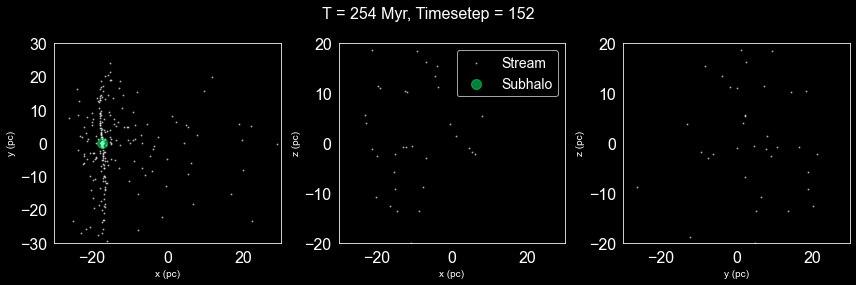

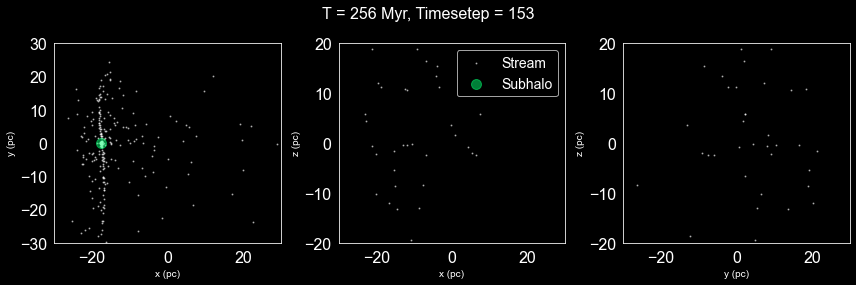

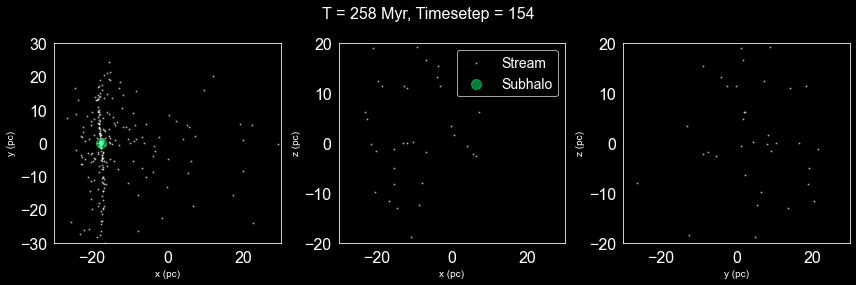

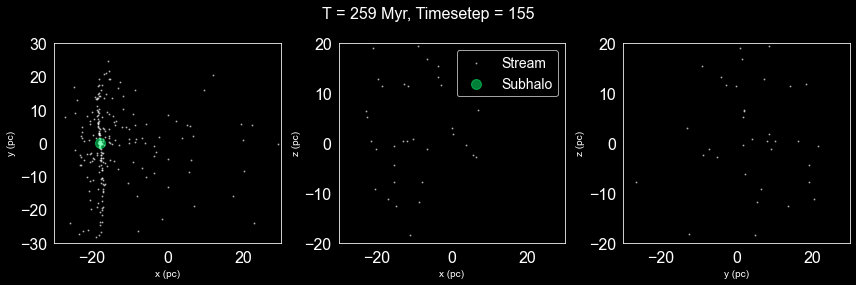

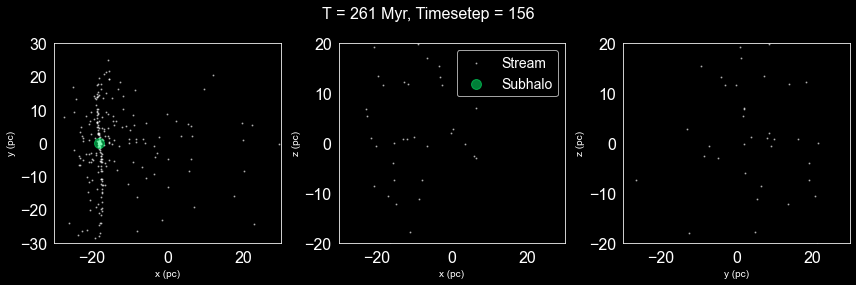

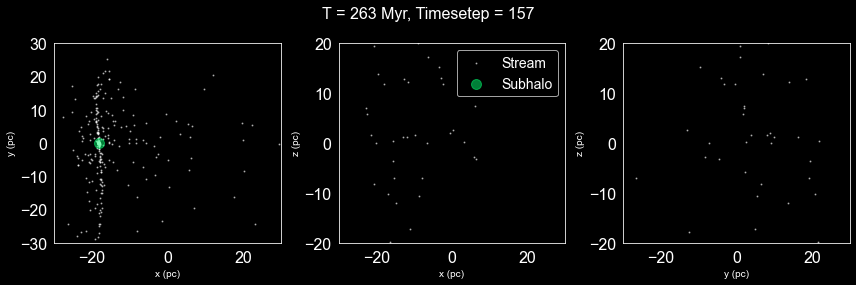

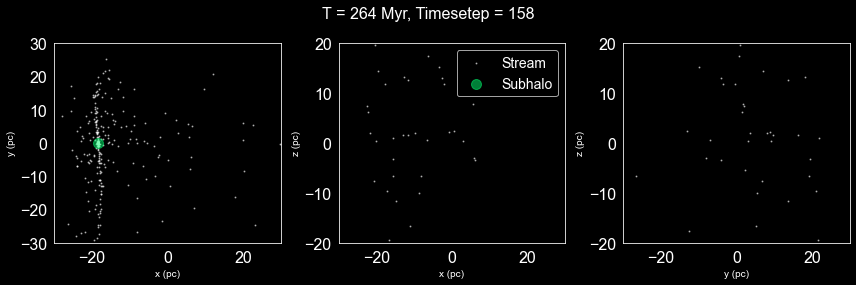

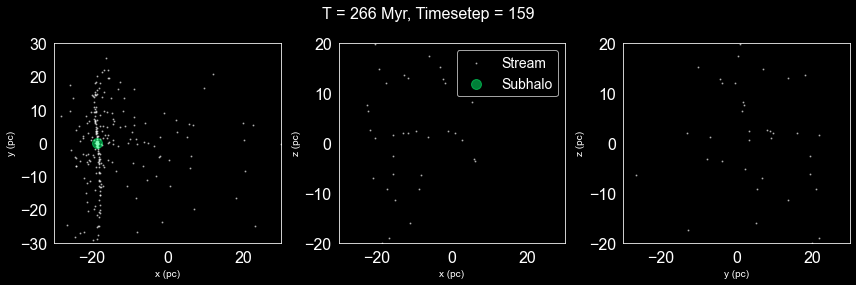

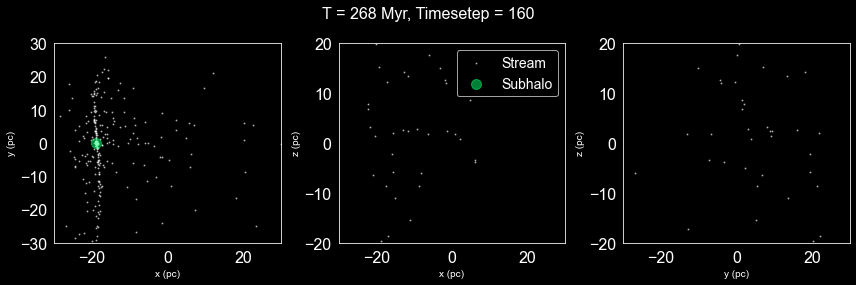

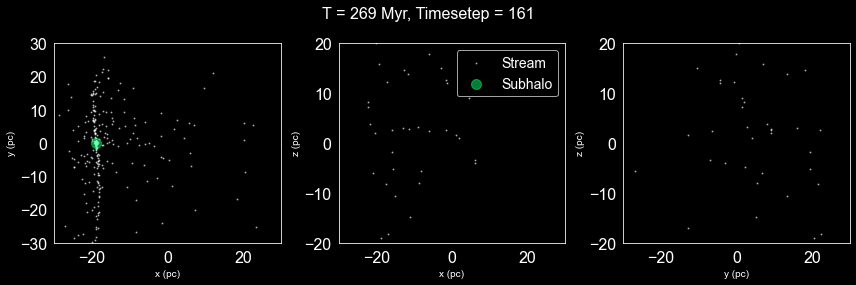

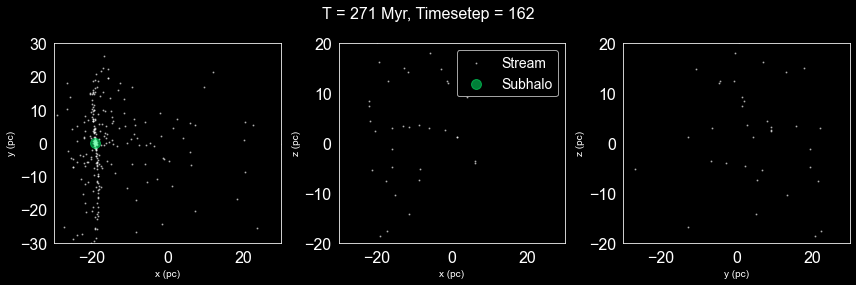

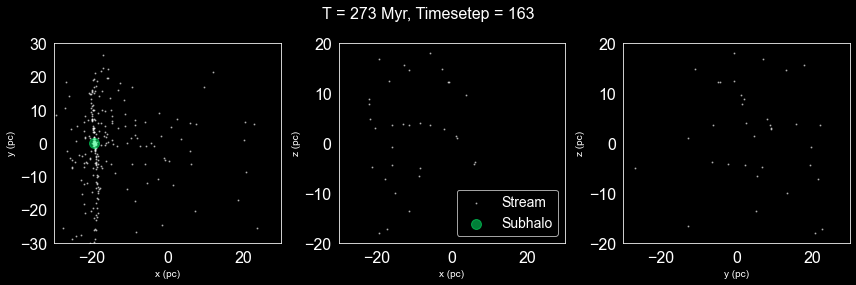

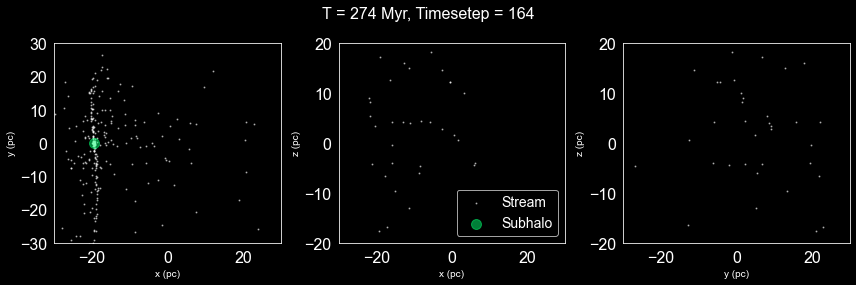

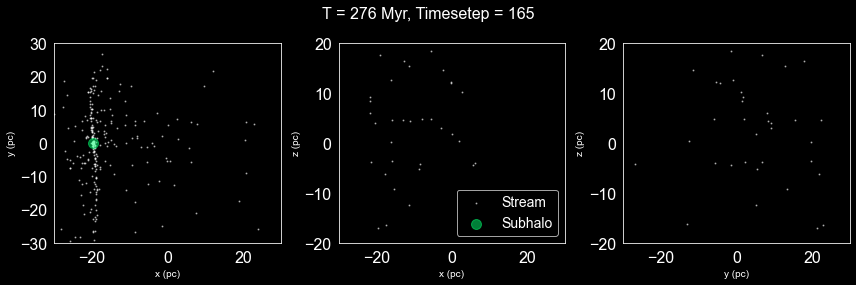

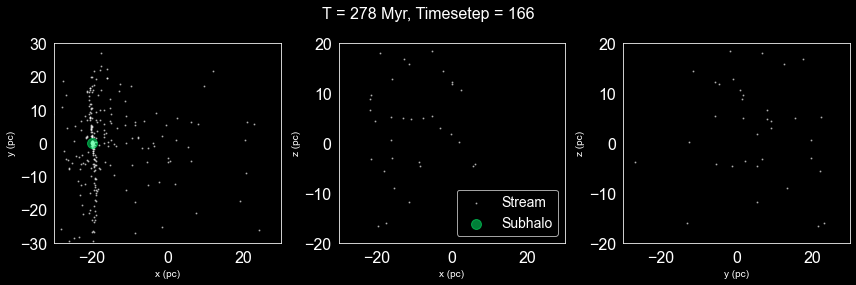

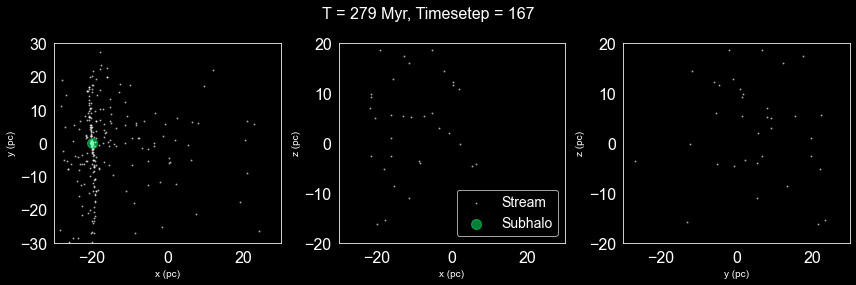

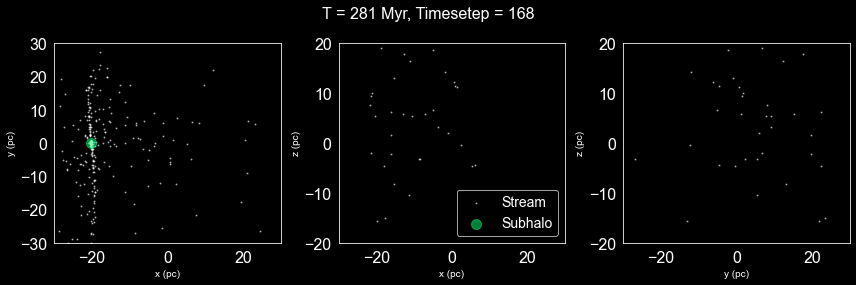

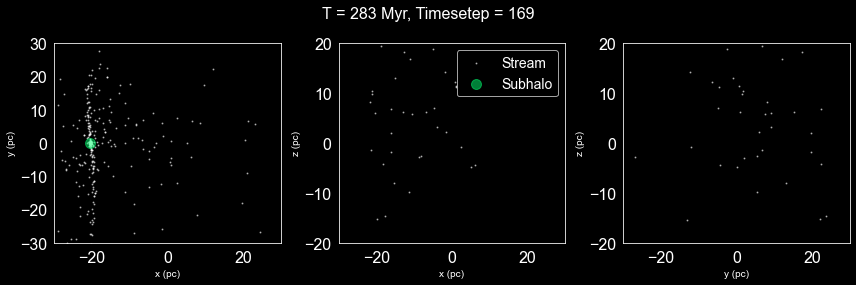

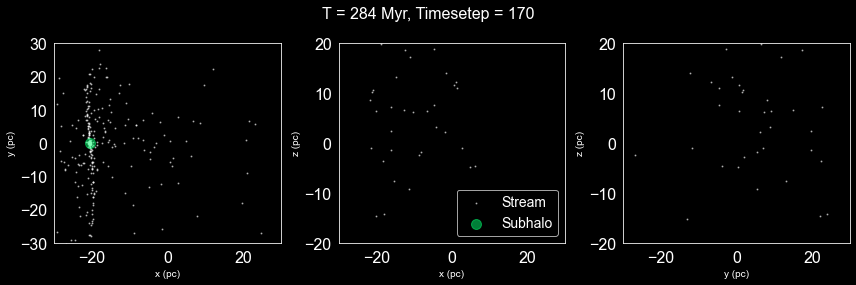

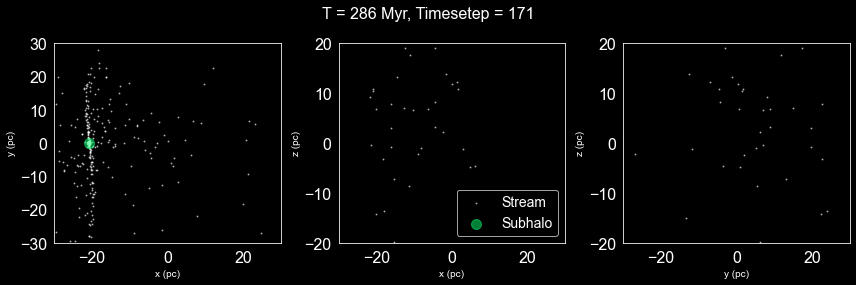

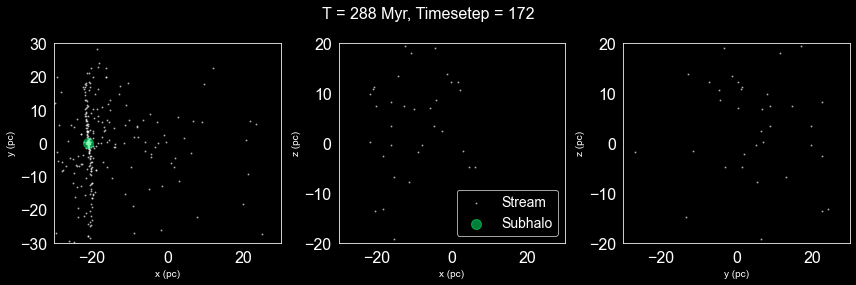

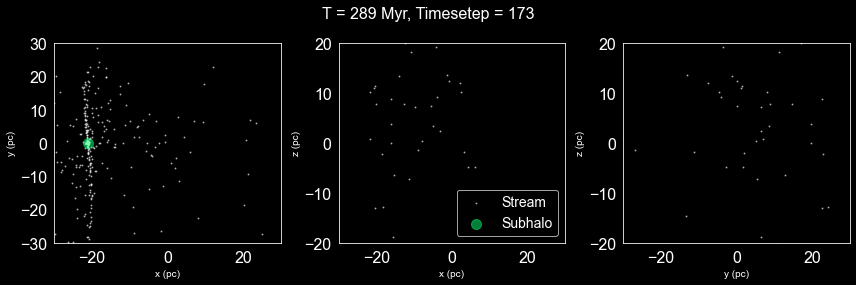

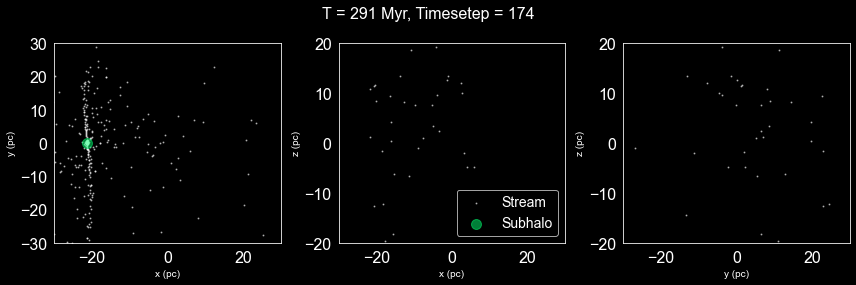

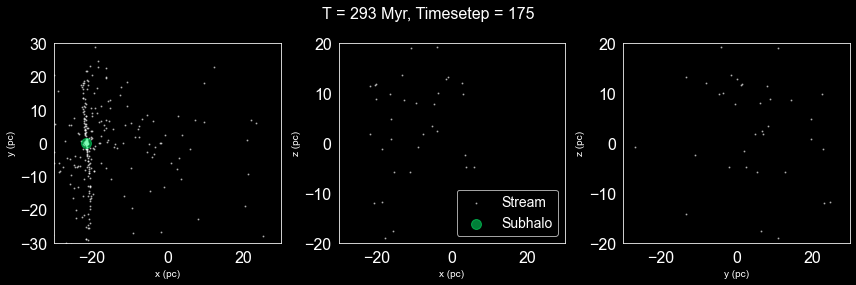

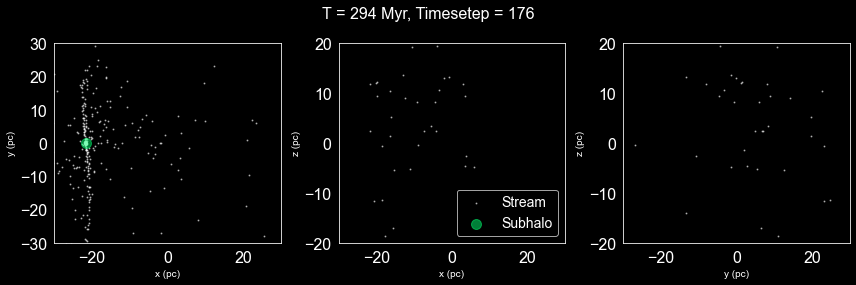

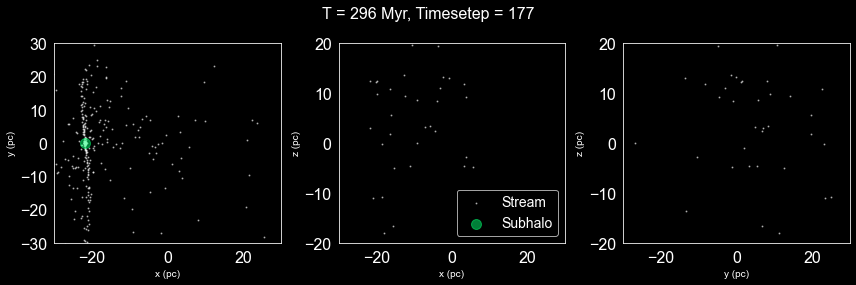

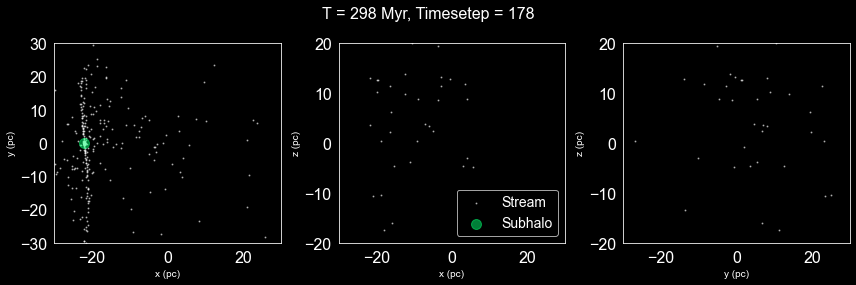

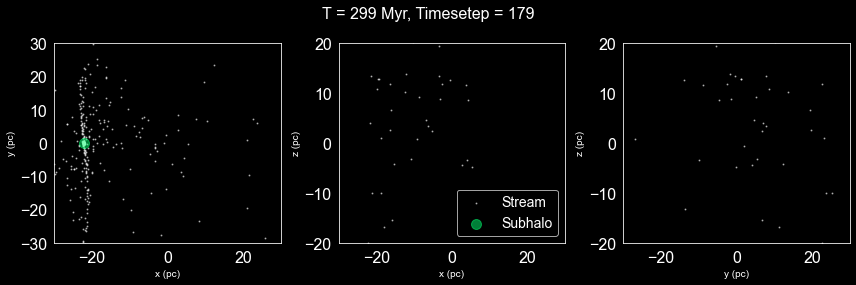

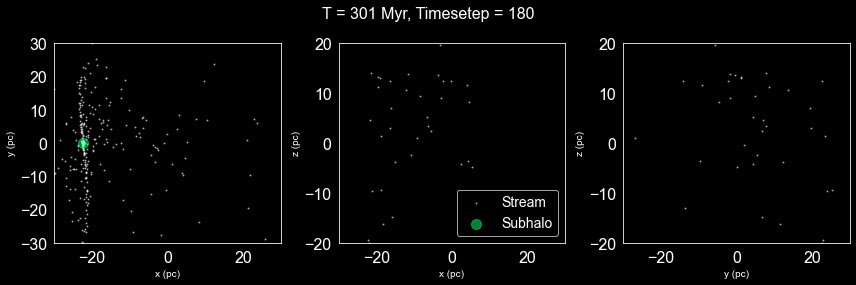

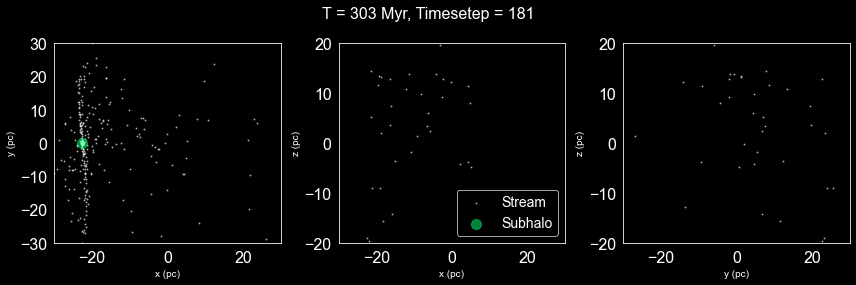

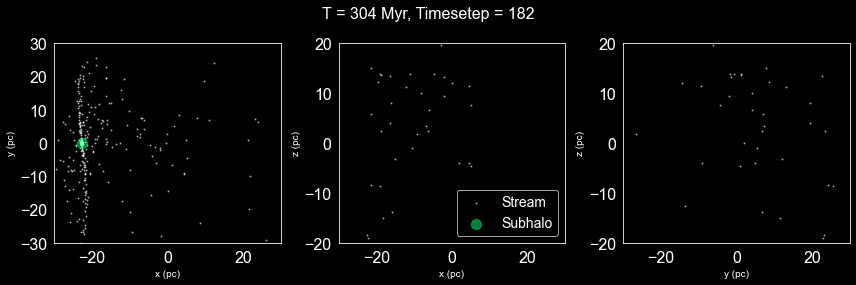

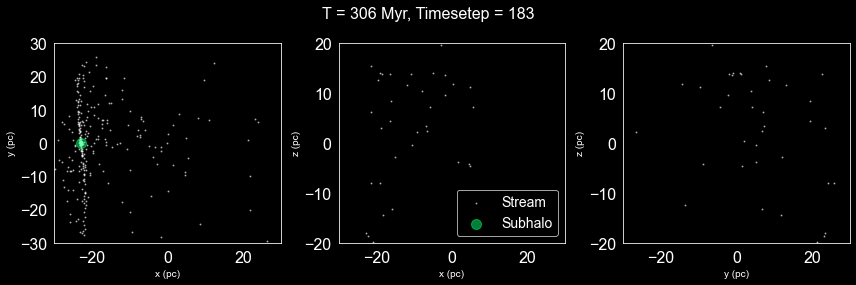

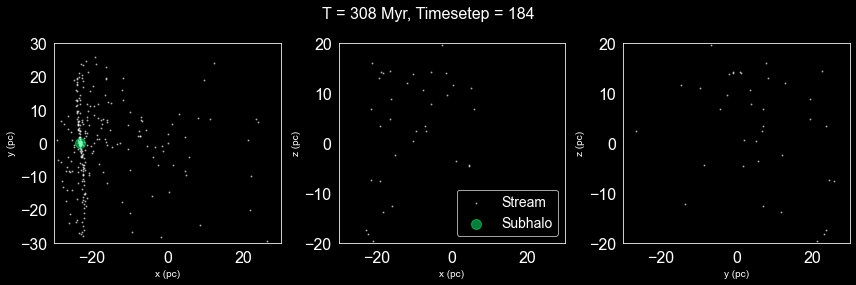

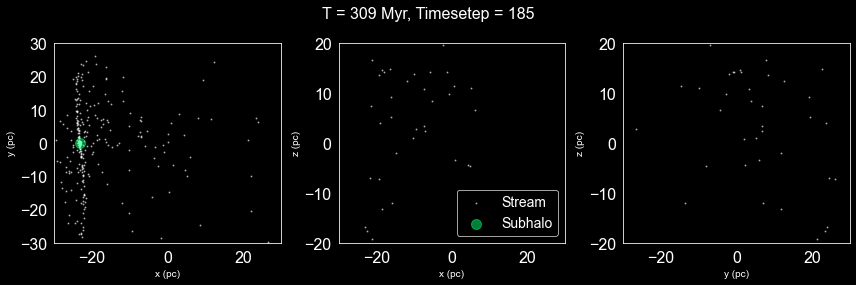

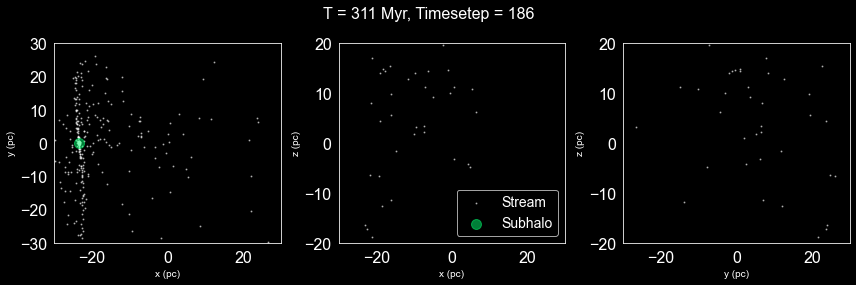

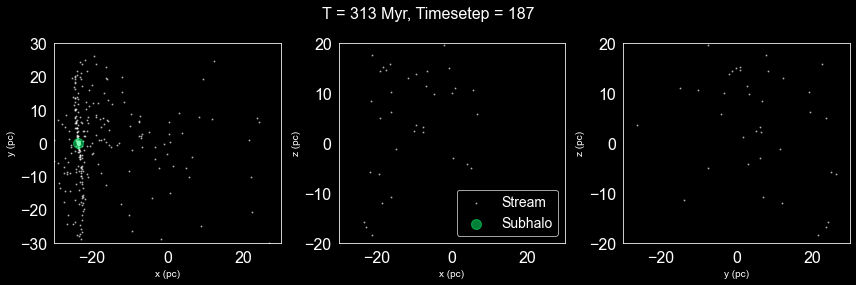

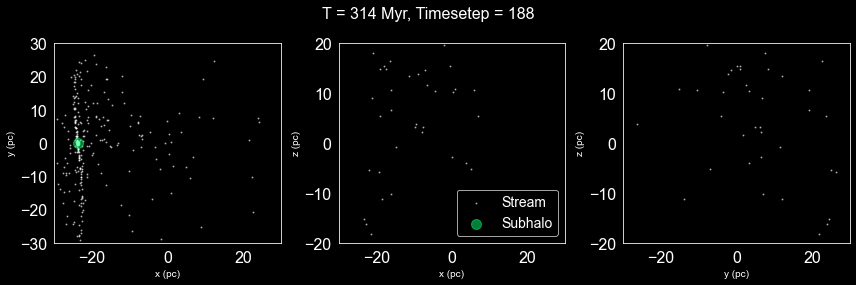

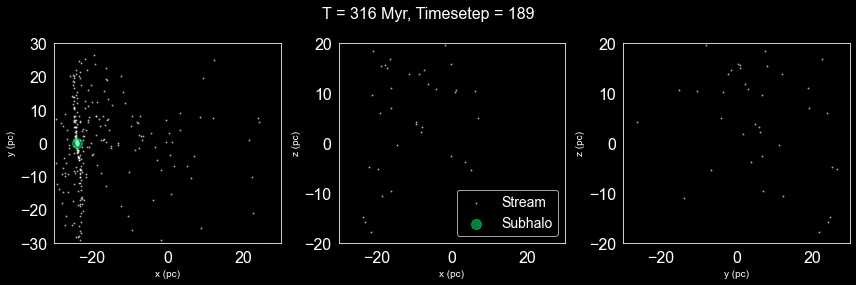

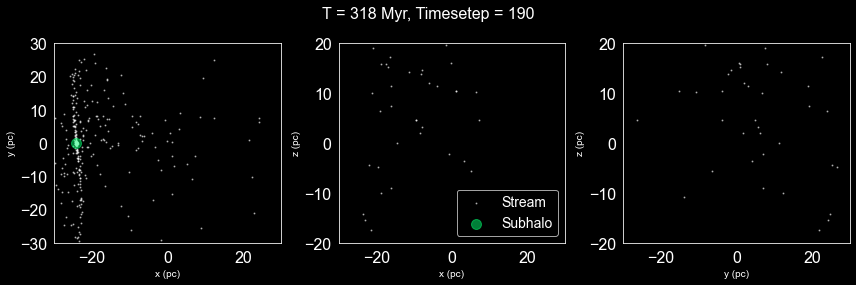

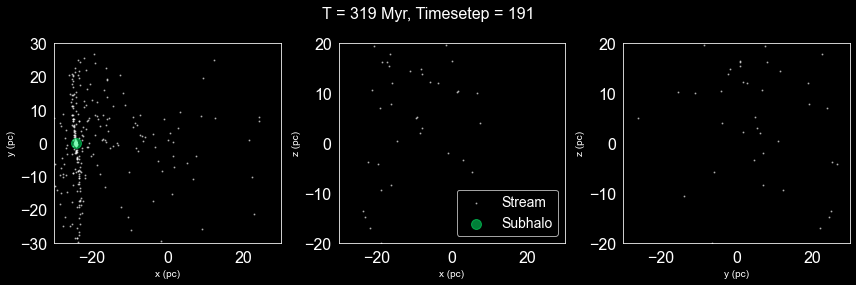

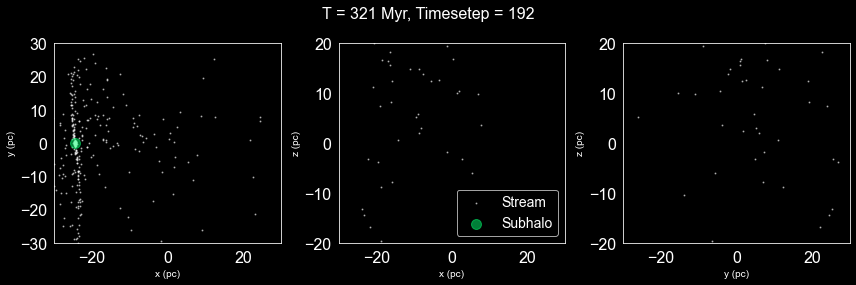

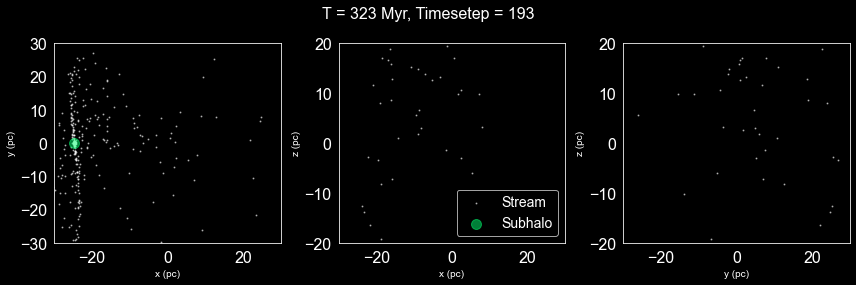

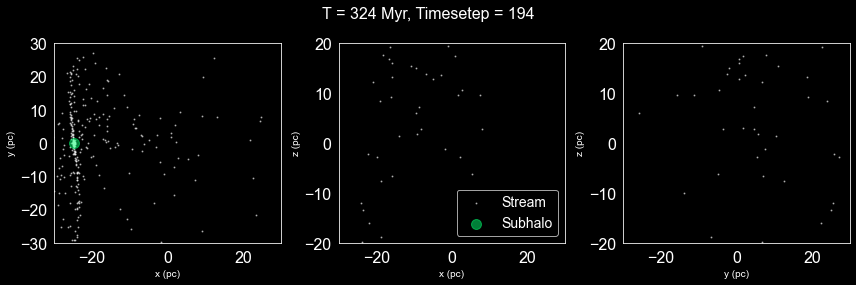

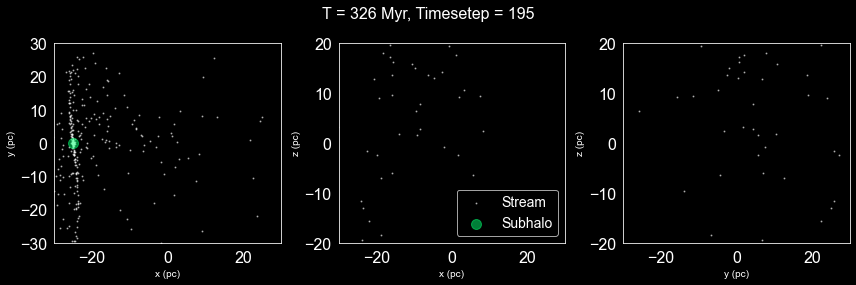

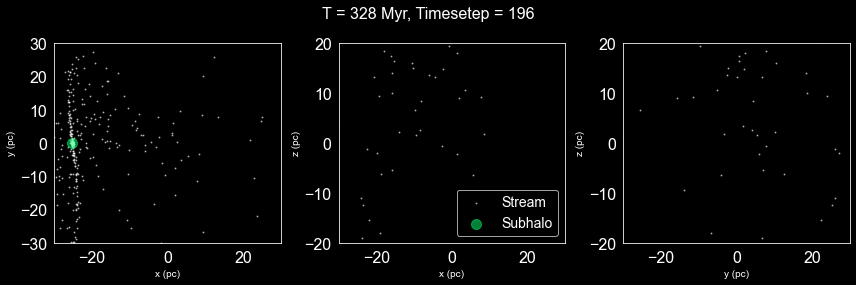

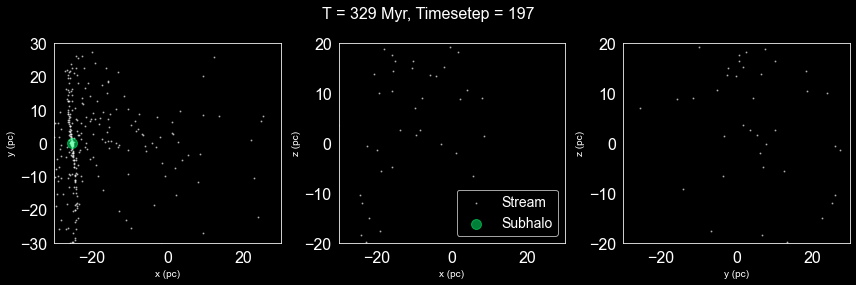

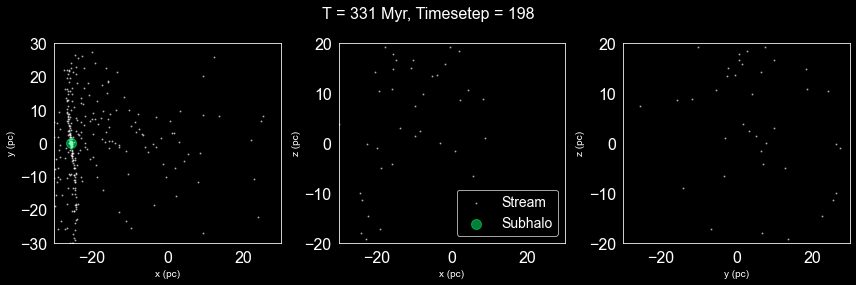

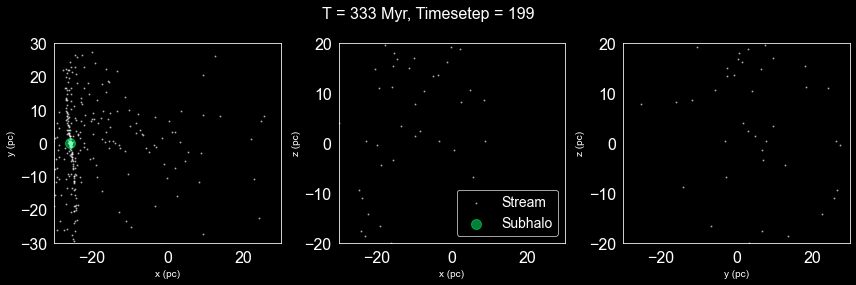

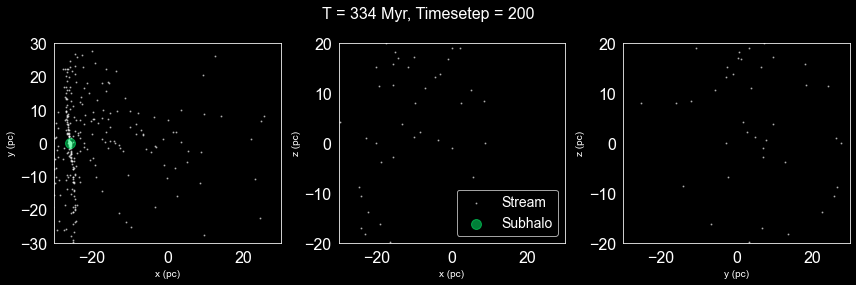

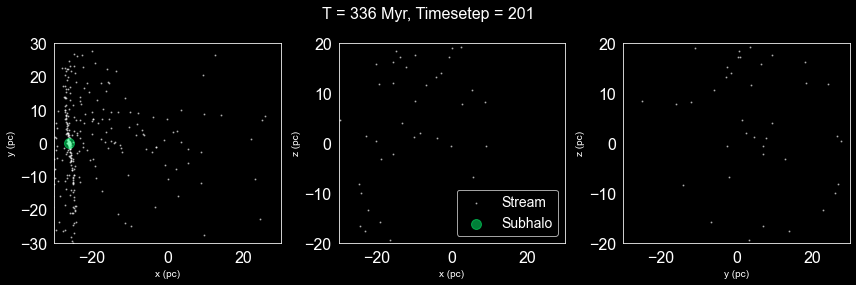

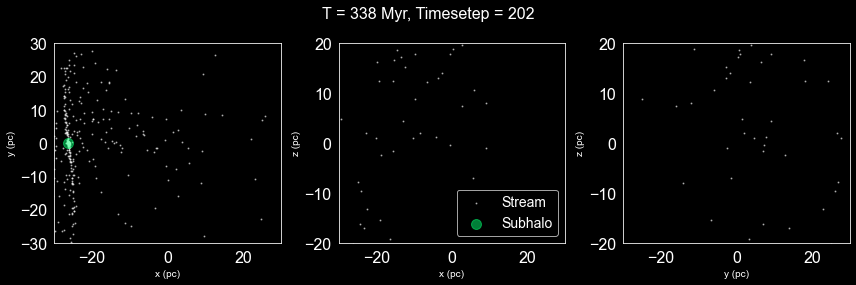

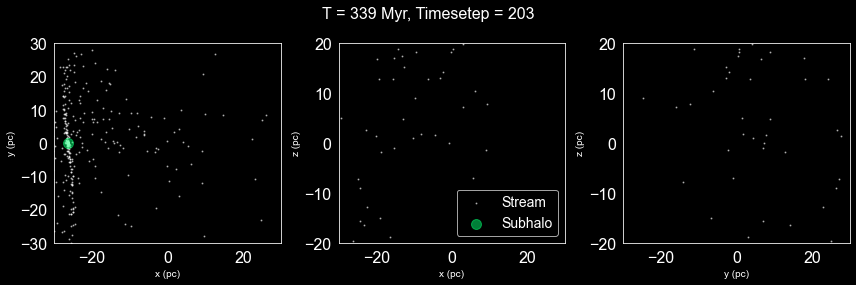

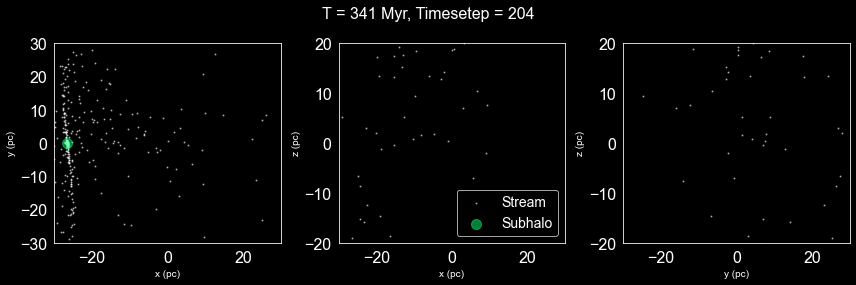

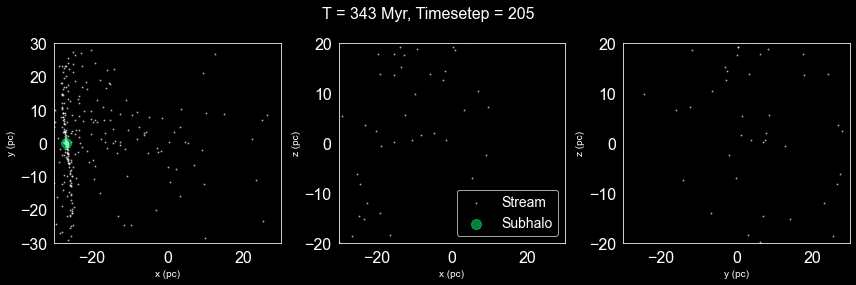

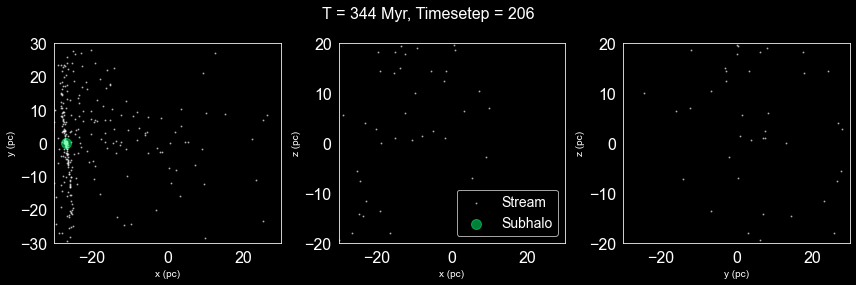

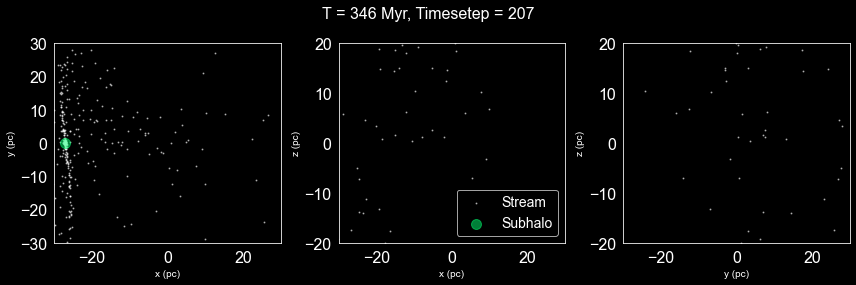

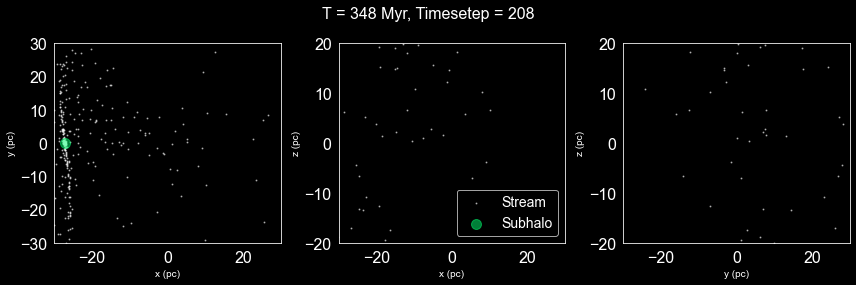

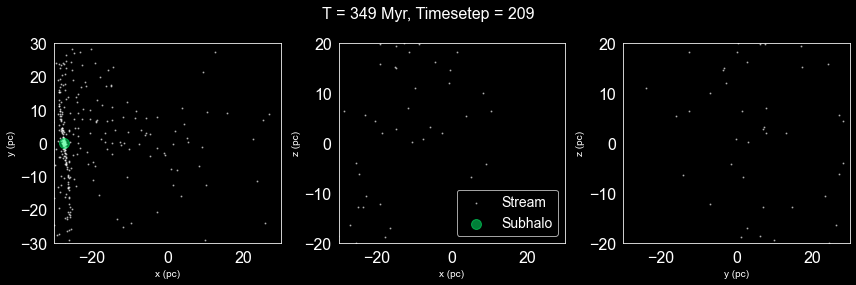

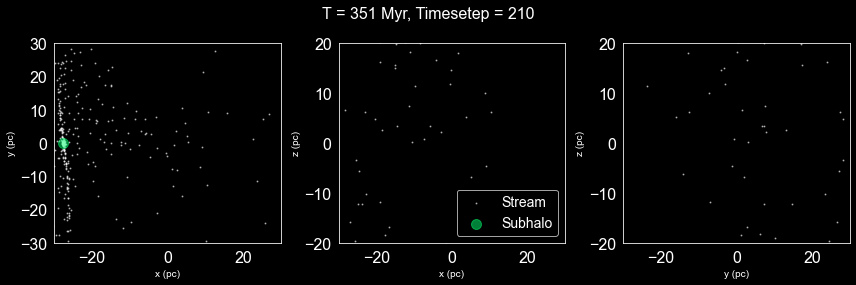

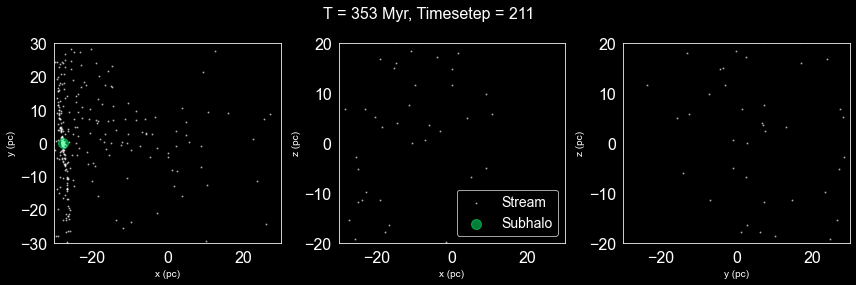

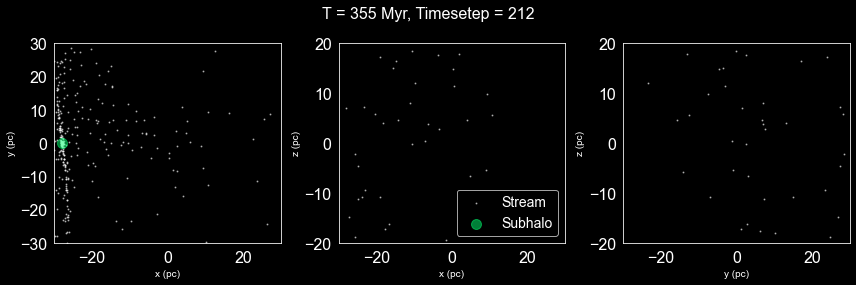

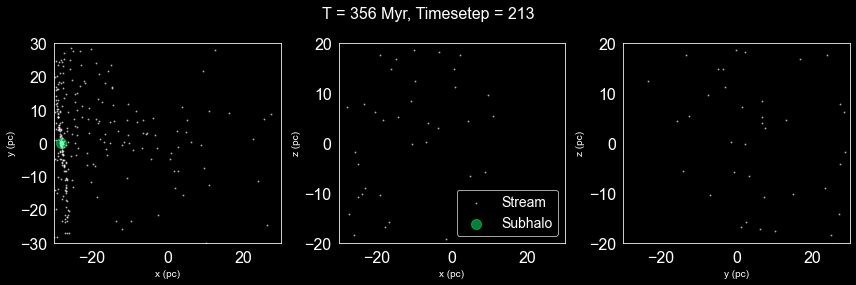

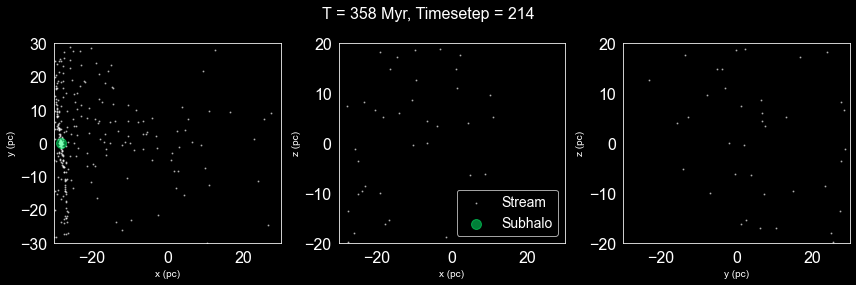

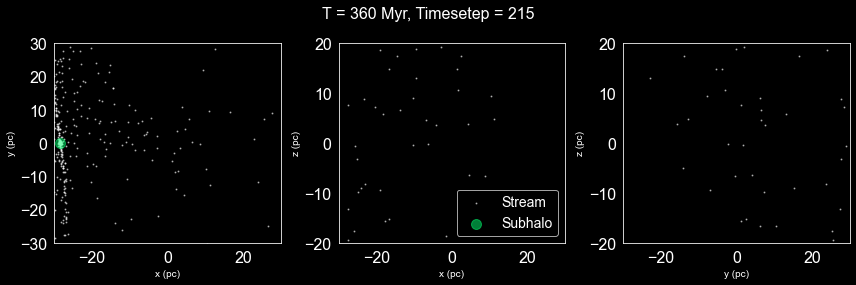

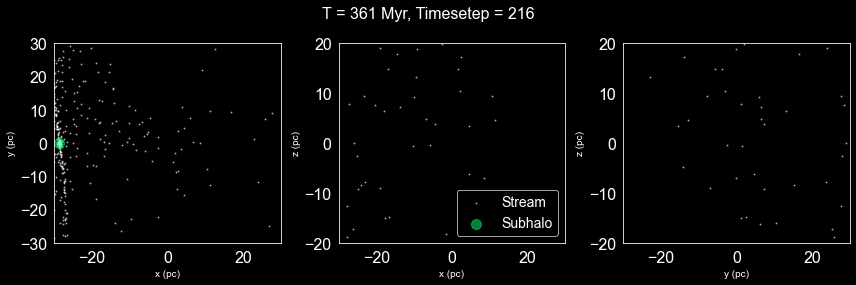

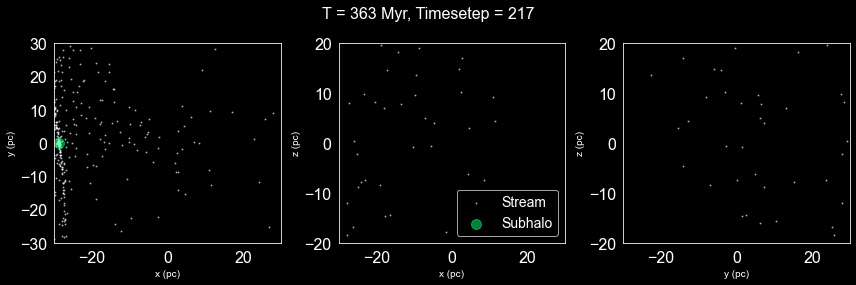

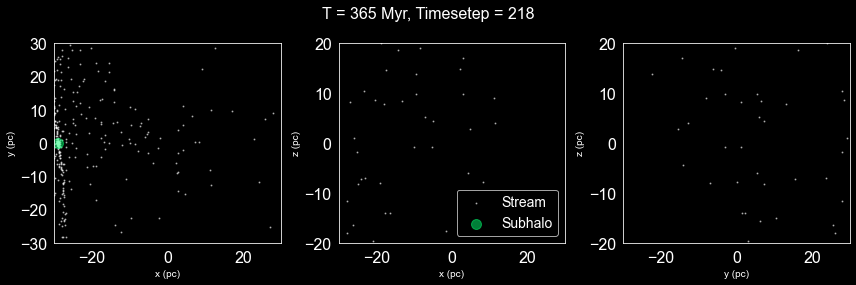

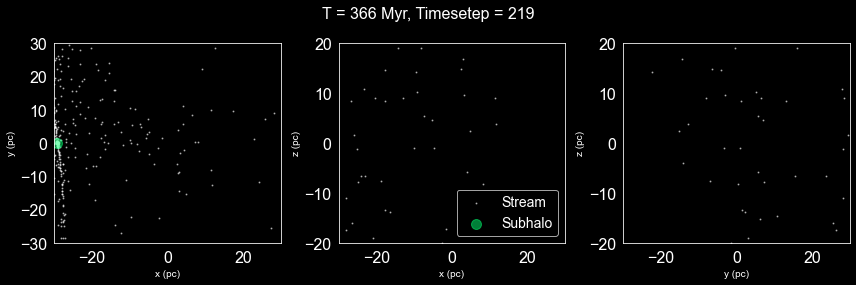

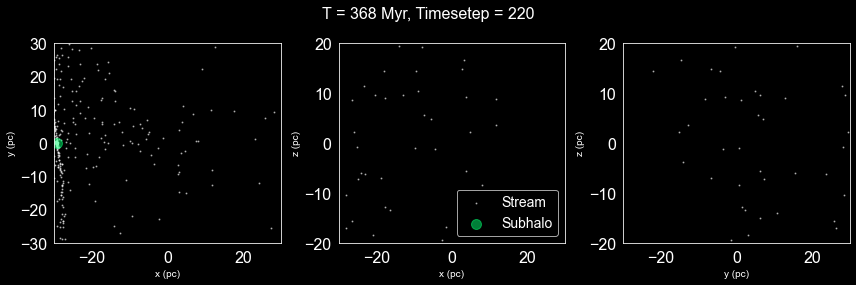

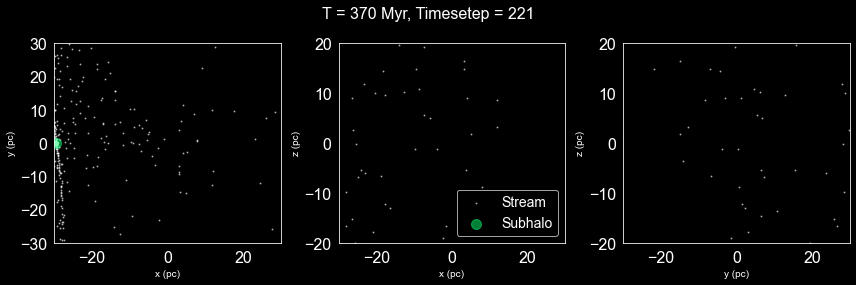

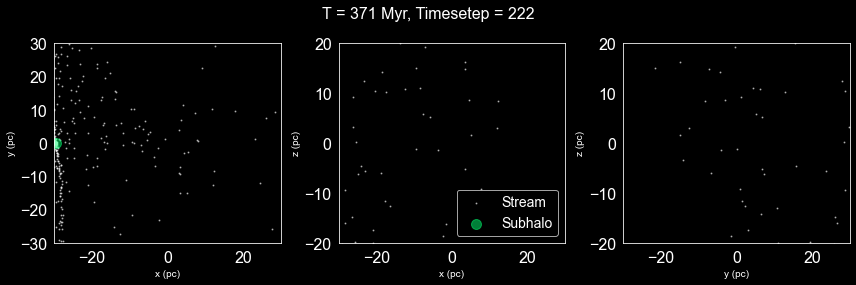

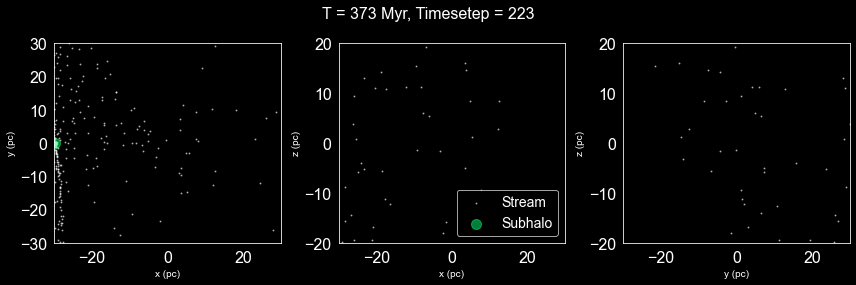

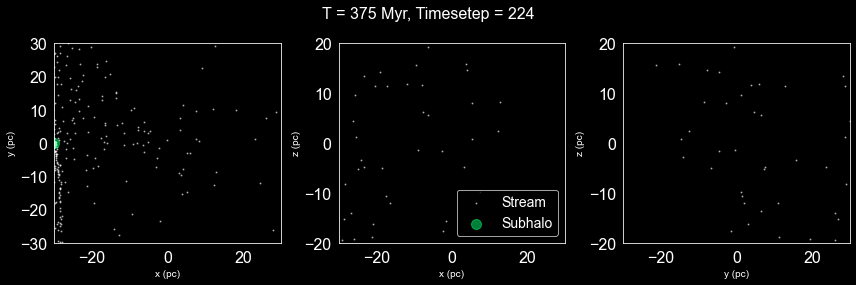

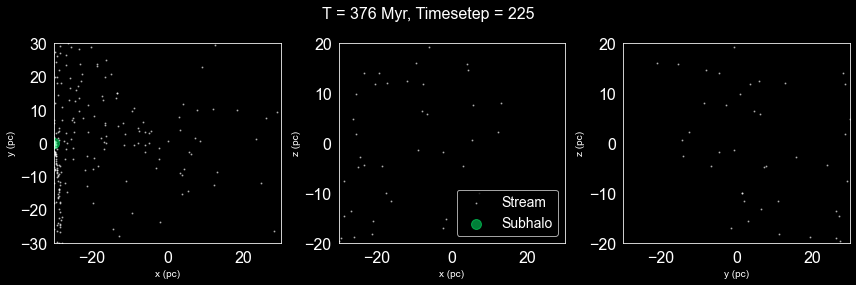

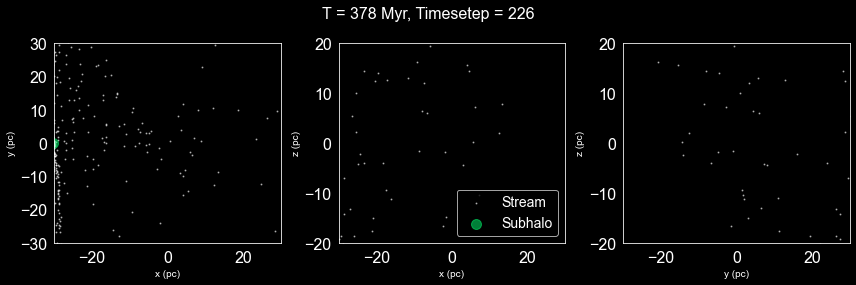

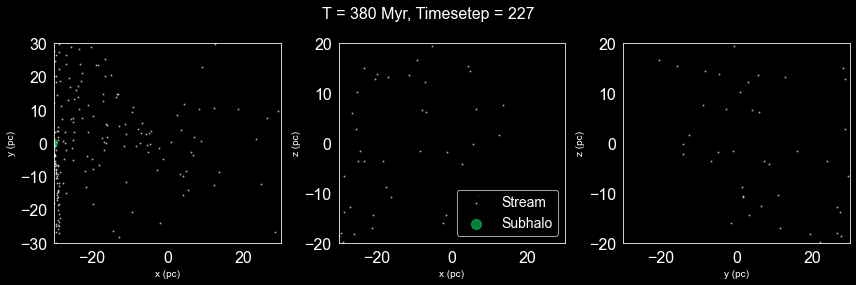

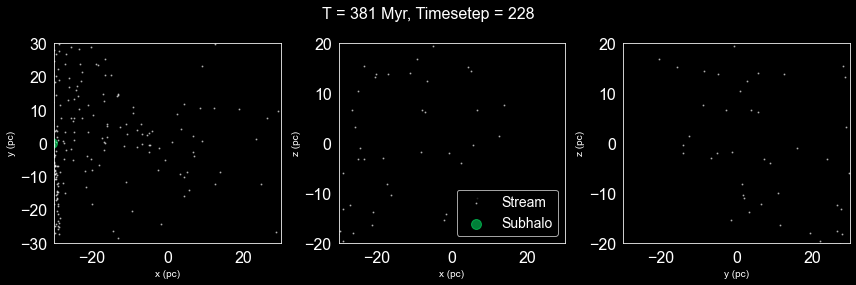

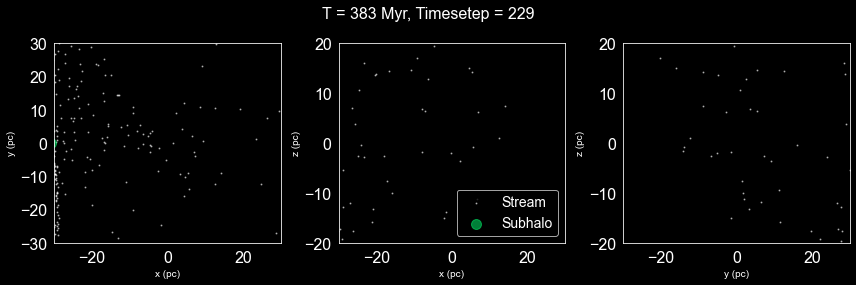

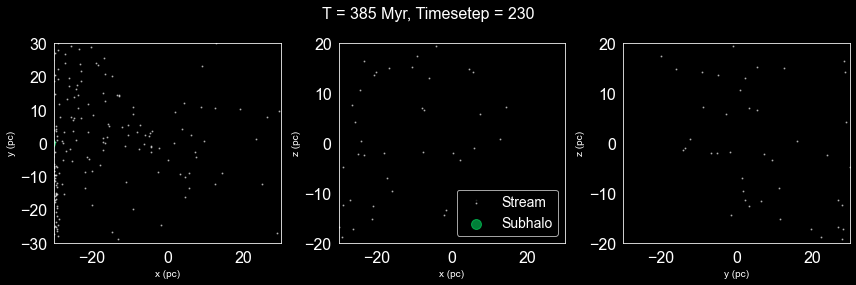

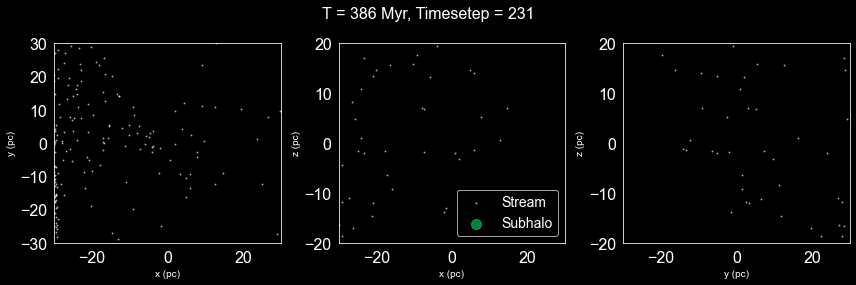

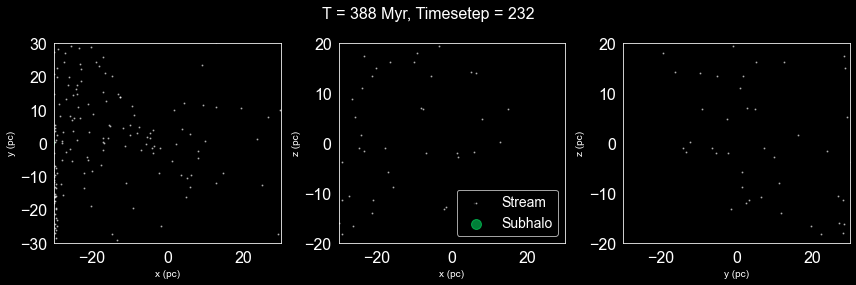

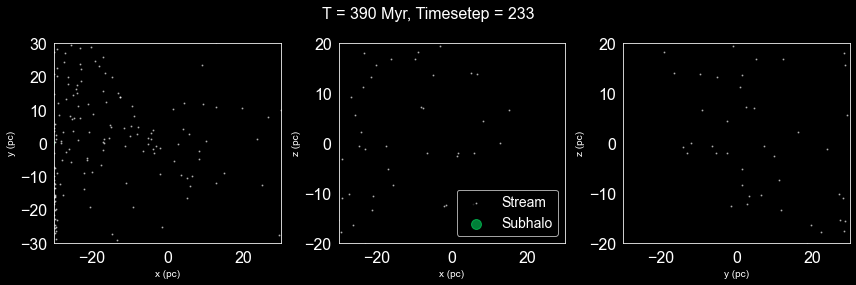

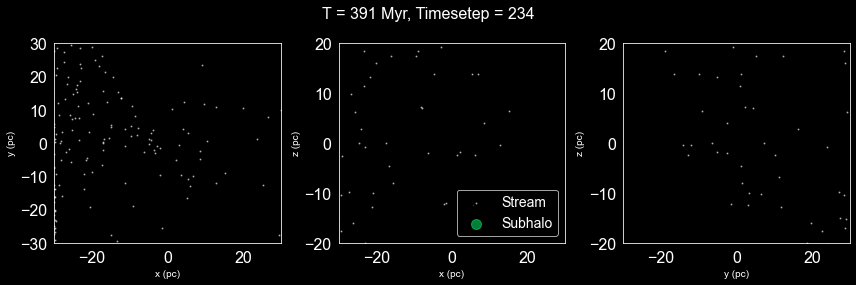

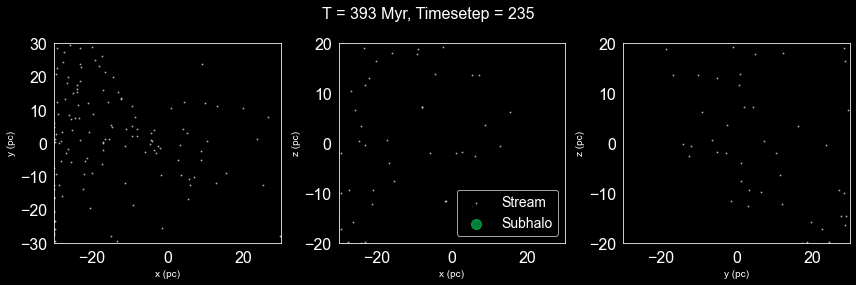

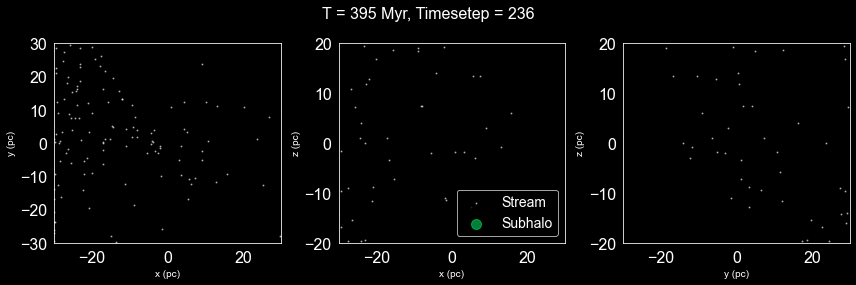

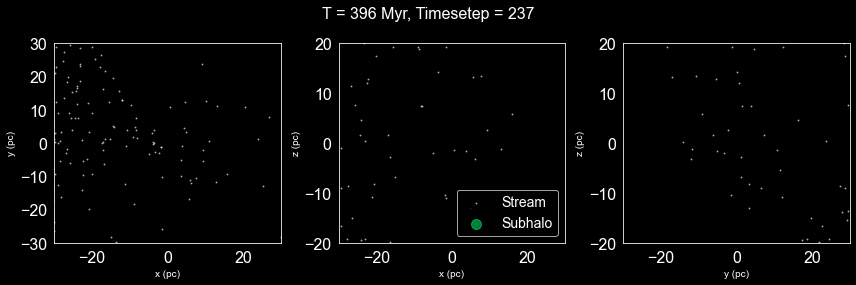

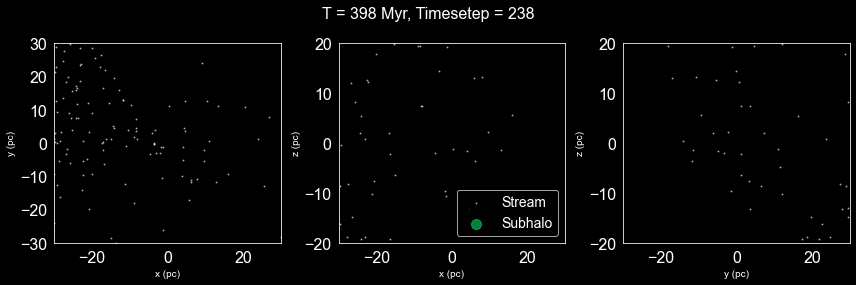

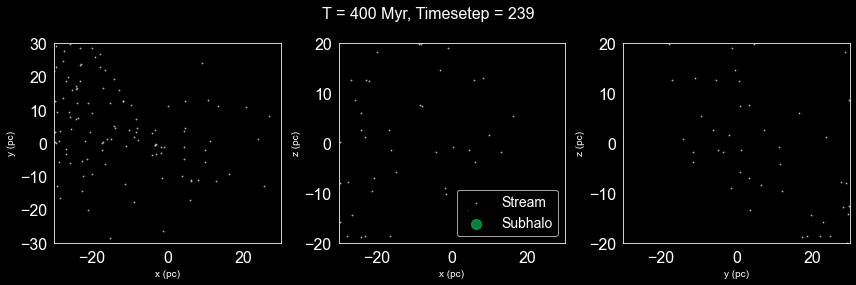

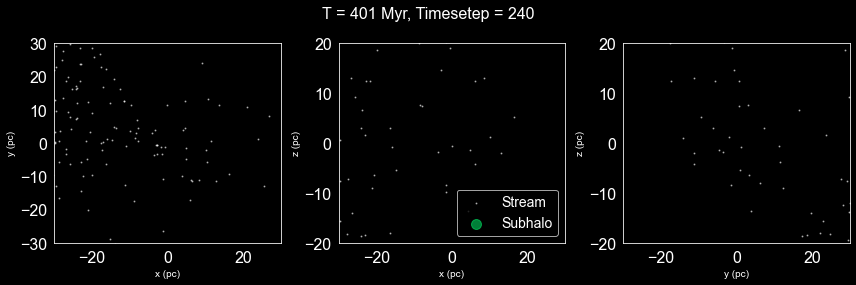

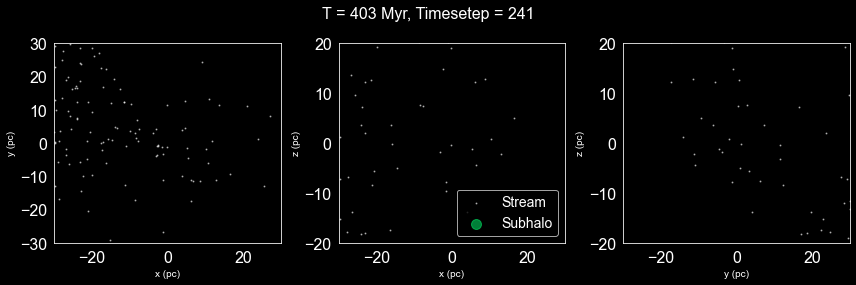

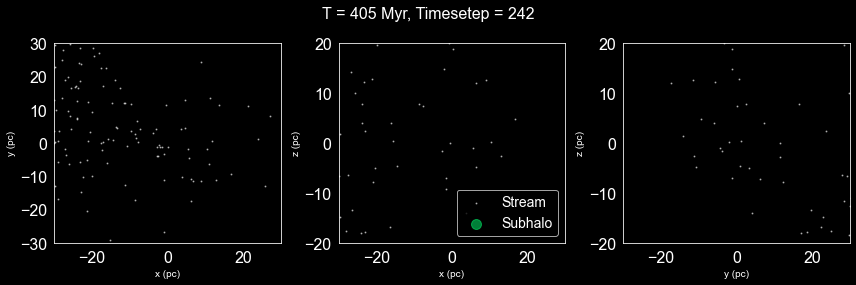

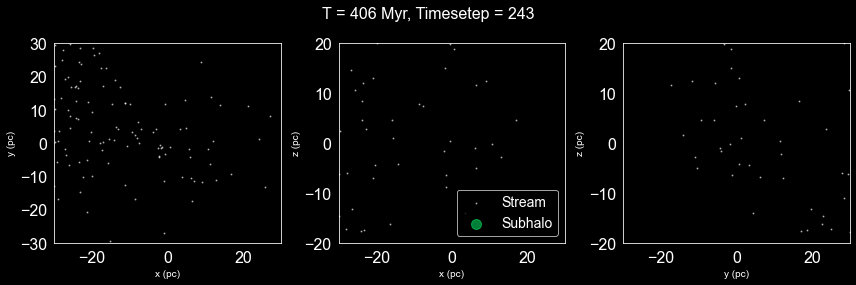

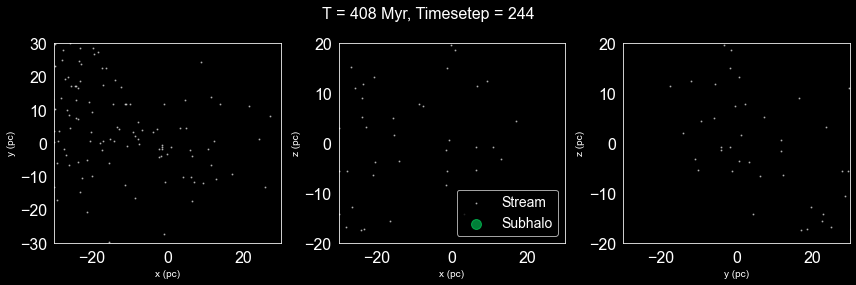

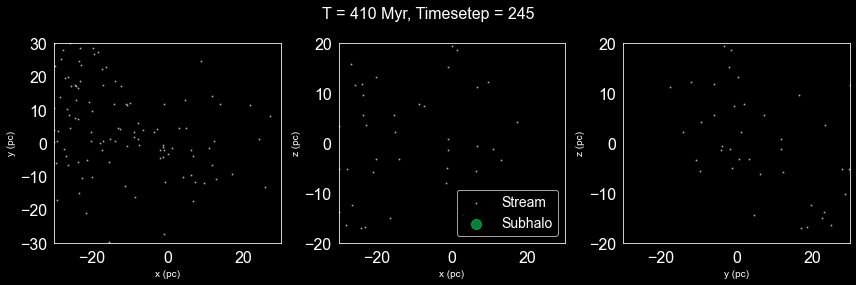

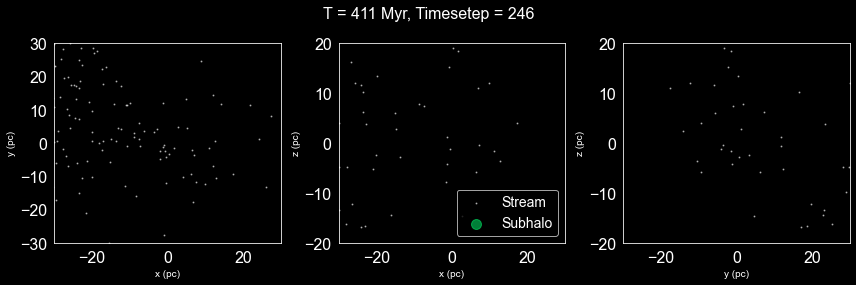

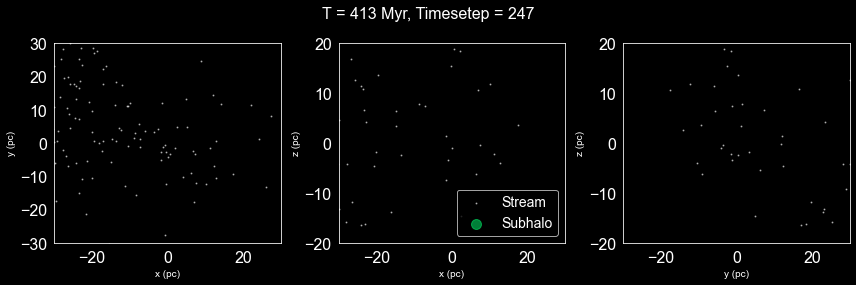

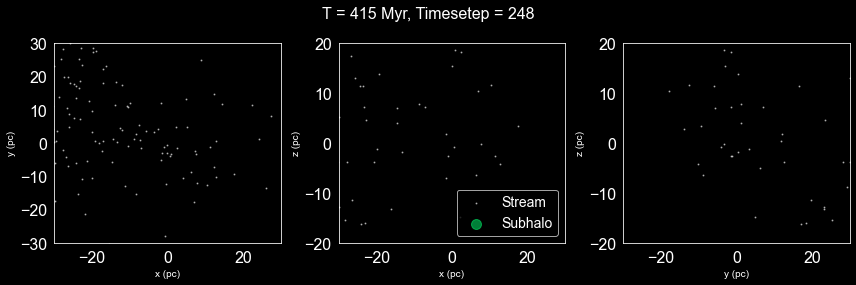

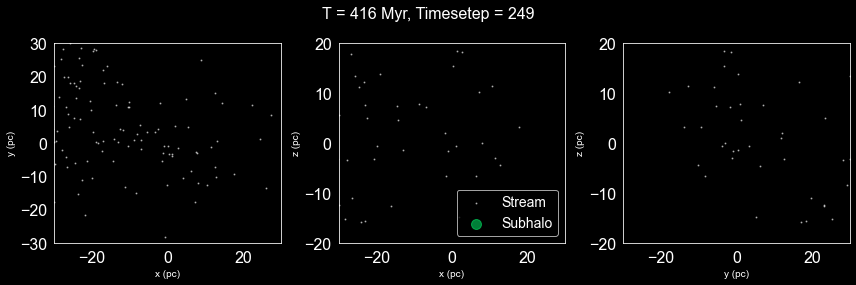

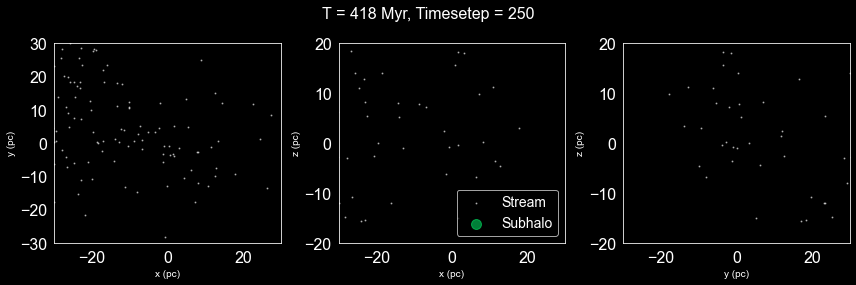

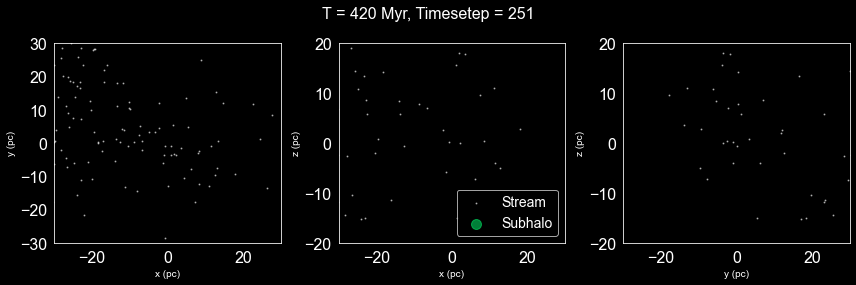

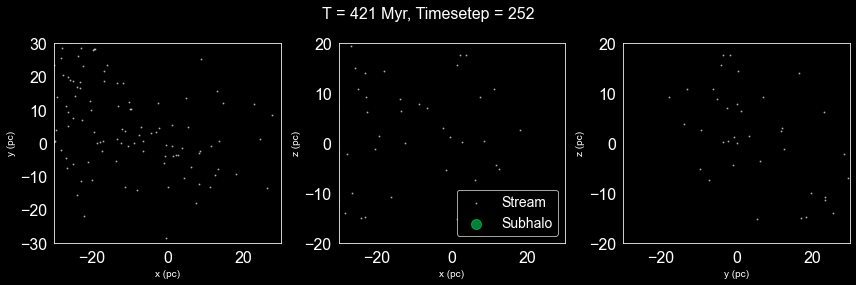

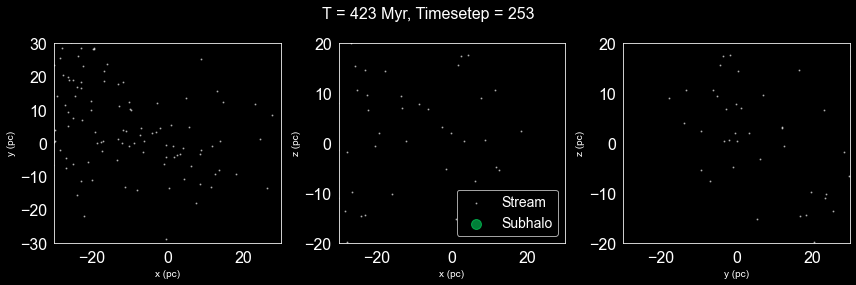

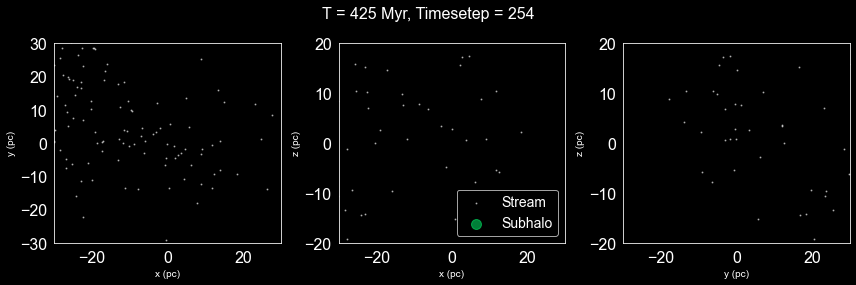

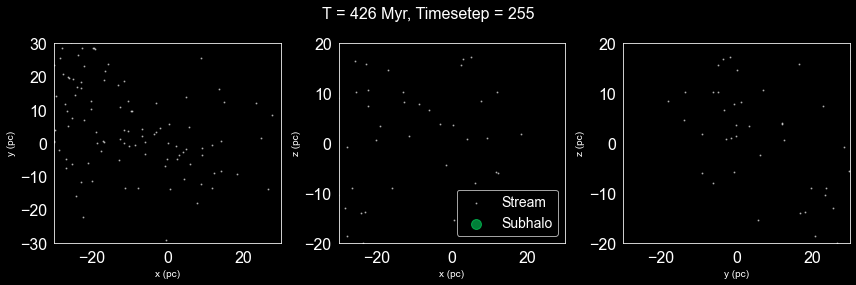

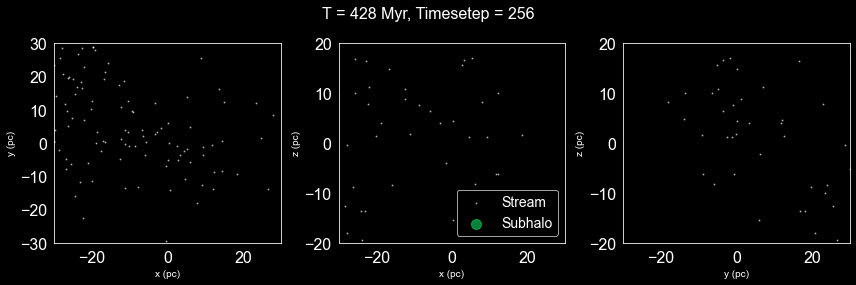

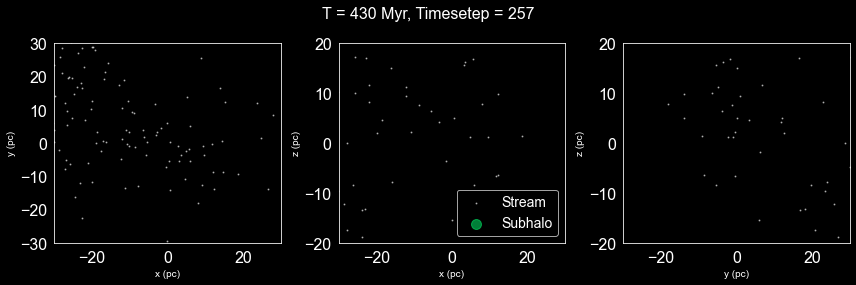

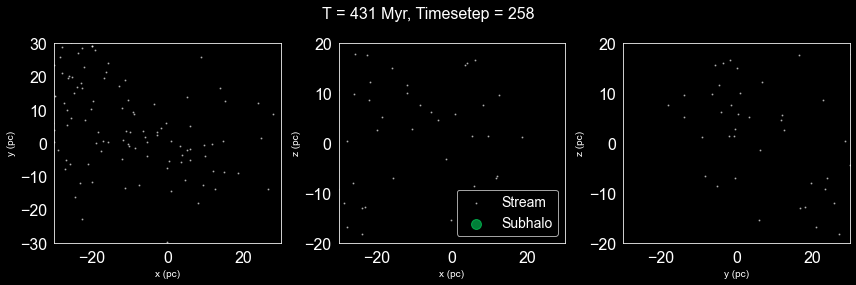

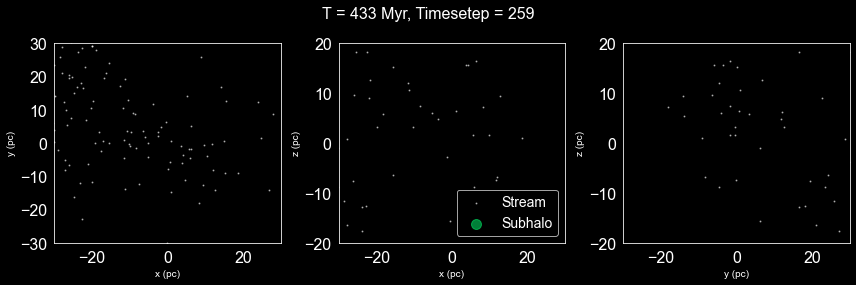

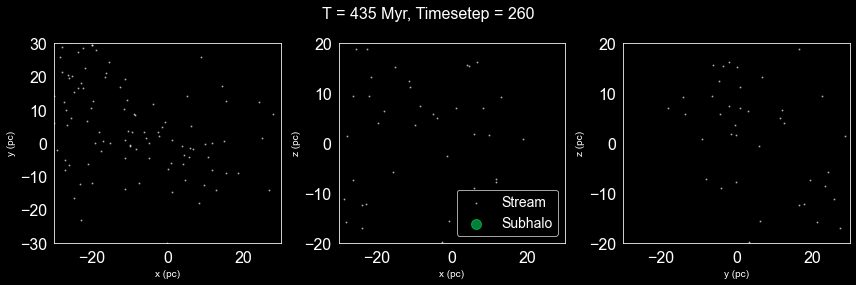

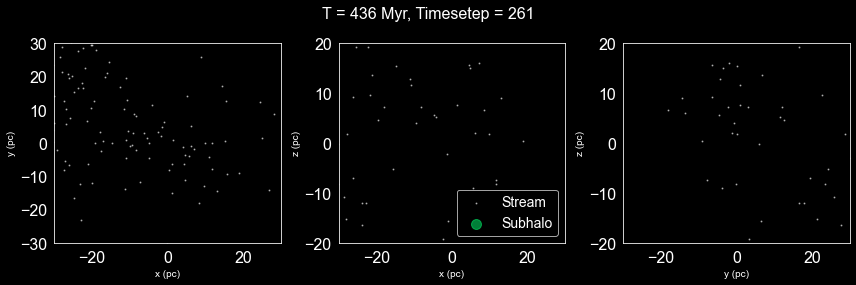

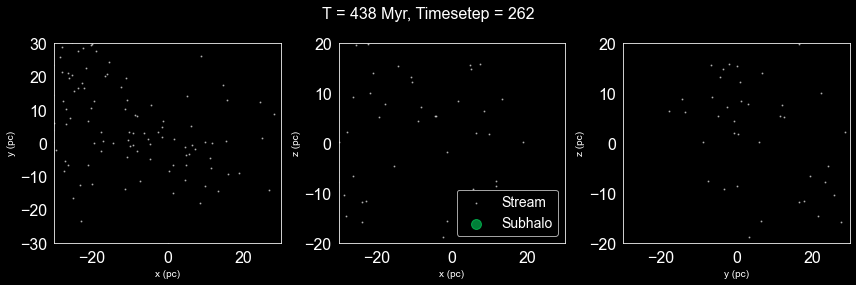

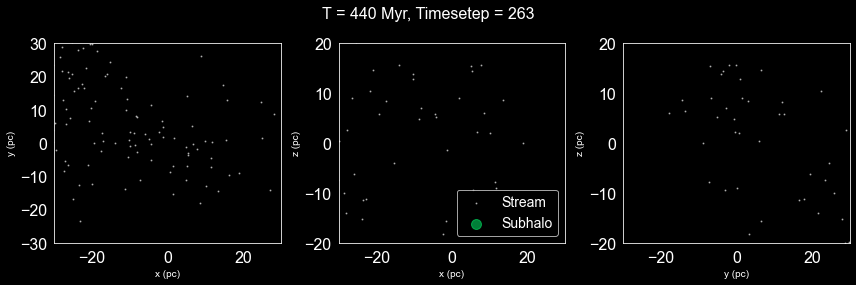

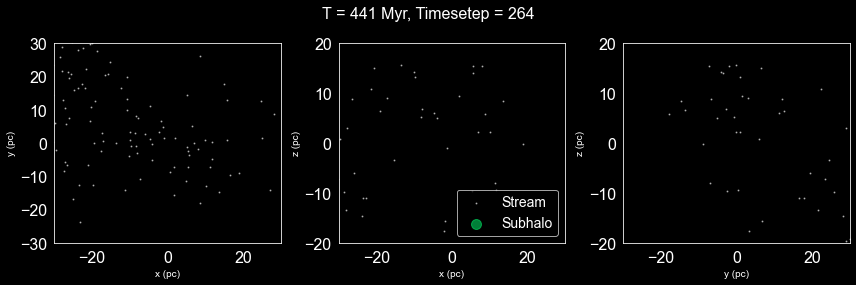

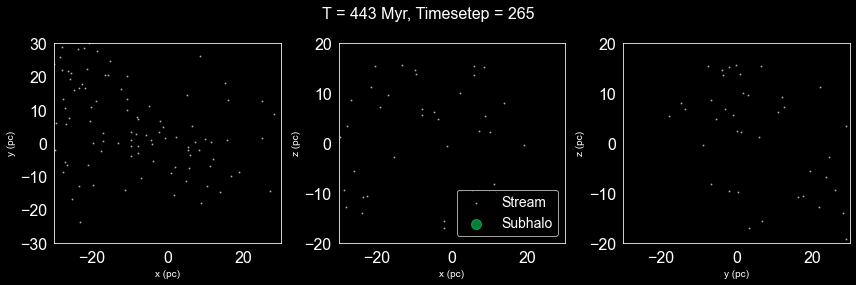

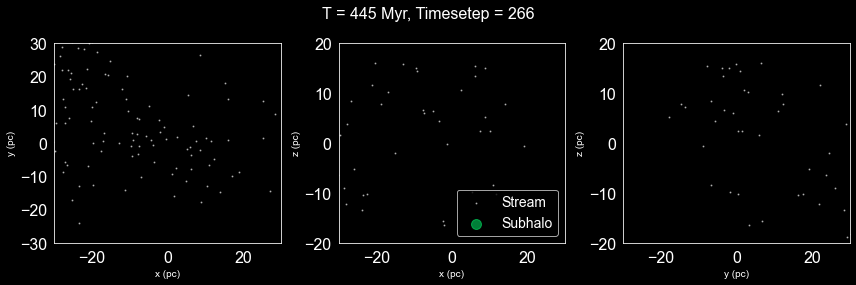

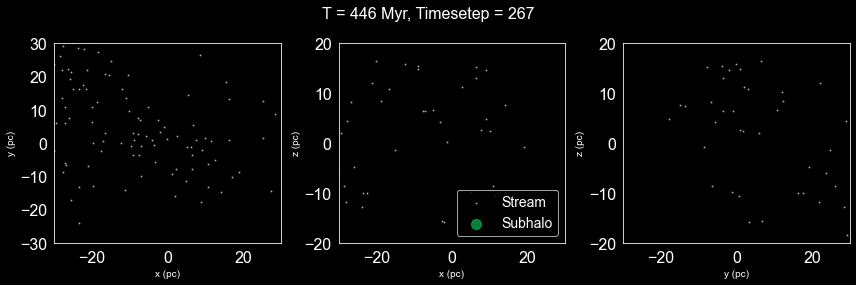

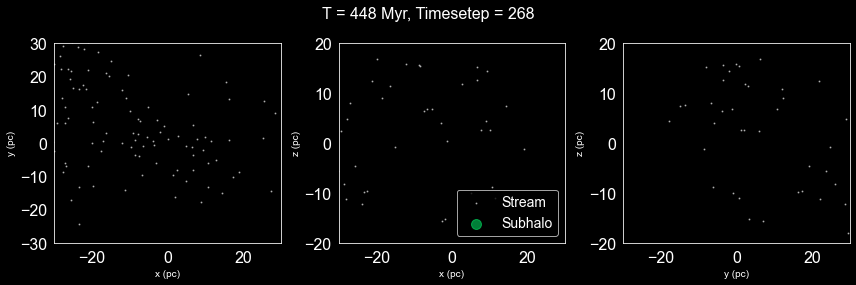

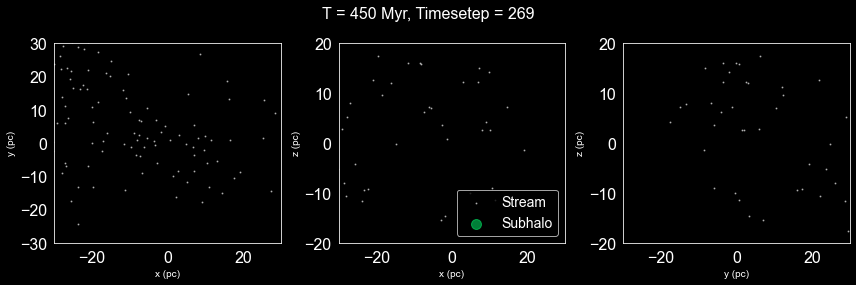

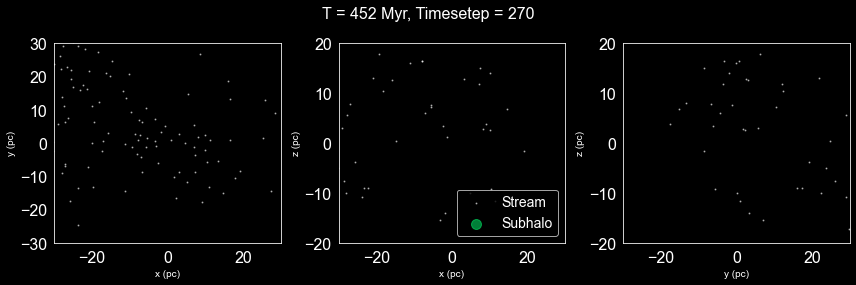

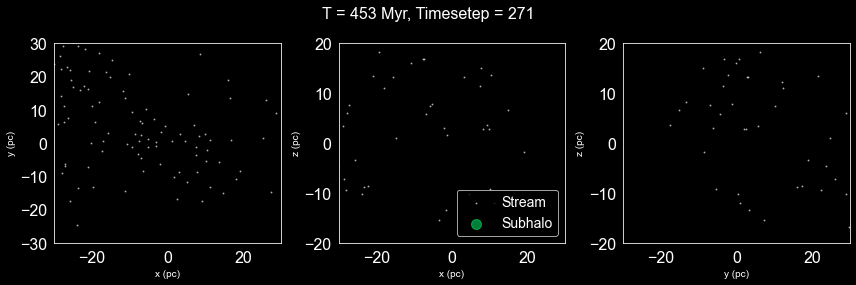

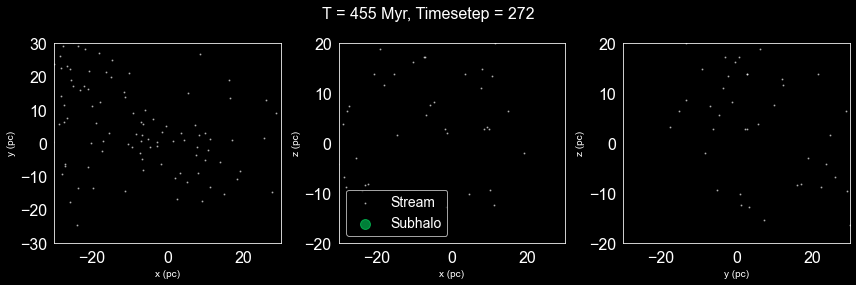

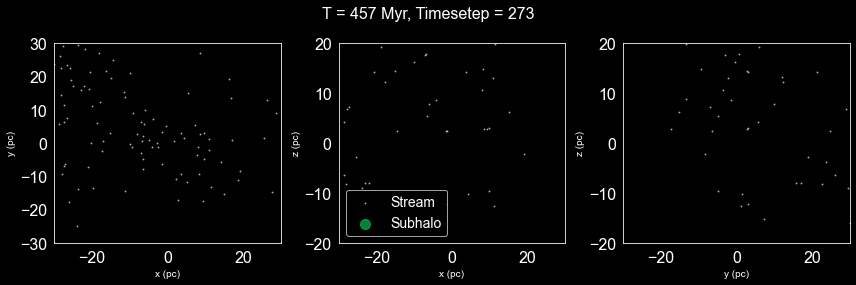

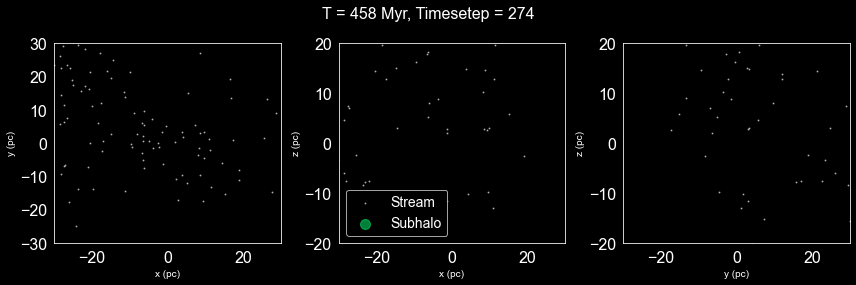

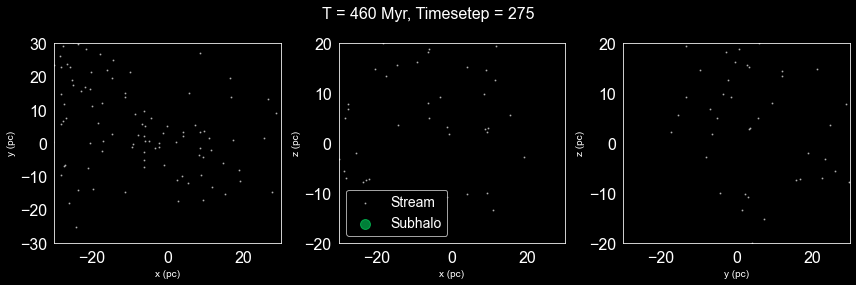

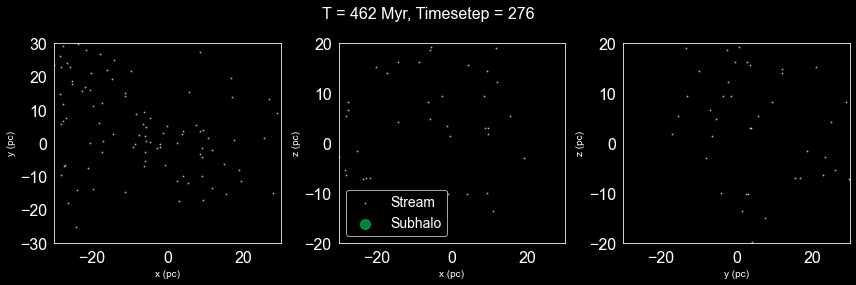

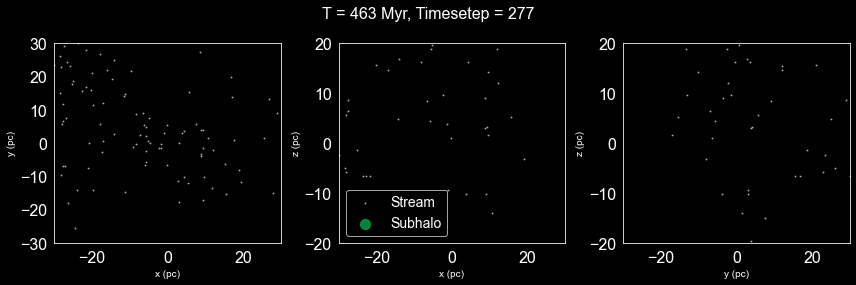

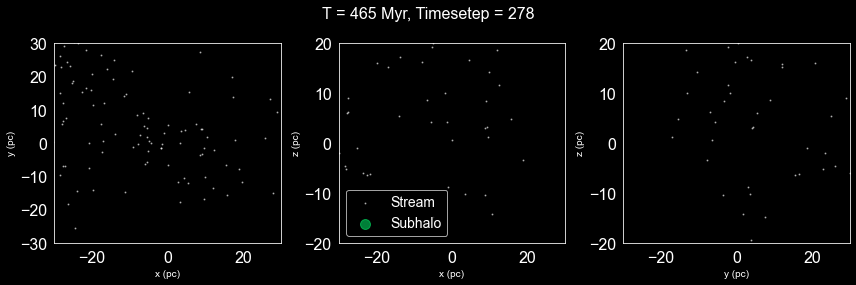

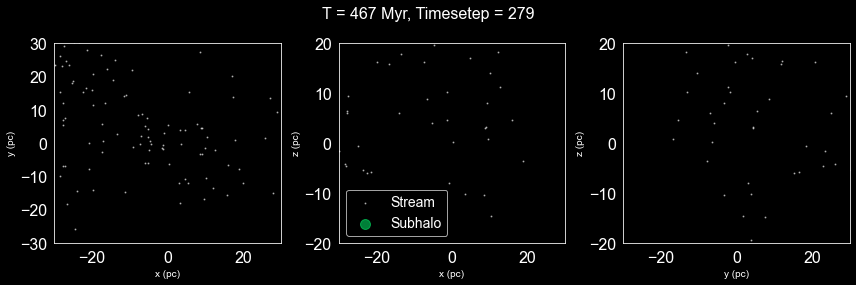

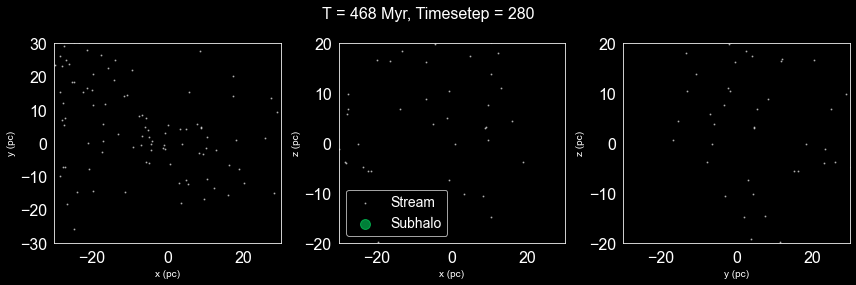

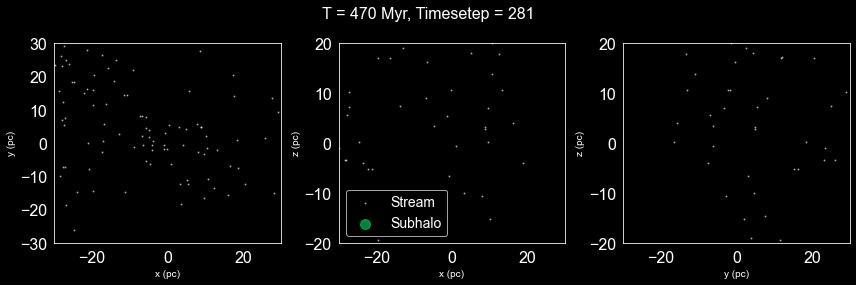

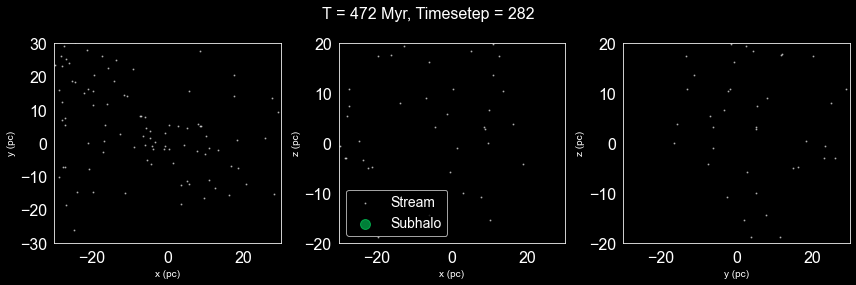

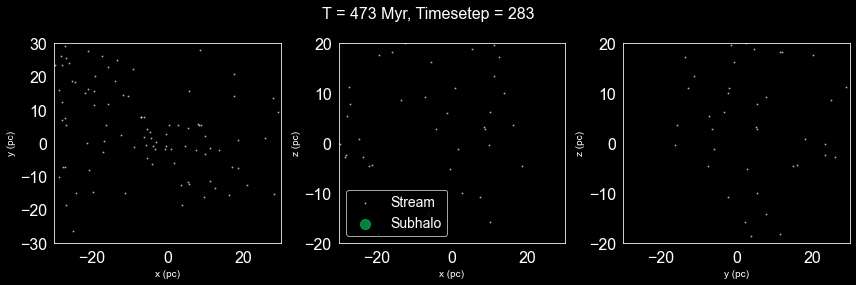

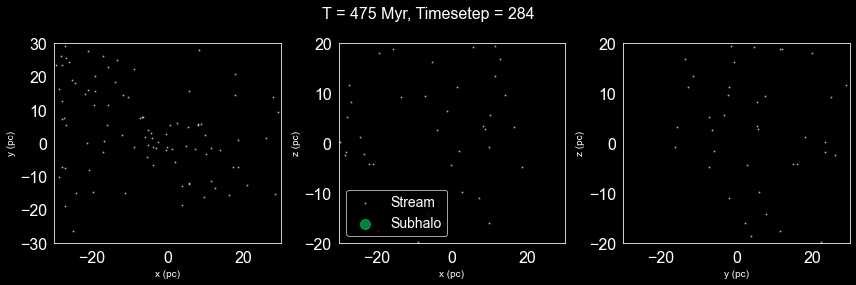

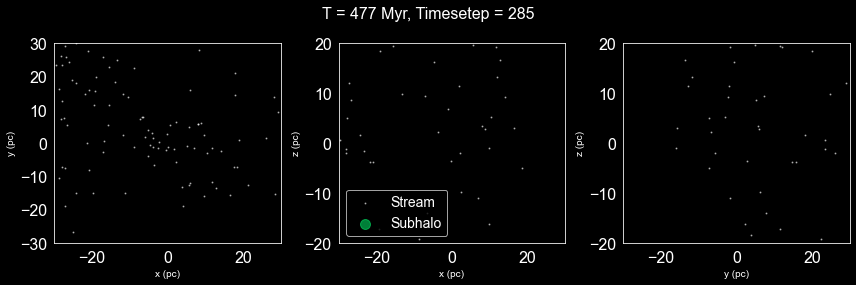

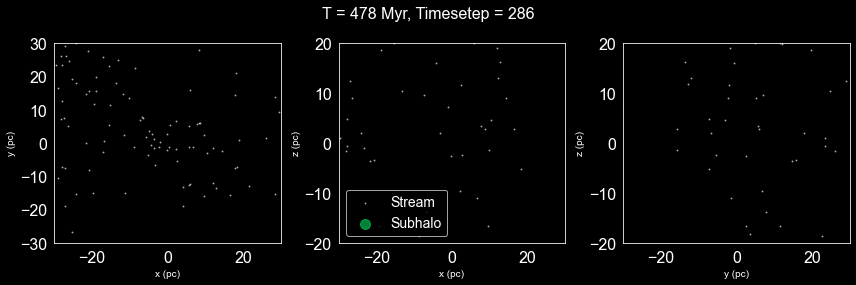

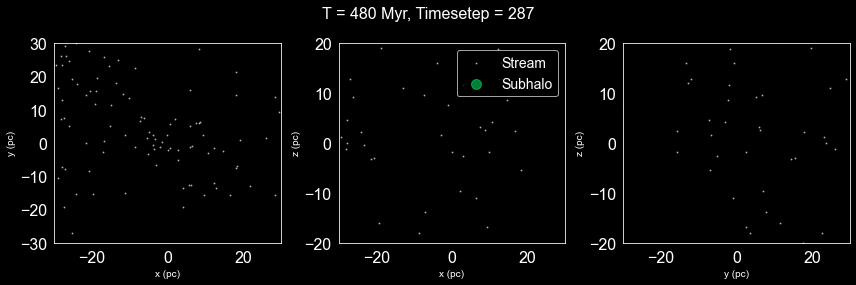

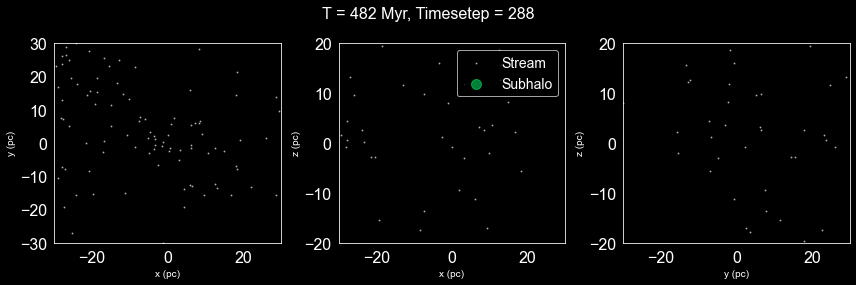

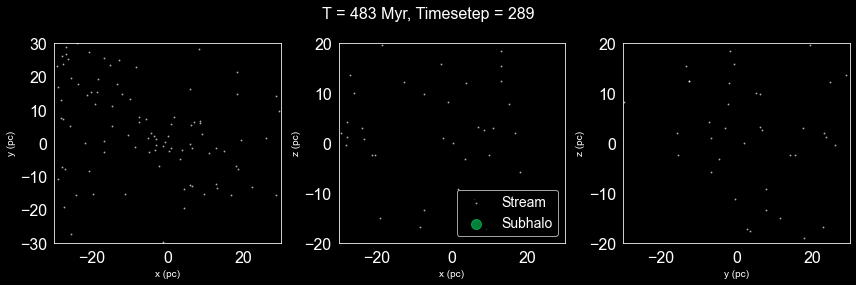

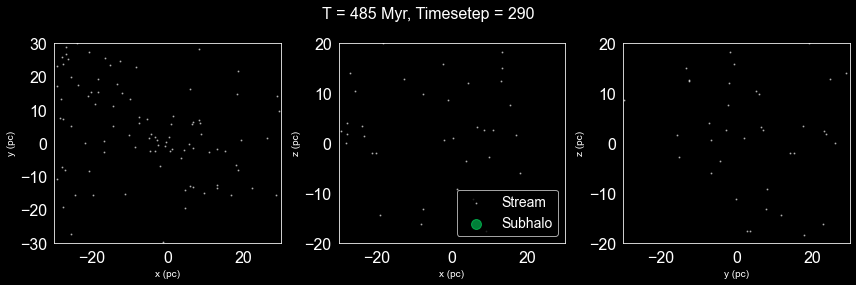

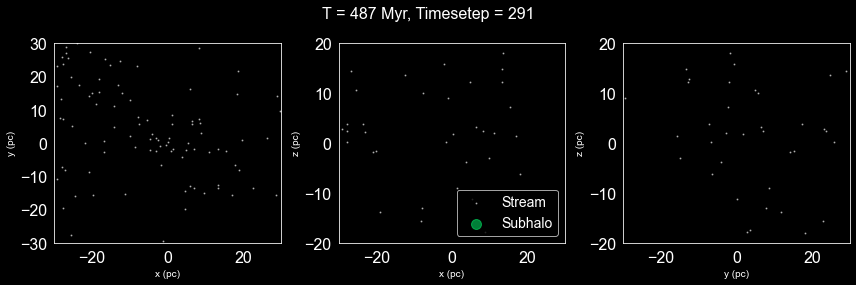

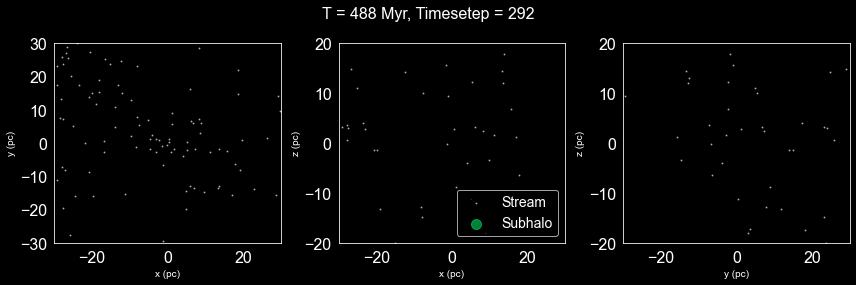

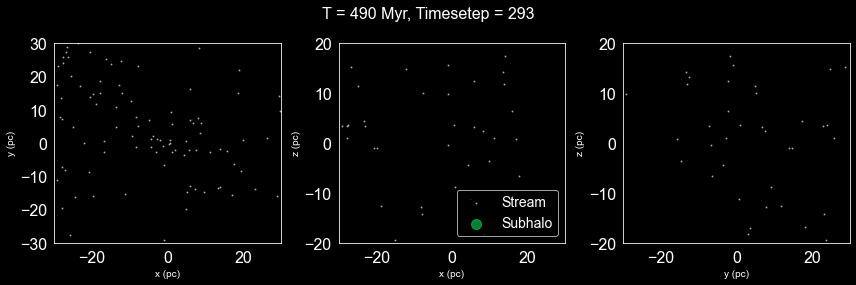

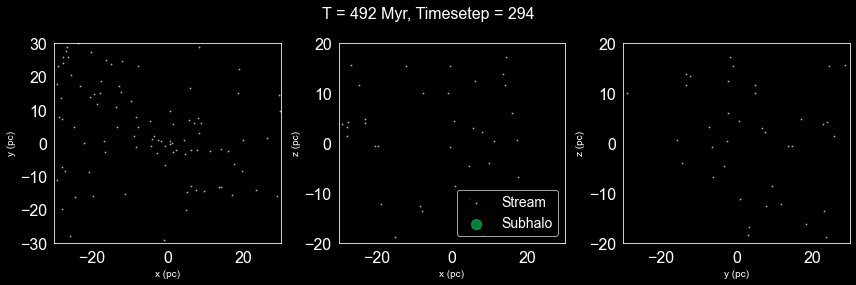

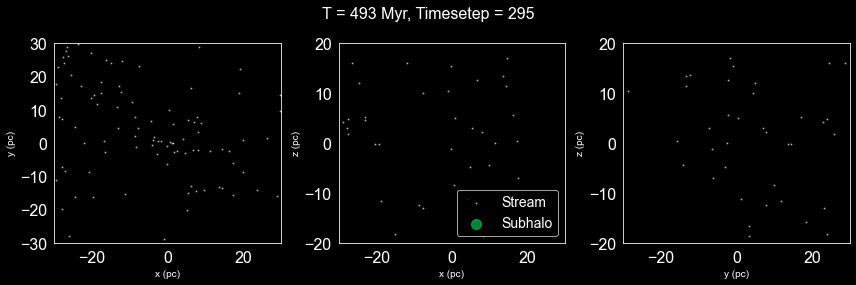

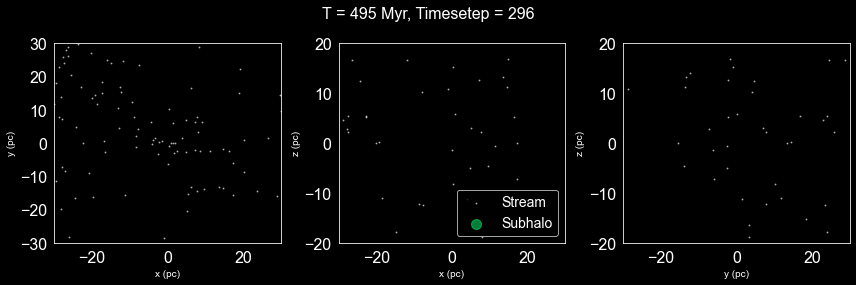

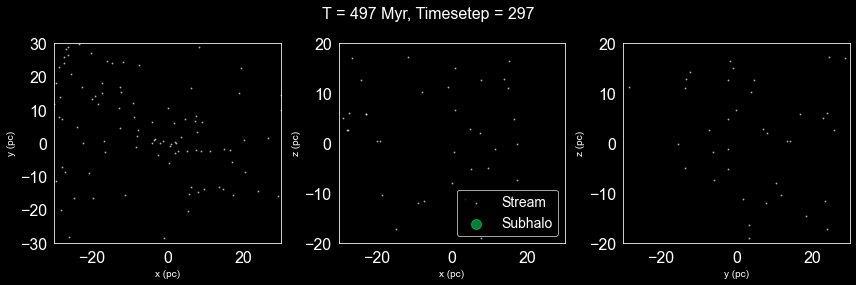

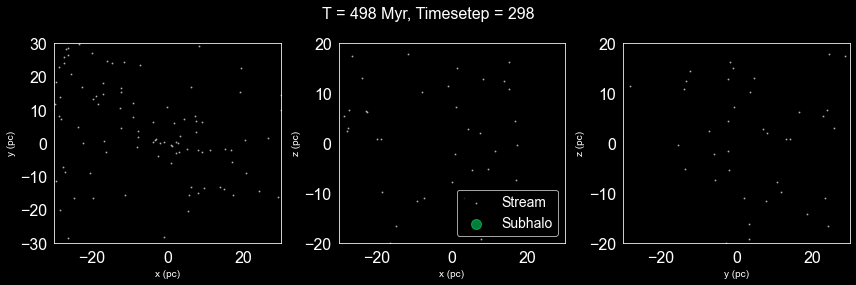

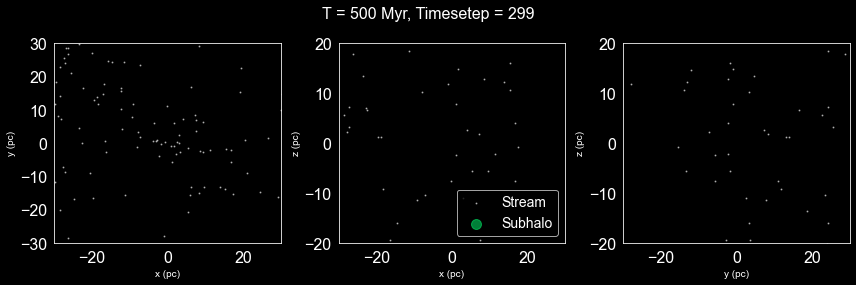

In [15]:
#plot gifs to see if there as a collision
kwargs_write = {'fps':10.0, 'quantizer':'nq'}
_= imageio.mimsave(path_plot+'/'+ filename+'.gif',\
                   [ plot_stream_and_body(i, stream_all, bdy_all,  time_dict,\
                    xlim=[-30, 30], ylim=[-30, 30], zlim=[-20, 20]) for i in \
                                     np.arange( bdy_all['pos'].shape[1])], \
                   fps=10.0)

In [ ]:
#try something else
#generate a stream
#pick a point on the stream
#integrate it back using a different velocity but same position
#give this these positions to the nbody
#integrate stream and nbody in positive


In [ ]:
_=mock_st.plot(s=2, c='k')

In [ ]:
#pick a position
collision_pos=mock_st.cartesian.xyz[:,-150]

In [ ]:
#give it a velocity
collision_phase_space_pos=gd.PhaseSpacePosition(pos=collision_pos,
                                vel=[0, 0, -300] * u.km/u.s)
#integrate it back
collision_orbit= gp.Hamiltonian(pot).integrate_orbit(collision_phase_space_pos,  dt=-1*u.Myr,\
                                                     t1=0.*u.Myr, t2=-tmax*u.Myr)

In [ ]:
collision_pos

In [ ]:
collision_orbit.xyz[:,-1], collision_orbit.xyz[:,-1], collision_orbit.v_xyz[:,0]

In [ ]:
filename_bck=filename+'backintegrated'

In [ ]:
time_dict= {'t':np.linspace(0, tmax+200, int(1e3))*u.Myr}

In [ ]:
#collision_orbit[-1].v_xyz

In [ ]:
#create this as the halo orbit
collision_halo_pos=gd.PhaseSpacePosition(pos=collision_orbit.xyz[:,-1],
                              vel=collision_orbit.v_xyz[:,-1])
#collision_halo_pos=collision_orbit[-1]
#run it forard in time ith the stream
col_stream, col_pos =  run_stream_and_subhalo(mhalo, mstream, halo_r, collision_halo_pos, \
                                              st_pos,  time_dict,
                           filename=filename_bck,   potential_type='plummer')

In [ ]:
print ('initial conditions')
st_pos.xyz, collision_halo_pos.xyz

In [ ]:
print ('final conditions positions', col_pos.xyz.T)

In [ ]:
print ('final conditions velocities', col_pos.v_xyz.T)

In [ ]:
print ('desired final conditions', collision_orbit.xyz[:,0])

In [ ]:
#out
#visualize
bdy_all, stream_all=read_stream_file(filename_bck)

In [ ]:
fig, (ax, ax1, ax2)=plt.subplots(ncols=3, figsize=(12, 4))
ax.plot(bdy_all['pos'][:,:,0][0], bdy_all['pos'][:,:,0][1],\
        label='Stream')
c=ax.plot(bdy_all['pos'][:,:,1][0], bdy_all['pos'][:,:,1][1], \
        label='Subhalo')

ax1.plot(bdy_all['pos'][:,:,0][0], bdy_all['pos'][:,:,0][-1],\
        label='Stream')
c=ax1.plot(bdy_all['pos'][:,:,1][0], bdy_all['pos'][:,:,1][-1], \
        label='Subhalo')

ax2.plot(bdy_all['pos'][:,:,0][1], bdy_all['pos'][:,:,0][-1],\
        label='Stream')
c=ax2.plot(bdy_all['pos'][:,:,1][1], bdy_all['pos'][:,:,1][-1], \
        label='Subhalo')

ax.scatter(collision_pos[0], collision_pos[1], marker='x', s=100, c='k')
ax1.scatter(collision_pos[0], collision_pos[-1], marker='x', s=100, c='k')
ax2.scatter(collision_pos[1], collision_pos[-1], marker='x', s=100, c='k')

plt.legend()
ax.set( xlabel='x (pc)', ylabel=' y (pc)')
ax1.set( xlabel='x (pc)', ylabel=' z (pc)')
ax2.set( xlabel='y (pc)', ylabel=' z (pc)')
#cbar=plt.colorbar(c)
#cbar.ax.set(ylabel='Time (Myr)')
plt.tight_layout()

In [ ]:
idxs=np.logical_and(time_dict['t'].value > 470, time_dict['t'].value < 530)

In [ ]:
steps=np.arange(len(time_dict['t'].value))[idxs]

In [ ]:
len(steps)

In [ ]:
#hgjk

In [ ]:
if False :
    for s in steps:
        st_snapshot=stream_all['pos'][:, s, :]

        st_body, hl_body=(bdy_all['pos'][:, s, :]).T

        fig, ax=plt.subplots(ncols=3, figsize=(12, 4))

        ax[0].scatter( st_snapshot[0], st_snapshot[1], s=1, alpha=0.5)
        ax[1].scatter( st_snapshot[0], st_snapshot[-1], s=1, alpha=0.5)
        ax[-1].scatter( st_snapshot[1], st_snapshot[-1], s=1, alpha=0.5)

        #ax[0].scater(st_body, )

        ax[0].scatter(collision_pos[0], collision_pos[1], marker='x', s=100, c='k')
        ax[1].scatter(collision_pos[0], collision_pos[-1], marker='x', s=100, c='k')
        ax[-1].scatter(collision_pos[1], collision_pos[-1], marker='x', s=100, c='k')

        for body in [st_body, hl_body]:

            ax[0].scatter(body[0], body[1], marker='o', s=100)
            ax[1].scatter(body[0], body[-1], marker='o', s=100)
            ax[-1].scatter(body[1], body[-1], marker='o', s=100)

        for a in ax:
            a.minorticks_on()

        ax[0].set( xlabel='x (pc)', ylabel=' y (pc)')
        ax[1].set( xlabel='x (pc)', ylabel=' z (pc)')
        ax[-1].set( xlabel='y (pc)', ylabel=' z (pc)')
        #cbar=plt.colorbar(c)
        plt.tight_layout()

In [ ]:
filename_bck

In [ ]:
path_plot

In [ ]:
#plot gifs to see if there as a collision
kwargs_write = {'fps':20.0, 'quantizer':'nq'}
_= imageio.mimsave(path_plot+'/'+ filename_bck+'.gif',\
                   [ plot_stream_and_body(i, stream_all, bdy_all,  time_dict,\
                    xlim=[-15, 15], ylim=[-15, 15], zlim=[-15, 15]) for i in \
                                     steps], \
                   fps=10.0)

In [ ]:
final_col_stream_pos=gd.PhaseSpacePosition(pos=col_stream.xyz,
                                           vel=col_stream.v_xyz)
final_progen_pos=gd.PhaseSpacePosition(pos=col_pos.xyz,
                                           vel=col_pos.v_xyz)

In [ ]:
final_stream_orbit=gp.Hamiltonian(pot).integrate_orbit(final_col_stream_pos,  dt=1*u.Myr,\
                                                     t1=0.*u.Myr, t2=200*u.Myr)

In [ ]:
final_prog_orbit=gp.Hamiltonian(pot).integrate_orbit(final_progen_pos,   dt=1*u.Myr,\
                                                     t1=0.*u.Myr, t2=200*u.Myr)

In [ ]:
np.shape(final_stream_orbit.xyz)

In [ ]:
_= final_stream_orbit.plot(c='b')

In [ ]:
#animate the gap evolution?
fig, anim = final_stream_orbit.animate(stride=10,   underplot_full_orbit=False,
                           FuncAnimation_kwargs=dict(interval=10), marker_style={'ms':2, 'c':'#7FDBFF'})

In [ ]:
anim.save(path_plot+'/gap_orbit{}.gif'.format(filename), dpi=80, writer='imagemagick')

In [ ]:
fig, (ax, ax1, ax2)=plt.subplots(ncols=3, figsize=(12, 4) )
ax.scatter(final_stream_orbit.x[-1], final_stream_orbit.y[-1],  s=1, alpha=0.2, c='#FFFFFF')
ax1.scatter(final_stream_orbit.y[-1], final_stream_orbit.z[-1], s=1, alpha=0.2, c='#FFFFFF')
ax2.scatter(final_stream_orbit.x[-1], final_stream_orbit.z[-1], s=1, alpha=0.2, c='#FFFFFF')

ax.scatter(final_prog_orbit[-1].x[0], final_prog_orbit[-1].y[0],  s=100, c='#0074D9')
ax1.scatter(final_prog_orbit[-1].y[0], final_prog_orbit[-1].z[0],  s=100, c='#0074D9')
ax2.scatter(final_prog_orbit[-1].x[0], final_prog_orbit[-1].z[0],  s=100, c='#0074D9')


ax.set( xlabel='x (pc)', ylabel=' y (pc)')
ax1.set( xlabel='x (pc)', ylabel=' z (pc)')
ax2.set( xlabel='y (pc)', ylabel=' z (pc)')

ax.minorticks_on()
ax1.minorticks_on()
ax2.minorticks_on()

plt.tight_layout()
plt.savefig(path_plot+'/xyz_final{}.jpeg'.format(filename))

In [ ]:
stream_c = final_stream_orbit[-1].to_coord_frame(coord.ICRS)
proge_c=final_prog_orbit[-1].to_coord_frame(coord.ICRS)

In [ ]:
fig, ax=plt.subplots(figsize=(12, 4))
ax.scatter(stream_c.ra, stream_c.dec, s=1., c='#FFFFFF', alpha=1.)
ax.scatter(proge_c.ra[0], proge_c.dec[0],  s=100, c='#0074D9')
ax.set_xlabel('ra (deg)', fontsize=18)# ylabel='dec (deg)')
ax.set_ylabel('dec (deg)', fontsize=18)
plt.tight_layout()
plt.savefig(path_plot+'/ra_dec_final{}.jpeg'.format(filename))

In [ ]:
#rotate in the stream reference frame?
end_points=coord.SkyCoord(ra=[260., 320]*u.deg,
                        dec=[-40, 40]*u.deg)
#rotate in stream reference frame 
fr = gc.GreatCircleICRSFrame.from_endpoints(end_points[0], end_points[1],
                                            ra0=np.nanmean(stream_c.ra))
stream_c_fr = stream_c.transform_to(fr)

In [ ]:
fig, ax=plt.subplots(figsize=(12, 4))
ax.scatter(stream_c_fr.phi1, stream_c_fr.phi2,s=1., c='#FFFFFF', alpha=1.)
ax.minorticks_on()
ax.set(xlabel=r'$\phi_1$', ylabel=r'$\phi_2$')

In [ ]:
fav_stream=[stream_c_fr.phi1, stream_c_fr.phi2]

In [ ]:
#np.save(path_data+'/plummer_stream_real.npy', fav_stream)